### Dice Coefficient

In [ ]:
# FC and PPI dice coefficient for Experiment 2
import os
import numpy as np
import pandas as pd
import nibabel as nib
from scipy import stats

# Define study directories
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info_tool.csv'  # Updated for exp 2
output_dir = f'{results_dir}/exp2_dice_comparison'  # New directory for exp 2
os.makedirs(output_dir, exist_ok=True)

def dice_coefficient(img1_data, img2_data):
    """Calculate Dice coefficient between two binary arrays."""
    # Ensure binary
    img1_bin = (img1_data > 0).astype(int)
    img2_bin = (img2_data > 0).astype(int)
    
    # Calculate intersection
    intersection = np.sum(img1_bin * img2_bin)
    
    # Calculate Dice using formula: 2*intersection/(sum of elements)
    dice = 2.0 * intersection / (np.sum(img1_bin) + np.sum(img2_bin))
    
    return dice

def analyze_data_type(analysis_type, condition='tools'):
    """Analyze dice coefficients for a specific data type (fc or ppi) and condition"""
    print(f"\n{'='*80}")
    print(f"ANALYZING {analysis_type.upper()} MAPS FOR {condition.upper()} CONDITION")
    print(f"{'='*80}")
    
    # Load subject info - updated for exp 2
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()
    print(f"Found {len(subjects)} subjects")
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']  # Focusing on these ROIs for exp 2
    hemispheres = ['left', 'right']
    
    # Load and preprocess subject data
    subject_data = {}
    valid_subjects = []
    
    for sub in subjects:
        has_all_data = True
        subject_data[sub] = {}
        
        for roi in rois:
            # Initialize lists to store hemisphere data
            roi_data_arrays = []
            
            for hemi in hemispheres:
                # Update file path pattern for exp 2
                if condition == 'tools':
                    roi_file = f'{study_dir}/{sub}/ses-01/derivatives/{analysis_type}/mni/{sub}_{roi}_{hemi}_ToolLoc_{analysis_type}_mni.nii.gz'
                else:  # nontools
                    roi_file = f'{study_dir}/{sub}/ses-01/derivatives/{analysis_type}/mni/{sub}_{roi}_{hemi}_{condition}_ToolLoc_{analysis_type}_mni.nii.gz'
                
                if os.path.exists(roi_file):
                    try:
                        img = nib.load(roi_file)
                        roi_data_arrays.append(img.get_fdata())
                    except Exception as e:
                        print(f"Error loading {roi_file}: {e}")
                        has_all_data = False
                else:
                    print(f"File not found: {roi_file}")
                    has_all_data = False
            
            # Average the hemispheres if we have data for both
            if len(roi_data_arrays) == 2:
                # Create averaged map
                avg_data = (roi_data_arrays[0] + roi_data_arrays[1]) / 2
                subject_data[sub][roi] = avg_data
            else:
                has_all_data = False
        
        if has_all_data:
            valid_subjects.append(sub)
    
    print(f"Found {len(valid_subjects)} subjects with complete {analysis_type} data for {condition} condition")
    
    if len(valid_subjects) == 0:
        print(f"No valid subjects found for {analysis_type} analysis. Skipping.")
        return None
    
    # 1. Within-subject, between-ROI analysis (pIPS vs LO)
    print(f"\nCalculating within-subject, between-ROI dice coefficients for {analysis_type}...")
    between_roi_results = []
    
    for sub in valid_subjects:
        try:
            # Calculate Dice coefficient
            dice_score = dice_coefficient(subject_data[sub]['pIPS'], subject_data[sub]['LO'])
            
            between_roi_results.append({
                'Subject': sub,
                'Analysis': analysis_type,
                'Condition': condition,
                'Dice': dice_score
            })
            
            print(f"Subject {sub}, {analysis_type}, {condition}, pIPS vs LO: {dice_score:.4f}")
        except Exception as e:
            print(f"Error processing subject {sub}: {e}")
    
    # Convert to DataFrame
    between_roi_df = pd.DataFrame(between_roi_results)
    
    # Calculate statistics
    mean = between_roi_df['Dice'].mean()
    std = between_roi_df['Dice'].std()
    # 95% confidence interval
    ci = stats.t.interval(0.95, len(between_roi_df)-1, loc=mean, scale=std/np.sqrt(len(between_roi_df)))
    
    print(f"\n{analysis_type.upper()}, {condition.upper()}: pIPS vs LO within-subject similarity:")
    print(f"Mean Dice: {mean:.4f} ± {std:.4f}")
    print(f"95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")
    print(f"N = {len(between_roi_df)} subjects")
    
    # 2. Between-subject, within-ROI analysis
    print(f"\nCalculating between-subject, within-ROI dice coefficients for {analysis_type}...")
    within_roi_results = []
    
    for roi in rois:
        # Compare each subject to all others
        for i, sub1 in enumerate(valid_subjects):
            for j, sub2 in enumerate(valid_subjects):
                if i < j:  # Only compare each pair once
                    try:
                        # Calculate Dice coefficient
                        dice_score = dice_coefficient(subject_data[sub1][roi], subject_data[sub2][roi])
                        
                        within_roi_results.append({
                            'ROI': roi,
                            'Analysis': analysis_type,
                            'Condition': condition,
                            'Subject1': sub1,
                            'Subject2': sub2,
                            'Dice': dice_score
                        })
                    except Exception as e:
                        print(f"Error comparing {sub1} and {sub2} for {roi}: {e}")
    
    # Convert to DataFrame
    within_roi_df = pd.DataFrame(within_roi_results)
    
    # Calculate statistics for each ROI
    within_roi_stats = []
    
    for roi in rois:
        roi_data = within_roi_df[within_roi_df['ROI'] == roi]
        
        if len(roi_data) > 0:
            mean = roi_data['Dice'].mean()
            std = roi_data['Dice'].std()
            # 95% confidence interval
            ci = stats.t.interval(0.95, len(roi_data)-1, loc=mean, scale=std/np.sqrt(len(roi_data)))
            
            within_roi_stats.append({
                'ROI': roi,
                'Analysis': analysis_type,
                'Condition': condition,
                'Mean Dice': mean,
                'Std Dev': std,
                '95% CI Lower': ci[0],
                '95% CI Upper': ci[1],
                'N': len(roi_data)
            })
            
            print(f"\n{analysis_type.upper()}, {condition.upper()}: {roi} between-subject similarity:")
            print(f"Mean Dice: {mean:.4f} ± {std:.4f}")
            print(f"95% CI: [{ci[0]:.4f}, {ci[1]:.4f}]")
            print(f"Based on {len(roi_data)} comparisons among {len(valid_subjects)} subjects")
    
    # Save results to CSV files
    between_roi_df.to_csv(f'{output_dir}/{analysis_type}_{condition}_between_roi_dice_by_subject.csv', index=False)
    within_roi_df.to_csv(f'{output_dir}/{analysis_type}_{condition}_within_roi_dice_by_pair.csv', index=False)
    
    within_roi_stats_df = pd.DataFrame(within_roi_stats)
    within_roi_stats_df.to_csv(f'{output_dir}/{analysis_type}_{condition}_within_roi_stats.csv', index=False)
    
    # Prepare summary data
    between_roi_stats = {
        'ROI': 'pIPS vs LO',
        'Analysis': analysis_type,
        'Condition': condition,
        'Mean Dice': between_roi_df['Dice'].mean(),
        'Std Dev': between_roi_df['Dice'].std(),
        '95% CI Lower': ci[0],
        '95% CI Upper': ci[1],
        'N': len(between_roi_df)
    }
    
    # Combine all stats into one DataFrame
    all_stats = pd.DataFrame([between_roi_stats] + within_roi_stats)
    
    return {
        'between_roi': between_roi_df,
        'within_roi': within_roi_df,
        'stats': all_stats
    }

def main():
    """Analyze both FC and PPI data for tools and nontools conditions"""
    results = {}
    all_stats = []
    
    # Analyze tools condition
    for analysis_type in ['fc', 'ppi']:
        print(f"\nAnalyzing {analysis_type.upper()} data for tools condition...")
        tools_results = analyze_data_type(analysis_type, 'tools')
        if tools_results:
            results[f'{analysis_type}_tools'] = tools_results
            all_stats.append(tools_results['stats'])
    
    # Analyze nontools condition
    for analysis_type in ['fc', 'ppi']:
        print(f"\nAnalyzing {analysis_type.upper()} data for nontools condition...")
        nontools_results = analyze_data_type(analysis_type, 'nontools')
        if nontools_results:
            results[f'{analysis_type}_nontools'] = nontools_results
            all_stats.append(nontools_results['stats'])
    
    # Combine stats from all analyses
    if all_stats:
        combined_stats = pd.concat(all_stats)
        combined_stats.to_csv(f'{output_dir}/combined_dice_stats.csv', index=False)
        
        # Print combined summary
        print("\n\nCOMBINED SUMMARY OF DICE COEFFICIENT ANALYSES")
        print("=" * 80)
        print(combined_stats.to_string(index=False))
        
        # Create comparison table for FC vs PPI (for each condition)
        for condition in ['tools', 'nontools']:
            condition_stats = combined_stats[combined_stats['Condition'] == condition]
            if len(condition_stats) > 0:
                comparison = condition_stats.pivot(index='ROI', columns='Analysis', values='Mean Dice')
                if 'fc' in comparison.columns and 'ppi' in comparison.columns:
                    comparison['Difference'] = comparison['ppi'] - comparison['fc']
                    
                    print(f"\n\n{condition.upper()}: FC vs PPI COMPARISON")
                    print("=" * 80)
                    print(comparison.to_string())
                    
                    comparison.to_csv(f'{output_dir}/{condition}_fc_vs_ppi_comparison.csv')
        
        # Create comparison table for tools vs nontools (for each analysis type)
        for analysis_type in ['fc', 'ppi']:
            analysis_stats = combined_stats[combined_stats['Analysis'] == analysis_type]
            if len(analysis_stats) > 0:
                comparison = analysis_stats.pivot(index='ROI', columns='Condition', values='Mean Dice')
                if 'tools' in comparison.columns and 'nontools' in comparison.columns:
                    comparison['Difference'] = comparison['tools'] - comparison['nontools']
                    
                    print(f"\n\n{analysis_type.upper()}: TOOLS vs NONTOOLS COMPARISON")
                    print("=" * 80)
                    print(comparison.to_string())
                    
                    comparison.to_csv(f'{output_dir}/{analysis_type}_tools_vs_nontools_comparison.csv')
    
    return results

if __name__ == "__main__":
    results = main()

In [ ]:
# FC and PPI dice coefficient ANOVA - in parallel; FINAL 8.22
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multitest import multipletests

def run_exp2_dice_rmanova_2x3(analysis_type='fc'):
    """
    Run 2x3 repeated measures ANOVA on dice coefficients for Experiment 2
    Factors: Object Category (tools, nontools) × Comparison Type (within-subject, between-dorsal, between-ventral)
    """
    print(f"\n{'='*80}")
    print(f"EXPERIMENT 2: 2×3 REPEATED MEASURES ANOVA FOR {analysis_type.upper()} DICE COEFFICIENTS")
    print(f"Factors: Object Category (tools, nontools) × Comparison Type (within-subject, between-dorsal, between-ventral)")
    print(f"{'='*80}")
    
    # Define paths
    output_dir = '/user_data/csimmon2/git_repos/ptoc/results/exp2_dice_comparison'
    
    # Function to process one condition
    def process_condition(condition):
        # Load the within-subject data (dorsal-ventral overlap)
        between_roi_df = pd.read_csv(f'{output_dir}/{analysis_type}_{condition}_between_roi_dice_by_subject.csv')
        
        # Load the between-subject pairwise data
        within_roi_df = pd.read_csv(f'{output_dir}/{analysis_type}_{condition}_within_roi_dice_by_pair.csv')
        
        # Get subjects
        subjects = between_roi_df['Subject'].unique()
        
        # Calculate per-subject averages for between-subject comparisons
        pips_averages = {}
        lo_averages = {}
        
        # Process pIPS between-subject comparisons
        pips_pairs = within_roi_df[within_roi_df['ROI'] == 'pIPS']
        for sub in subjects:
            sub_comparisons = pips_pairs[(pips_pairs['Subject1'] == sub) | (pips_pairs['Subject2'] == sub)]
            if len(sub_comparisons) > 0:
                pips_averages[sub] = sub_comparisons['Dice'].mean()
        
        # Process LO between-subject comparisons  
        lo_pairs = within_roi_df[within_roi_df['ROI'] == 'LO']
        for sub in subjects:
            sub_comparisons = lo_pairs[(lo_pairs['Subject1'] == sub) | (lo_pairs['Subject2'] == sub)]
            if len(sub_comparisons) > 0:
                lo_averages[sub] = sub_comparisons['Dice'].mean()
        
        # Create data for this condition
        condition_data = []
        for sub in subjects:
            if sub in pips_averages and sub in lo_averages:
                # Within-subject dice (dorsal-ventral overlap)
                within_dice = between_roi_df[between_roi_df['Subject'] == sub]['Dice'].values[0]
                
                # Add three rows per subject
                condition_data.append({'Subject': sub, 'ObjectCategory': condition, 'ComparisonType': 'Within-subject', 'Dice': within_dice})
                condition_data.append({'Subject': sub, 'ObjectCategory': condition, 'ComparisonType': 'Between-dorsal', 'Dice': pips_averages[sub]})
                condition_data.append({'Subject': sub, 'ObjectCategory': condition, 'ComparisonType': 'Between-ventral', 'Dice': lo_averages[sub]})
        
        return condition_data
    
    # Process both conditions
    tools_data = process_condition('tools')
    nontools_data = process_condition('nontools')
    
    # Combine all data
    all_data = tools_data + nontools_data
    rm_df = pd.DataFrame(all_data)
    
    # Calculate and display means by condition
    means_table = rm_df.groupby(['ObjectCategory', 'ComparisonType'])['Dice'].agg(['mean', 'std', 'count'])
    print("\nCondition Means:")
    print(means_table)
    
    # Run 2×3 repeated measures ANOVA
    rm_anova = AnovaRM(rm_df, 'Dice', 'Subject', within=['ObjectCategory', 'ComparisonType'])
    rm_results = rm_anova.fit()
    print("\n" + str(rm_results))
    
    # Extract and report main effects and interaction
    anova_table = rm_results.anova_table
    
    print(f"\nMAIN EFFECTS AND INTERACTION:")
    print("-" * 50)
    
    for effect in anova_table.index:
        f_stat = anova_table.loc[effect, 'F Value']
        p_val = anova_table.loc[effect, 'Pr > F']
        df_num = anova_table.loc[effect, 'Num DF']
        df_den = anova_table.loc[effect, 'Den DF']
        
        if p_val < 0.001:
            p_str = "p < .001"
        elif p_val < 0.01:
            p_str = f"p < .01"
        elif p_val < 0.05:
            p_str = f"p < .05"
        else:
            p_str = f"p = {p_val:.3f}"
        
        print(f"{effect}: F({df_num:.0f}, {df_den:.0f}) = {f_stat:.2f}, {p_str}")
    
    # Post-hoc analyses if main effects are significant
    print("\n" + "="*60)
    print("POST-HOC COMPARISONS")
    print("="*60)
    
    # Check ComparisonType main effect (replicating Exp 1 pattern)
    comp_type_p = anova_table.loc['ComparisonType', 'Pr > F']
    if comp_type_p < 0.05:
        print("\nComparisonType main effect is significant. Testing pairwise comparisons:")
        
        # Collapse across object categories for main effect
        comparison_means = rm_df.groupby('ComparisonType')['Dice'].apply(list)
        
        within_data = np.array(comparison_means['Within-subject'])
        dorsal_data = np.array(comparison_means['Between-dorsal']) 
        ventral_data = np.array(comparison_means['Between-ventral'])
        
        comparisons = [
            ('Within-subject vs Between-dorsal', within_data, dorsal_data),
            ('Within-subject vs Between-ventral', within_data, ventral_data),
            ('Between-dorsal vs Between-ventral', dorsal_data, ventral_data)
        ]
        
        p_values = []
        t_stats = []
        
        for name, data1, data2 in comparisons:
            t_stat, p_val = stats.ttest_rel(data1, data2)
            p_values.append(p_val)
            t_stats.append(t_stat)
        
        # Apply Holm-Bonferroni correction
        reject, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')
        
        for i, (name, _, _) in enumerate(comparisons):
            if p_corrected[i] < 0.001:
                p_str = "p < .001"
            else:
                p_str = f"p = {p_corrected[i]:.3f}"
            
            significance = "***" if reject[i] else "ns"
            print(f"\n{name}:")
            print(f"  t({len(within_data)-1}) = {t_stats[i]:.3f}")
            print(f"  {p_str} {significance}")
    
    # Check ObjectCategory main effect
    obj_cat_p = anova_table.loc['ObjectCategory', 'Pr > F']
    if obj_cat_p < 0.05:
        print(f"\nObjectCategory main effect is significant (p = {obj_cat_p:.3f})")
        tools_mean = rm_df[rm_df['ObjectCategory'] == 'tools']['Dice'].mean()
        nontools_mean = rm_df[rm_df['ObjectCategory'] == 'nontools']['Dice'].mean()
        print(f"Tools mean: {tools_mean:.4f}")
        print(f"Nontools mean: {nontools_mean:.4f}")
    else:
        print(f"\nObjectCategory main effect is not significant (p = {obj_cat_p:.3f})")
        print("This suggests tools and nontools show similar overall connectivity patterns")
    
    # Check interaction
    interaction_p = anova_table.loc['ObjectCategory:ComparisonType', 'Pr > F']
    if interaction_p < 0.05:
        print(f"\nInteraction is significant (p = {interaction_p:.3f})")
        print("This suggests the pattern of within vs between-subject similarity differs for tools vs nontools")
    else:
        print(f"\nInteraction is not significant (p = {interaction_p:.3f})")
        print("This suggests the pattern is consistent across tools and nontools")
    
    # Save detailed results
    try:
        # Save means table
        means_table.to_csv(f'{output_dir}/{analysis_type}_2x3_anova_means.csv')
        
        # Save ANOVA results
        anova_table.to_csv(f'{output_dir}/{analysis_type}_2x3_anova_results.csv')
        
        print(f"\nResults saved to {output_dir}")
    except:
        print(f"\nNote: Could not save CSV files")
    
    return rm_results, means_table

# Required imports (add to top of your script):
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multitest import multipletests

# Run the analysis
print("\n" + "="*80)
print("EXPERIMENT 2: 2×3 DICE COEFFICIENT STATISTICAL ANALYSES")
print("="*80)

fc_rmanova_2x3, fc_means_2x3 = run_exp2_dice_rmanova_2x3('fc')
ppi_rmanova_2x3, ppi_means_2x3 = run_exp2_dice_rmanova_2x3('ppi')


EXPERIMENT 2: 2×3 DICE COEFFICIENT STATISTICAL ANALYSES

EXPERIMENT 2: 2×3 REPEATED MEASURES ANOVA FOR FC DICE COEFFICIENTS
Factors: Object Category (tools, nontools) × Comparison Type (within-subject, between-dorsal, between-ventral)

Condition Means:
                                    mean       std  count
ObjectCategory ComparisonType                            
nontools       Between-dorsal   0.840119  0.026527     18
               Between-ventral  0.785284  0.036210     18
               Within-subject   0.922846  0.033870     18
tools          Between-dorsal   0.841681  0.021443     18
               Between-ventral  0.785977  0.035475     18
               Within-subject   0.919124  0.041353     18

                           Anova
                              F Value  Num DF  Den DF Pr > F
------------------------------------------------------------
ObjectCategory                  0.0852 1.0000 17.0000 0.7739
ComparisonType                307.6631 2.0000 34.0000 0.0000
Obje

In [2]:
# FC and PPI ANOVA dice coefficient for Experiment 2
import os
import numpy as np
import pandas as pd
import nibabel as nib
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.stats.multitest import multipletests

def compare_within_vs_between_dice_anova_averaged(analysis_type='fc', condition='tools'):
    """
    Independent function to compare within-ROI vs between-ROI dice coefficients 
    using ANOVA with subject-level averages for better statistical properties.
    Now supports both FC and PPI analysis types, and tools/nontools conditions.
    
    Parameters:
    -----------
    analysis_type : str
        Type of analysis to perform, either 'fc' or 'ppi'
    condition : str
        Condition to analyze, either 'tools' or 'nontools'
    """
    # Define study directories for Experiment 2
    study_dir = "/lab_data/behrmannlab/vlad/ptoc"
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
    sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info_tool.csv'  # Updated for Exp 2
    output_dir = f'{results_dir}/exp2_dice_comparison'
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Comparing within-ROI vs between-ROI dice coefficients using ANOVA with subject averages for {analysis_type.upper()} - {condition} condition...")
    
    # Load subject info for Experiment 2
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()  # Updated for Exp 2
    
    print(f"Found {len(subjects)} subjects")
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']  # Just these two ROIs for Exp 2
    hemispheres = ['left', 'right']
    
    # Load and preprocess subject data
    subject_data = {}
    valid_subjects = []
    
    for sub in subjects:
        has_all_data = True
        subject_data[sub] = {}
        
        for roi in rois:
            # Initialize lists to store hemisphere data
            roi_data_arrays = []
            
            for hemi in hemispheres:
                # Update file path for Experiment 2
                if condition == 'tools':
                    roi_file = f'{study_dir}/{sub}/ses-01/derivatives/{analysis_type}/mni/{sub}_{roi}_{hemi}_ToolLoc_{analysis_type}_mni.nii.gz'
                else:  # nontools
                    roi_file = f'{study_dir}/{sub}/ses-01/derivatives/{analysis_type}/mni/{sub}_{roi}_{hemi}_{condition}_ToolLoc_{analysis_type}_mni.nii.gz'
                
                if os.path.exists(roi_file):
                    try:
                        img = nib.load(roi_file)
                        roi_data_arrays.append(img.get_fdata())
                    except Exception as e:
                        print(f"Error loading {roi_file}: {e}")
                        has_all_data = False
                else:
                    print(f"File not found: {roi_file}")
                    has_all_data = False
            
            # Average the hemispheres if we have data for both
            if len(roi_data_arrays) == 2:
                # Create averaged map
                avg_data = (roi_data_arrays[0] + roi_data_arrays[1]) / 2
                subject_data[sub][roi] = (avg_data > 0).astype(int)  # Binarize
            else:
                has_all_data = False
        
        if has_all_data:
            valid_subjects.append(sub)
    
    print(f"Found {len(valid_subjects)} subjects with complete {analysis_type} data for {condition} condition")
    
    if len(valid_subjects) == 0:
        print(f"No valid subjects found for {analysis_type} analysis, {condition} condition. Skipping.")
        return None
    
    # 1. Within-subject, between-ROI analysis (pIPS vs LO)
    print(f"\nCalculating within-subject, between-ROI dice coefficients for {analysis_type} - {condition}...")
    between_roi_results = []
    
    for sub in valid_subjects:
        try:
            # Get binary maps
            pips_bin = subject_data[sub]['pIPS']
            lo_bin = subject_data[sub]['LO']
            
            # Calculate intersection
            intersection = np.sum(pips_bin * lo_bin)
            
            # Calculate Dice
            dice_score = 2.0 * intersection / (np.sum(pips_bin) + np.sum(lo_bin))
            
            between_roi_results.append({
                'Subject': sub,
                'Dice': dice_score,
                'Comparison': 'Within-subject_between-ROI'
            })
            
            print(f"Subject {sub}, pIPS vs LO: {dice_score:.4f}")
        except Exception as e:
            print(f"Error processing subject {sub}: {e}")
    
    # 2. Calculate all pairwise between-subject dice coefficients
    print(f"\nCalculating pairwise between-subject, within-ROI dice coefficients for {analysis_type} - {condition}...")
    pairwise_results = {}
    
    for roi in rois:
        pairwise_results[roi] = {}
        # Initialize the nested dictionary structure
        for sub in valid_subjects:
            pairwise_results[roi][sub] = {}
        
        # Compare each subject to all others
        for i, sub1 in enumerate(valid_subjects):
            for j, sub2 in enumerate(valid_subjects):
                if i < j:  # Only compare each pair once
                    try:
                        # Get binary maps
                        map1 = subject_data[sub1][roi]
                        map2 = subject_data[sub2][roi]
                        
                        # Calculate intersection
                        intersection = np.sum(map1 * map2)
                        
                        # Calculate Dice
                        dice_score = 2.0 * intersection / (np.sum(map1) + np.sum(map2))
                        
                        # Store the result for both subjects
                        pairwise_results[roi][sub1][sub2] = dice_score
                        pairwise_results[roi][sub2][sub1] = dice_score
                    except Exception as e:
                        print(f"Error comparing {sub1} and {sub2} for {roi}: {e}")
    
    # 3. Average the between-subject dice coefficients for each subject
    print(f"\nAveraging between-subject dice coefficients for each subject for {analysis_type} - {condition}...")
    average_results = []
    
    for roi in rois:
        for sub in pairwise_results[roi]:
            # Calculate the average dice with all other subjects
            if len(pairwise_results[roi][sub]) > 0:  # Ensure there are values to average
                avg_dice = np.mean(list(pairwise_results[roi][sub].values()))
                
                average_results.append({
                    'Subject': sub,
                    'ROI': roi,
                    'Dice': avg_dice,
                    'Comparison': f'Between-subject_within-{roi}'
                })
                print(f"Subject {sub}, average {roi} similarity with other subjects: {avg_dice:.4f}")
    
    # Combine results for ANOVA
    all_results = pd.DataFrame(between_roi_results)
    average_df = pd.DataFrame(average_results)
    
    # Create separate DataFrames for pIPS and LO
    pips_df = average_df[average_df['ROI'] == 'pIPS'].copy()
    lo_df = average_df[average_df['ROI'] == 'LO'].copy()
    
    # Calculate summary statistics
    print(f"\nSummary Statistics for {analysis_type.upper()} - {condition.upper()}:")
    
    groups = {
        'Within-subject, between-ROI': all_results['Dice'].values,
        'Between-subject, within-pIPS': pips_df['Dice'].values,
        'Between-subject, within-LO': lo_df['Dice'].values
    }
    
    for group_name, values in groups.items():
        if len(values) > 0:
            mean = np.mean(values)
            std = np.std(values)
            ci = stats.t.interval(0.95, len(values)-1, loc=mean, scale=std/np.sqrt(len(values)))
            print(f"{group_name}:")
            print(f"  N = {len(values)}")
            print(f"  Mean = {mean:.4f} ± {std:.4f}")
            print(f"  95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")
    
    # Save summary statistics to CSV
    summary_stats = []
    for group_name, values in groups.items():
        if len(values) > 0:
            mean = np.mean(values)
            std = np.std(values)
            ci = stats.t.interval(0.95, len(values)-1, loc=mean, scale=std/np.sqrt(len(values)))
            summary_stats.append({
                'Analysis': analysis_type,
                'Condition': condition,
                'Group': group_name,
                'N': len(values),
                'Mean': mean,
                'Std': std,
                'CI_Lower': ci[0],
                'CI_Upper': ci[1]
            })
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df.to_csv(f'{output_dir}/{analysis_type}_{condition}_anova_summary_stats.csv', index=False)
    
    # Prepare data for ANOVA - now all groups should have the same sample size based on valid subjects
    anova_data = pd.DataFrame({
        'Dice': np.concatenate([
            all_results['Dice'].values,
            pips_df['Dice'].values,
            lo_df['Dice'].values
        ]),
        'Group': np.concatenate([
            ['Within-subject_between-ROI'] * len(all_results),
            ['Between-subject_within-pIPS'] * len(pips_df),
            ['Between-subject_within-LO'] * len(lo_df)
        ])
    })
    
    # Run One-way ANOVA
    print(f"\nPerforming One-way ANOVA with subject averages for {analysis_type} - {condition}...")
    model = ols('Dice ~ C(Group)', data=anova_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print("\nANOVA Results:")
    print(anova_table)
    
    # Save ANOVA results to CSV
    anova_df = pd.DataFrame(anova_table)
    anova_df.to_csv(f'{output_dir}/{analysis_type}_{condition}_anova_results.csv')
    
    # Calculate pairwise t-tests and apply Holm-Bonferroni correction
    unique_groups = anova_data['Group'].unique()
    p_values = []
    pairs = []

    for i, group1 in enumerate(unique_groups):
        for j, group2 in enumerate(unique_groups):
            if i < j:  # Compare each pair only once
                data1 = anova_data[anova_data['Group'] == group1]['Dice']
                data2 = anova_data[anova_data['Group'] == group2]['Dice']
                _, p_val = stats.ttest_ind(data1, data2, equal_var=False)
                p_values.append(p_val)
                pairs.append((group1, group2))

    # Apply Holm-Bonferroni correction
    reject, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')

    # Print results
    print("\nHolm-Bonferroni Results:")
    for i, ((group1, group2), p_corr, rej) in enumerate(zip(pairs, p_corrected, reject)):
        print(f"{group1} vs {group2}: p-corrected = {p_corr:.4f}, significant: {rej}")

    # Save results to a text file
    with open(f'{output_dir}/{analysis_type}_{condition}_holm_bonferroni_results.txt', 'w') as f:
        f.write(f"Holm-Bonferroni corrected pairwise comparisons for {analysis_type} - {condition}:\n\n")
        for i, ((group1, group2), p_corr, rej) in enumerate(zip(pairs, p_corrected, reject)):
            f.write(f"{group1} vs {group2}: p-corrected = {p_corr:.4f}, significant: {rej}\n")
    
    # Print interpretation
    print(f"\nINTERPRETATION for {analysis_type.upper()} - {condition.upper()}:")
    f_value = anova_table['F'][0]
    p_value = anova_table['PR(>F)'][0]
    
    if p_value < 0.05:
        print(f"The ANOVA shows significant differences in Dice coefficients among the three comparison types (F={f_value:.4f}, p={p_value:.4f}).")
        print("The Holm Bonferroni post-hoc test shows which specific groups differ from each other.")
        print("\nBased on the means:")
        
        means = {
            'Within-subject_between-ROI': np.mean(groups['Within-subject, between-ROI']),
            'Between-subject_within-pIPS': np.mean(groups['Between-subject, within-pIPS']),
            'Between-subject_within-LO': np.mean(groups['Between-subject, within-LO'])
        }
        
        ordered_groups = sorted(means.items(), key=lambda x: x[1], reverse=True)
        
        for i, (group, mean) in enumerate(ordered_groups):
            print(f"{i+1}. {group}: {mean:.4f}")
        
        if means['Within-subject_between-ROI'] > means['Between-subject_within-pIPS'] and means['Within-subject_between-ROI'] > means['Between-subject_within-LO']:
            print("\nThis suggests that different ROIs within the same subject share more similar connectivity patterns")
            print("than the same ROI across different subjects. This pattern holds for both pIPS and LO.")
        else:
            print("\nThe pattern suggests a more complex relationship. Please refer to the Holm-Bon results for specific group differences.")
    else:
        print(f"The ANOVA shows no significant differences in Dice coefficients among the three comparison types (F={f_value:.4f}, p={p_value:.4f}).")
        print("This suggests that the level of similarity does not significantly differ between:")
        print("- different ROIs within the same subject")
        print("- the same ROI across different subjects")
    
    return {
        'anova_table': anova_table,
        'holm_result': {
            'pairs': pairs,
            'p_corrected': p_corrected,
            'reject': reject
        },
        'group_means': {
            'Within-subject_between-ROI': np.mean(groups['Within-subject, between-ROI']),
            'Between-subject_within-pIPS': np.mean(groups['Between-subject, within-pIPS']),
            'Between-subject_within-LO': np.mean(groups['Between-subject, within-LO'])
        }
    }

def main():
    """Run ANOVA comparisons for both FC and PPI data, for both conditions"""
    results = {}
    
    # Analyze tools condition
    for analysis_type in ['fc', 'ppi']:
        print(f"\nAnalyzing {analysis_type.upper()} data for tools condition...")
        tools_results = compare_within_vs_between_dice_anova_averaged(analysis_type, 'tools')
        if tools_results:
            results[f'{analysis_type}_tools'] = tools_results
    
    # Analyze nontools condition
    for analysis_type in ['fc', 'ppi']:
        print(f"\nAnalyzing {analysis_type.upper()} data for nontools condition...")
        nontools_results = compare_within_vs_between_dice_anova_averaged(analysis_type, 'nontools')
        if nontools_results:
            results[f'{analysis_type}_nontools'] = nontools_results
    
    # Create output directory for comparisons
    output_dir = '/user_data/csimmon2/git_repos/ptoc/results/exp2_dice_comparison'
    os.makedirs(output_dir, exist_ok=True)
    
    # Compare FC vs PPI results for each condition
    for condition in ['tools', 'nontools']:
        fc_key = f'fc_{condition}'
        ppi_key = f'ppi_{condition}'
        
        if fc_key in results and ppi_key in results:
            print(f"\n\nCOMPARING FC vs PPI RESULTS FOR {condition.upper()}")
            print("=" * 80)
            
            # Create comparison table
            comparison = {
                'Group': list(results[fc_key]['group_means'].keys()),
                'FC_Mean': list(results[fc_key]['group_means'].values()),
                'PPI_Mean': list(results[ppi_key]['group_means'].values())
            }
            
            comparison_df = pd.DataFrame(comparison)
            comparison_df['Difference'] = comparison_df['PPI_Mean'] - comparison_df['FC_Mean']
            
            print(comparison_df.to_string(index=False))
            
            # Save comparison to CSV
            comparison_df.to_csv(f'{output_dir}/{condition}_fc_vs_ppi_anova_comparison.csv', index=False)
            
            # Provide interpretation of differences
            print(f"\nINTERPRETATION OF FC vs PPI COMPARISON FOR {condition.upper()}:")
            for group in comparison_df['Group']:
                fc_mean = results[fc_key]['group_means'][group]
                ppi_mean = results[ppi_key]['group_means'][group]
                diff = ppi_mean - fc_mean
                
                if abs(diff) < 0.01:
                    print(f"- {group}: Very similar Dice coefficients between FC and PPI (diff: {diff:.4f})")
                elif diff > 0:
                    print(f"- {group}: PPI shows higher similarity than FC (diff: {diff:.4f})")
                else:
                    print(f"- {group}: FC shows higher similarity than PPI (diff: {diff:.4f})")
    
    # Compare tools vs nontools for each analysis type
    for analysis_type in ['fc', 'ppi']:
        tools_key = f'{analysis_type}_tools'
        nontools_key = f'{analysis_type}_nontools'
        
        if tools_key in results and nontools_key in results:
            print(f"\n\nCOMPARING TOOLS vs NONTOOLS FOR {analysis_type.upper()}")
            print("=" * 80)
            
            # Create comparison table
            comparison = {
                'Group': list(results[tools_key]['group_means'].keys()),
                'Tools_Mean': list(results[tools_key]['group_means'].values()),
                'Nontools_Mean': list(results[nontools_key]['group_means'].values())
            }
            
            comparison_df = pd.DataFrame(comparison)
            comparison_df['Difference'] = comparison_df['Tools_Mean'] - comparison_df['Nontools_Mean']
            
            print(comparison_df.to_string(index=False))
            
            # Save comparison to CSV
            comparison_df.to_csv(f'{output_dir}/{analysis_type}_tools_vs_nontools_comparison.csv', index=False)
            
            # Provide interpretation of differences
            print(f"\nINTERPRETATION OF TOOLS vs NONTOOLS COMPARISON FOR {analysis_type.upper()}:")
            for group in comparison_df['Group']:
                tools_mean = results[tools_key]['group_means'][group]
                nontools_mean = results[nontools_key]['group_means'][group]
                diff = tools_mean - nontools_mean
                
                if abs(diff) < 0.01:
                    print(f"- {group}: Very similar Dice coefficients between tools and nontools (diff: {diff:.4f})")
                elif diff > 0:
                    print(f"- {group}: Tools condition shows higher similarity than nontools (diff: {diff:.4f})")
                else:
                    print(f"- {group}: Nontools condition shows higher similarity than tools (diff: {diff:.4f})")
    
    return results

if __name__ == "__main__":
    results = main()


Analyzing FC data for tools condition...
Comparing within-ROI vs between-ROI dice coefficients using ANOVA with subject averages for FC - tools condition...
Found 18 subjects
Found 18 subjects with complete fc data for tools condition

Calculating within-subject, between-ROI dice coefficients for fc - tools...
Subject sub-spaceloc1001, pIPS vs LO: 0.8790
Subject sub-spaceloc1002, pIPS vs LO: 0.8682
Subject sub-spaceloc1003, pIPS vs LO: 0.9543
Subject sub-spaceloc1004, pIPS vs LO: 0.9038
Subject sub-spaceloc1005, pIPS vs LO: 0.9496
Subject sub-spaceloc1006, pIPS vs LO: 0.9470
Subject sub-spaceloc1007, pIPS vs LO: 0.9354
Subject sub-spaceloc1008, pIPS vs LO: 0.9340
Subject sub-spaceloc1009, pIPS vs LO: 0.9016
Subject sub-spaceloc1010, pIPS vs LO: 0.9504
Subject sub-spaceloc1011, pIPS vs LO: 0.8642
Subject sub-spaceloc1012, pIPS vs LO: 0.9703
Subject sub-spaceloc2013, pIPS vs LO: 0.9497
Subject sub-spaceloc2014, pIPS vs LO: 0.9731
Subject sub-spaceloc2015, pIPS vs LO: 0.9515
Subject sub-

/tmp/ipykernel_8425/4140124994.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
/tmp/ipykernel_8425/4140124994.py:271: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


Found 18 subjects with complete ppi data for tools condition

Calculating within-subject, between-ROI dice coefficients for ppi - tools...
Subject sub-spaceloc1001, pIPS vs LO: 0.5878
Subject sub-spaceloc1002, pIPS vs LO: 0.6681
Subject sub-spaceloc1003, pIPS vs LO: 0.7790
Subject sub-spaceloc1004, pIPS vs LO: 0.8339
Subject sub-spaceloc1005, pIPS vs LO: 0.8412
Subject sub-spaceloc1006, pIPS vs LO: 0.6022
Subject sub-spaceloc1007, pIPS vs LO: 0.7601
Subject sub-spaceloc1008, pIPS vs LO: 0.4259
Subject sub-spaceloc1009, pIPS vs LO: 0.6649
Subject sub-spaceloc1010, pIPS vs LO: 0.7200
Subject sub-spaceloc1011, pIPS vs LO: 0.5213
Subject sub-spaceloc1012, pIPS vs LO: 0.8533
Subject sub-spaceloc2013, pIPS vs LO: 0.8543
Subject sub-spaceloc2014, pIPS vs LO: 0.4715
Subject sub-spaceloc2015, pIPS vs LO: 0.5484
Subject sub-spaceloc2016, pIPS vs LO: 0.6325
Subject sub-spaceloc2017, pIPS vs LO: 0.6149
Subject sub-spaceloc2018, pIPS vs LO: 0.7929

Calculating pairwise between-subject, within-ROI d

/tmp/ipykernel_8425/4140124994.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
/tmp/ipykernel_8425/4140124994.py:271: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


Found 18 subjects with complete fc data for nontools condition

Calculating within-subject, between-ROI dice coefficients for fc - nontools...
Subject sub-spaceloc1001, pIPS vs LO: 0.8934
Subject sub-spaceloc1002, pIPS vs LO: 0.8704
Subject sub-spaceloc1003, pIPS vs LO: 0.9514
Subject sub-spaceloc1004, pIPS vs LO: 0.8864
Subject sub-spaceloc1005, pIPS vs LO: 0.9502
Subject sub-spaceloc1006, pIPS vs LO: 0.9450
Subject sub-spaceloc1007, pIPS vs LO: 0.9252
Subject sub-spaceloc1008, pIPS vs LO: 0.9285
Subject sub-spaceloc1009, pIPS vs LO: 0.8941
Subject sub-spaceloc1010, pIPS vs LO: 0.9378
Subject sub-spaceloc1011, pIPS vs LO: 0.8573
Subject sub-spaceloc1012, pIPS vs LO: 0.9544
Subject sub-spaceloc2013, pIPS vs LO: 0.9445
Subject sub-spaceloc2014, pIPS vs LO: 0.9779
Subject sub-spaceloc2015, pIPS vs LO: 0.9665
Subject sub-spaceloc2016, pIPS vs LO: 0.9185
Subject sub-spaceloc2017, pIPS vs LO: 0.9009
Subject sub-spaceloc2018, pIPS vs LO: 0.9087

Calculating pairwise between-subject, within-R

/tmp/ipykernel_8425/4140124994.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
/tmp/ipykernel_8425/4140124994.py:271: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


Found 18 subjects with complete ppi data for nontools condition

Calculating within-subject, between-ROI dice coefficients for ppi - nontools...
Subject sub-spaceloc1001, pIPS vs LO: 0.5128
Subject sub-spaceloc1002, pIPS vs LO: 0.6548
Subject sub-spaceloc1003, pIPS vs LO: 0.6057
Subject sub-spaceloc1004, pIPS vs LO: 0.7400
Subject sub-spaceloc1005, pIPS vs LO: 0.8478
Subject sub-spaceloc1006, pIPS vs LO: 0.7304
Subject sub-spaceloc1007, pIPS vs LO: 0.7691
Subject sub-spaceloc1008, pIPS vs LO: 0.5851
Subject sub-spaceloc1009, pIPS vs LO: 0.5826
Subject sub-spaceloc1010, pIPS vs LO: 0.5001
Subject sub-spaceloc1011, pIPS vs LO: 0.4742
Subject sub-spaceloc1012, pIPS vs LO: 0.7505
Subject sub-spaceloc2013, pIPS vs LO: 0.5789
Subject sub-spaceloc2014, pIPS vs LO: 0.8285
Subject sub-spaceloc2015, pIPS vs LO: 0.7355
Subject sub-spaceloc2016, pIPS vs LO: 0.7418
Subject sub-spaceloc2017, pIPS vs LO: 0.5412
Subject sub-spaceloc2018, pIPS vs LO: 0.6777

Calculating pairwise between-subject, within

/tmp/ipykernel_8425/4140124994.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
/tmp/ipykernel_8425/4140124994.py:271: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


In [2]:
# FC and PPI ANOVA dice coefficient for Experiment 2
import os
import numpy as np
import pandas as pd
import nibabel as nib
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

def compare_within_vs_between_dice_anova_averaged(analysis_type='fc', condition='tools'):
    """
    Independent function to compare within-ROI vs between-ROI dice coefficients 
    using ANOVA with subject-level averages for better statistical properties.
    Now supports both FC and PPI analysis types, and tools/nontools conditions.
    
    Parameters:
    -----------
    analysis_type : str
        Type of analysis to perform, either 'fc' or 'ppi'
    condition : str
        Condition to analyze, either 'tools' or 'nontools'
    """
    # Define study directories for Experiment 2
    study_dir = "/lab_data/behrmannlab/vlad/ptoc"
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
    sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info_tool.csv'  # Updated for Exp 2
    output_dir = f'{results_dir}/exp2_dice_comparison'
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"Comparing within-ROI vs between-ROI dice coefficients using ANOVA with subject averages for {analysis_type.upper()} - {condition} condition...")
    
    # Load subject info for Experiment 2
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()  # Updated for Exp 2
    
    print(f"Found {len(subjects)} subjects")
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']  # Just these two ROIs for Exp 2
    hemispheres = ['left', 'right']
    
    # Load and preprocess subject data
    subject_data = {}
    valid_subjects = []
    
    for sub in subjects:
        has_all_data = True
        subject_data[sub] = {}
        
        for roi in rois:
            # Initialize lists to store hemisphere data
            roi_data_arrays = []
            
            for hemi in hemispheres:
                # Use the more flexible path format
                if condition == 'tools':
                    roi_file = f'{study_dir}/{sub}/ses-01/derivatives/{analysis_type}/mni/{sub}_{roi}_{hemi}_ToolLoc_{analysis_type}_mni.nii.gz'
                else:  # nontools
                    roi_file = f'{study_dir}/{sub}/ses-01/derivatives/{analysis_type}/mni/{sub}_{roi}_{hemi}_{condition}_ToolLoc_{analysis_type}_mni.nii.gz'
                
                if os.path.exists(roi_file):
                    try:
                        img = nib.load(roi_file)
                        roi_data_arrays.append(img.get_fdata())
                    except Exception as e:
                        print(f"Error loading {roi_file}: {e}")
                        has_all_data = False
                else:
                    print(f"File not found: {roi_file}")
                    has_all_data = False
            
            # Average the hemispheres if we have data for both
            if len(roi_data_arrays) == 2:
                # Create averaged map
                avg_data = (roi_data_arrays[0] + roi_data_arrays[1]) / 2
                subject_data[sub][roi] = (avg_data > 0).astype(int)  # Binarize
            else:
                has_all_data = False
        
        if has_all_data:
            valid_subjects.append(sub)
    
    print(f"Found {len(valid_subjects)} subjects with complete {analysis_type} data for {condition} condition")
    
    if len(valid_subjects) == 0:
        print(f"No valid subjects found for {analysis_type} analysis, {condition} condition. Skipping.")
        return None
    
    # 1. Within-subject, between-ROI analysis (pIPS vs LO)
    print(f"\nCalculating within-subject, between-ROI dice coefficients for {analysis_type} - {condition}...")
    between_roi_results = []
    
    for sub in valid_subjects:
        try:
            # Get binary maps
            pips_bin = subject_data[sub]['pIPS']
            lo_bin = subject_data[sub]['LO']
            
            # Calculate intersection
            intersection = np.sum(pips_bin * lo_bin)
            
            # Calculate Dice
            dice_score = 2.0 * intersection / (np.sum(pips_bin) + np.sum(lo_bin))
            
            between_roi_results.append({
                'Subject': sub,
                'Dice': dice_score,
                'Comparison': 'Within-subject_between-ROI'
            })
            
            print(f"Subject {sub}, pIPS vs LO: {dice_score:.4f}")
        except Exception as e:
            print(f"Error processing subject {sub}: {e}")
    
    # 2. Calculate all pairwise between-subject dice coefficients
    print(f"\nCalculating pairwise between-subject, within-ROI dice coefficients for {analysis_type} - {condition}...")
    pairwise_results = {}
    
    for roi in rois:
        pairwise_results[roi] = {}
        # Initialize the nested dictionary structure
        for sub in valid_subjects:
            pairwise_results[roi][sub] = {}
        
        # Compare each subject to all others
        for i, sub1 in enumerate(valid_subjects):
            for j, sub2 in enumerate(valid_subjects):
                if i < j:  # Only compare each pair once
                    try:
                        # Get binary maps
                        map1 = subject_data[sub1][roi]
                        map2 = subject_data[sub2][roi]
                        
                        # Calculate intersection
                        intersection = np.sum(map1 * map2)
                        
                        # Calculate Dice
                        dice_score = 2.0 * intersection / (np.sum(map1) + np.sum(map2))
                        
                        # Store the result for both subjects
                        pairwise_results[roi][sub1][sub2] = dice_score
                        pairwise_results[roi][sub2][sub1] = dice_score
                    except Exception as e:
                        print(f"Error comparing {sub1} and {sub2} for {roi}: {e}")
    
    # 3. Average the between-subject dice coefficients for each subject
    print(f"\nAveraging between-subject dice coefficients for each subject for {analysis_type} - {condition}...")
    average_results = []
    
    for roi in rois:
        for sub in pairwise_results[roi]:
            # Calculate the average dice with all other subjects
            if len(pairwise_results[roi][sub]) > 0:  # Ensure there are values to average
                avg_dice = np.mean(list(pairwise_results[roi][sub].values()))
                
                average_results.append({
                    'Subject': sub,
                    'ROI': roi,
                    'Dice': avg_dice,
                    'Comparison': f'Between-subject_within-{roi}'
                })
                print(f"Subject {sub}, average {roi} similarity with other subjects: {avg_dice:.4f}")
    
    # Combine results for ANOVA
    all_results = pd.DataFrame(between_roi_results)
    average_df = pd.DataFrame(average_results)
    
    # Create separate DataFrames for pIPS and LO
    pips_df = average_df[average_df['ROI'] == 'pIPS'].copy()
    lo_df = average_df[average_df['ROI'] == 'LO'].copy()
    
    # Calculate summary statistics
    print(f"\nSummary Statistics for {analysis_type.upper()} - {condition.upper()}:")
    
    groups = {
        'Within-subject, between-ROI': all_results['Dice'].values,
        'Between-subject, within-pIPS': pips_df['Dice'].values,
        'Between-subject, within-LO': lo_df['Dice'].values
    }
    
    for group_name, values in groups.items():
        if len(values) > 0:
            mean = np.mean(values)
            std = np.std(values)
            ci = stats.t.interval(0.95, len(values)-1, loc=mean, scale=std/np.sqrt(len(values)))
            print(f"{group_name}:")
            print(f"  N = {len(values)}")
            print(f"  Mean = {mean:.4f} ± {std:.4f}")
            print(f"  95% CI = [{ci[0]:.4f}, {ci[1]:.4f}]")
    
    # Save summary statistics to CSV
    summary_stats = []
    for group_name, values in groups.items():
        if len(values) > 0:
            mean = np.mean(values)
            std = np.std(values)
            ci = stats.t.interval(0.95, len(values)-1, loc=mean, scale=std/np.sqrt(len(values)))
            summary_stats.append({
                'Analysis': analysis_type,
                'Condition': condition,
                'Group': group_name,
                'N': len(values),
                'Mean': mean,
                'Std': std,
                'CI_Lower': ci[0],
                'CI_Upper': ci[1]
            })
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df.to_csv(f'{output_dir}/{analysis_type}_{condition}_anova_summary_stats.csv', index=False)
    
    # Prepare data for ANOVA - now all groups should have the same sample size based on valid subjects
    anova_data = pd.DataFrame({
        'Dice': np.concatenate([
            all_results['Dice'].values,
            pips_df['Dice'].values,
            lo_df['Dice'].values
        ]),
        'Group': np.concatenate([
            ['Within-subject_between-ROI'] * len(all_results),
            ['Between-subject_within-pIPS'] * len(pips_df),
            ['Between-subject_within-LO'] * len(lo_df)
        ])
    })
    
    # Run One-way ANOVA
    print(f"\nPerforming One-way ANOVA with subject averages for {analysis_type} - {condition}...")
    model = ols('Dice ~ C(Group)', data=anova_data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print("\nANOVA Results:")
    print(anova_table)
    
    # Save ANOVA results to CSV
    anova_df = pd.DataFrame(anova_table)
    anova_df.to_csv(f'{output_dir}/{analysis_type}_{condition}_anova_results.csv')
    
    # Calculate pairwise t-tests and apply Holm-Bonferroni correction
    unique_groups = anova_data['Group'].unique()
    p_values = []
    pairs = []

    for i, group1 in enumerate(unique_groups):
        for j, group2 in enumerate(unique_groups):
            if i < j:  # Compare each pair only once
                data1 = anova_data[anova_data['Group'] == group1]['Dice']
                data2 = anova_data[anova_data['Group'] == group2]['Dice']
                _, p_val = stats.ttest_ind(data1, data2, equal_var=False)
                p_values.append(p_val)
                pairs.append((group1, group2))

    # Apply Holm-Bonferroni correction
    reject, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='holm')

    # Print results
    print("\nHolm-Bonferroni Results:")
    for i, ((group1, group2), p_corr, rej) in enumerate(zip(pairs, p_corrected, reject)):
        print(f"{group1} vs {group2}: p-corrected = {p_corr:.4f}, significant: {rej}")

    # Save results to a text file
    with open(f'{output_dir}/{analysis_type}_{condition}_holm_bonferroni_results.txt', 'w') as f:
        f.write(f"Holm-Bonferroni corrected pairwise comparisons for {analysis_type} - {condition}:\n\n")
        for i, ((group1, group2), p_corr, rej) in enumerate(zip(pairs, p_corrected, reject)):
            f.write(f"{group1} vs {group2}: p-corrected = {p_corr:.4f}, significant: {rej}\n")
    
    # Print interpretation
    print(f"\nINTERPRETATION for {analysis_type.upper()} - {condition.upper()}:")
    f_value = anova_table['F'][0]
    p_value = anova_table['PR(>F)'][0]
    
    if p_value < 0.05:
        print(f"The ANOVA shows significant differences in Dice coefficients among the three comparison types (F={f_value:.4f}, p={p_value:.4f}).")
        print("The Holm Bonferroni post-hoc test shows which specific groups differ from each other.")
        print("\nBased on the means:")
        
        means = {
            'Within-subject_between-ROI': np.mean(groups['Within-subject, between-ROI']),
            'Between-subject_within-pIPS': np.mean(groups['Between-subject, within-pIPS']),
            'Between-subject_within-LO': np.mean(groups['Between-subject, within-LO'])
        }
        
        ordered_groups = sorted(means.items(), key=lambda x: x[1], reverse=True)
        
        for i, (group, mean) in enumerate(ordered_groups):
            print(f"{i+1}. {group}: {mean:.4f}")
        
        if means['Within-subject_between-ROI'] > means['Between-subject_within-pIPS'] and means['Within-subject_between-ROI'] > means['Between-subject_within-LO']:
            print("\nThis suggests that different ROIs within the same subject share more similar connectivity patterns")
            print("than the same ROI across different subjects. This pattern holds for both pIPS and LO.")
        else:
            print("\nThe pattern suggests a more complex relationship. Please refer to the Holm-Bon results for specific group differences.")
    else:
        print(f"The ANOVA shows no significant differences in Dice coefficients among the three comparison types (F={f_value:.4f}, p={p_value:.4f}).")
        print("This suggests that the level of similarity does not significantly differ between:")
        print("- different ROIs within the same subject")
        print("- the same ROI across different subjects")
    
    return {
        'anova_table': anova_table,
        'holm_result': {
            'pairs': pairs,
            'p_corrected': p_corrected,
            'reject': reject
        },
        'group_means': {
            'Within-subject_between-ROI': np.mean(groups['Within-subject, between-ROI']),
            'Between-subject_within-pIPS': np.mean(groups['Between-subject, within-pIPS']),
            'Between-subject_within-LO': np.mean(groups['Between-subject, within-LO'])
        }
    }

def main():
    """Run ANOVA comparisons for both FC and PPI data, for both conditions"""
    results = {}
    
    # Analyze tools condition
    for analysis_type in ['fc', 'ppi']:
        print(f"\nAnalyzing {analysis_type.upper()} data for tools condition...")
        tools_results = compare_within_vs_between_dice_anova_averaged(analysis_type, 'tools')
        if tools_results:
            results[f'{analysis_type}_tools'] = tools_results
    
    # Analyze nontools condition
    for analysis_type in ['fc', 'ppi']:
        print(f"\nAnalyzing {analysis_type.upper()} data for nontools condition...")
        nontools_results = compare_within_vs_between_dice_anova_averaged(analysis_type, 'nontools')
        if nontools_results:
            results[f'{analysis_type}_nontools'] = nontools_results
    
    # Create output directory for comparisons
    output_dir = '/user_data/csimmon2/git_repos/ptoc/results/exp2_dice_comparison'
    os.makedirs(output_dir, exist_ok=True)
    
    # Compare FC vs PPI results for each condition
    for condition in ['tools', 'nontools']:
        fc_key = f'fc_{condition}'
        ppi_key = f'ppi_{condition}'
        
        if fc_key in results and ppi_key in results:
            print(f"\n\nCOMPARING FC vs PPI RESULTS FOR {condition.upper()}")
            print("=" * 80)
            
            # Create comparison table
            comparison = {
                'Group': list(results[fc_key]['group_means'].keys()),
                'FC_Mean': list(results[fc_key]['group_means'].values()),
                'PPI_Mean': list(results[ppi_key]['group_means'].values())
            }
            
            comparison_df = pd.DataFrame(comparison)
            comparison_df['Difference'] = comparison_df['PPI_Mean'] - comparison_df['FC_Mean']
            
            print(comparison_df.to_string(index=False))
            
            # Save comparison to CSV
            comparison_df.to_csv(f'{output_dir}/{condition}_fc_vs_ppi_anova_comparison.csv', index=False)
            
            # Provide interpretation of differences
            print(f"\nINTERPRETATION OF FC vs PPI COMPARISON FOR {condition.upper()}:")
            for group in comparison_df['Group']:
                fc_mean = results[fc_key]['group_means'][group]
                ppi_mean = results[ppi_key]['group_means'][group]
                diff = ppi_mean - fc_mean
                
                if abs(diff) < 0.01:
                    print(f"- {group}: Very similar Dice coefficients between FC and PPI (diff: {diff:.4f})")
                elif diff > 0:
                    print(f"- {group}: PPI shows higher similarity than FC (diff: {diff:.4f})")
                else:
                    print(f"- {group}: FC shows higher similarity than PPI (diff: {diff:.4f})")
    
    # Compare tools vs nontools for each analysis type
    for analysis_type in ['fc', 'ppi']:
        tools_key = f'{analysis_type}_tools'
        nontools_key = f'{analysis_type}_nontools'
        
        if tools_key in results and nontools_key in results:
            print(f"\n\nCOMPARING TOOLS vs NONTOOLS FOR {analysis_type.upper()}")
            print("=" * 80)
            
            # Create comparison table
            comparison = {
                'Group': list(results[tools_key]['group_means'].keys()),
                'Tools_Mean': list(results[tools_key]['group_means'].values()),
                'Nontools_Mean': list(results[nontools_key]['group_means'].values())
            }
            
            comparison_df = pd.DataFrame(comparison)
            comparison_df['Difference'] = comparison_df['Tools_Mean'] - comparison_df['Nontools_Mean']
            
            print(comparison_df.to_string(index=False))
            
            # Save comparison to CSV
            comparison_df.to_csv(f'{output_dir}/{analysis_type}_tools_vs_nontools_comparison.csv', index=False)
            
            # Provide interpretation of differences
            print(f"\nINTERPRETATION OF TOOLS vs NONTOOLS COMPARISON FOR {analysis_type.upper()}:")
            for group in comparison_df['Group']:
                tools_mean = results[tools_key]['group_means'][group]
                nontools_mean = results[nontools_key]['group_means'][group]
                diff = tools_mean - nontools_mean
                
                if abs(diff) < 0.01:
                    print(f"- {group}: Very similar Dice coefficients between tools and nontools (diff: {diff:.4f})")
                elif diff > 0:
                    print(f"- {group}: Tools condition shows higher similarity than nontools (diff: {diff:.4f})")
                else:
                    print(f"- {group}: Nontools condition shows higher similarity than tools (diff: {diff:.4f})")
    
    return results

if __name__ == "__main__":
    results = main()


Analyzing FC data for tools condition...
Comparing within-ROI vs between-ROI dice coefficients using ANOVA with subject averages for FC - tools condition...
Found 18 subjects
Found 18 subjects with complete fc data for tools condition

Calculating within-subject, between-ROI dice coefficients for fc - tools...
Subject sub-spaceloc1001, pIPS vs LO: 0.8790
Subject sub-spaceloc1002, pIPS vs LO: 0.8682
Subject sub-spaceloc1003, pIPS vs LO: 0.9543
Subject sub-spaceloc1004, pIPS vs LO: 0.9038
Subject sub-spaceloc1005, pIPS vs LO: 0.9496
Subject sub-spaceloc1006, pIPS vs LO: 0.9470
Subject sub-spaceloc1007, pIPS vs LO: 0.9354
Subject sub-spaceloc1008, pIPS vs LO: 0.9340
Subject sub-spaceloc1009, pIPS vs LO: 0.9016
Subject sub-spaceloc1010, pIPS vs LO: 0.9504
Subject sub-spaceloc1011, pIPS vs LO: 0.8642
Subject sub-spaceloc1012, pIPS vs LO: 0.9703
Subject sub-spaceloc2013, pIPS vs LO: 0.9497
Subject sub-spaceloc2014, pIPS vs LO: 0.9731
Subject sub-spaceloc2015, pIPS vs LO: 0.9515
Subject sub-

/tmp/ipykernel_19232/3375451451.py:269: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
/tmp/ipykernel_19232/3375451451.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


Found 18 subjects with complete ppi data for tools condition

Calculating within-subject, between-ROI dice coefficients for ppi - tools...
Subject sub-spaceloc1001, pIPS vs LO: 0.5878
Subject sub-spaceloc1002, pIPS vs LO: 0.6681
Subject sub-spaceloc1003, pIPS vs LO: 0.7790
Subject sub-spaceloc1004, pIPS vs LO: 0.8339
Subject sub-spaceloc1005, pIPS vs LO: 0.8412
Subject sub-spaceloc1006, pIPS vs LO: 0.6022
Subject sub-spaceloc1007, pIPS vs LO: 0.7601
Subject sub-spaceloc1008, pIPS vs LO: 0.4259
Subject sub-spaceloc1009, pIPS vs LO: 0.6649
Subject sub-spaceloc1010, pIPS vs LO: 0.7200
Subject sub-spaceloc1011, pIPS vs LO: 0.5213
Subject sub-spaceloc1012, pIPS vs LO: 0.8533
Subject sub-spaceloc2013, pIPS vs LO: 0.8543
Subject sub-spaceloc2014, pIPS vs LO: 0.4715
Subject sub-spaceloc2015, pIPS vs LO: 0.5484
Subject sub-spaceloc2016, pIPS vs LO: 0.6325
Subject sub-spaceloc2017, pIPS vs LO: 0.6149
Subject sub-spaceloc2018, pIPS vs LO: 0.7929

Calculating pairwise between-subject, within-ROI d

/tmp/ipykernel_19232/3375451451.py:269: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
/tmp/ipykernel_19232/3375451451.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


Found 18 subjects with complete fc data for nontools condition

Calculating within-subject, between-ROI dice coefficients for fc - nontools...
Subject sub-spaceloc1001, pIPS vs LO: 0.8934
Subject sub-spaceloc1002, pIPS vs LO: 0.8704
Subject sub-spaceloc1003, pIPS vs LO: 0.9514
Subject sub-spaceloc1004, pIPS vs LO: 0.8864
Subject sub-spaceloc1005, pIPS vs LO: 0.9502
Subject sub-spaceloc1006, pIPS vs LO: 0.9450
Subject sub-spaceloc1007, pIPS vs LO: 0.9252
Subject sub-spaceloc1008, pIPS vs LO: 0.9285
Subject sub-spaceloc1009, pIPS vs LO: 0.8941
Subject sub-spaceloc1010, pIPS vs LO: 0.9378
Subject sub-spaceloc1011, pIPS vs LO: 0.8573
Subject sub-spaceloc1012, pIPS vs LO: 0.9544
Subject sub-spaceloc2013, pIPS vs LO: 0.9445
Subject sub-spaceloc2014, pIPS vs LO: 0.9779
Subject sub-spaceloc2015, pIPS vs LO: 0.9665
Subject sub-spaceloc2016, pIPS vs LO: 0.9185
Subject sub-spaceloc2017, pIPS vs LO: 0.9009
Subject sub-spaceloc2018, pIPS vs LO: 0.9087

Calculating pairwise between-subject, within-R

/tmp/ipykernel_19232/3375451451.py:269: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
/tmp/ipykernel_19232/3375451451.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


Found 18 subjects with complete ppi data for nontools condition

Calculating within-subject, between-ROI dice coefficients for ppi - nontools...
Subject sub-spaceloc1001, pIPS vs LO: 0.5128
Subject sub-spaceloc1002, pIPS vs LO: 0.6548
Subject sub-spaceloc1003, pIPS vs LO: 0.6057
Subject sub-spaceloc1004, pIPS vs LO: 0.7400
Subject sub-spaceloc1005, pIPS vs LO: 0.8478
Subject sub-spaceloc1006, pIPS vs LO: 0.7304
Subject sub-spaceloc1007, pIPS vs LO: 0.7691
Subject sub-spaceloc1008, pIPS vs LO: 0.5851
Subject sub-spaceloc1009, pIPS vs LO: 0.5826
Subject sub-spaceloc1010, pIPS vs LO: 0.5001
Subject sub-spaceloc1011, pIPS vs LO: 0.4742
Subject sub-spaceloc1012, pIPS vs LO: 0.7505
Subject sub-spaceloc2013, pIPS vs LO: 0.5789
Subject sub-spaceloc2014, pIPS vs LO: 0.8285
Subject sub-spaceloc2015, pIPS vs LO: 0.7355
Subject sub-spaceloc2016, pIPS vs LO: 0.7418
Subject sub-spaceloc2017, pIPS vs LO: 0.5412
Subject sub-spaceloc2018, pIPS vs LO: 0.6777

Calculating pairwise between-subject, within

/tmp/ipykernel_19232/3375451451.py:269: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f_value = anova_table['F'][0]
/tmp/ipykernel_19232/3375451451.py:270: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = anova_table['PR(>F)'][0]


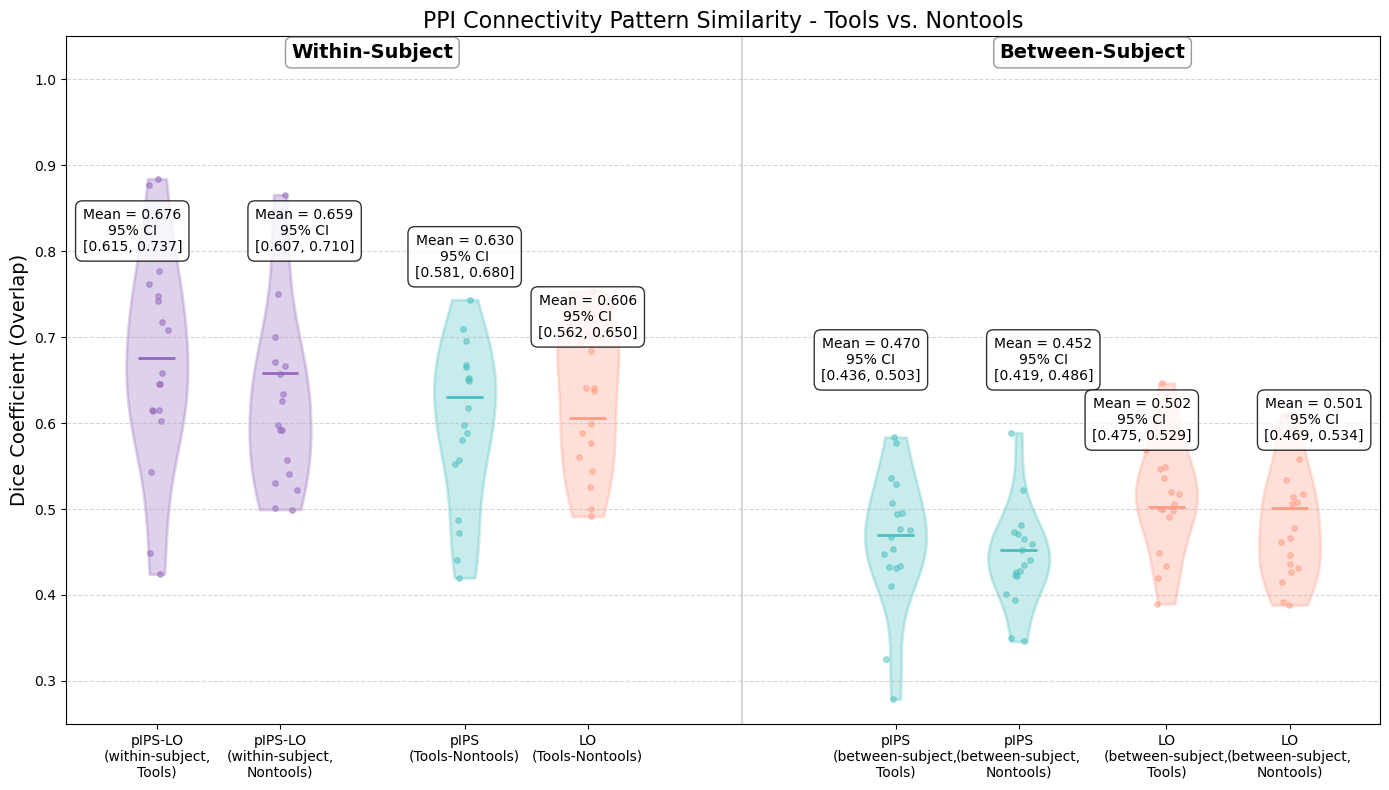


Key findings:
1. Within-Subject comparisons show high similarity in both between-region (0.67-0.66) and between-condition (0.63-0.61) analyses
2. Both pIPS and LO show substantial overlap between tools and nontools (0.63 and 0.61, p=0.34)
3. Between-Subject comparisons show lower similarity (0.45-0.50) than within-subject comparisons


In [3]:
# condition dice coefficient visual
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Define the data from your experiment 2 results
data = {
    'Comparison': [
        # GROUP 1A: Within-subject, between regions
        'pIPS-LO\n(within-subject,\nTools)', 
        'pIPS-LO\n(within-subject,\nNontools)',
        # GROUP 1B: Within-subject, between conditions
        'pIPS\n(Tools-Nontools)', 
        'LO\n(Tools-Nontools)',
        # GROUP 2: Between-subject, within-region
        'pIPS\n(between-subject,\nTools)', 
        'pIPS\n(between-subject,\nNontools)',
        'LO\n(between-subject,\nTools)', 
        'LO\n(between-subject,\nNontools)'
    ],
    'Dice': [
        # Within-subject data (means)
        0.6762, 0.6587,
        # Tools-Nontools overlap
        0.6302, 0.6061,
        # Between-subject data
        0.4697, 0.4521,
        0.5021, 0.5011
    ],
    'StdDev': [
        # Standard deviations
        0.1317, 0.1118,
        0.1073, 0.0959,
        0.0728, 0.0725,
        0.0586, 0.0702
    ],
    'Group': [
        # Grouping information - modified to two main groups
        'Within-Subject', 'Within-Subject',
        'Within-Subject', 'Within-Subject',
        'Between-Subject', 'Between-Subject',
        'Between-Subject', 'Between-Subject'
    ],
    'SubGroup': [
        # Subgrouping information
        'Between-Region', 'Between-Region',
        'Between-Condition', 'Between-Condition',
        'pIPS', 'pIPS',
        'LO', 'LO'
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Calculate 95% confidence intervals (mean ± 1.96*std/sqrt(n))
n = 18  # Number of subjects from your output
df['CI_Lower'] = df['Dice'] - 1.96 * df['StdDev'] / np.sqrt(n)
df['CI_Upper'] = df['Dice'] + 1.96 * df['StdDev'] / np.sqrt(n)

# Define colors with consistent shading
color_palette = {
    # Within-subject, between-region colors (purple)
    'pIPS-LO\n(within-subject,\nTools)': '#9467bd',
    'pIPS-LO\n(within-subject,\nNontools)': '#9467bd',
    
    # Within-subject, between-condition colors
    'pIPS\n(Tools-Nontools)': '#4ac0c0',  # Teal
    'LO\n(Tools-Nontools)': '#ff9b83',    # Peach
    
    # Between-subject colors
    'pIPS\n(between-subject,\nTools)': '#4ac0c0',      # Same teal
    'pIPS\n(between-subject,\nNontools)': '#4ac0c0',   # Same teal
    'LO\n(between-subject,\nTools)': '#ff9b83',        # Same peach
    'LO\n(between-subject,\nNontools)': '#ff9b83'      # Same peach
}

# Create better positioned layout with wider spacing between main groups
positions = [
    # Group 1A: Within-Subject, Between-Region
    0.8, 1.8,
    # Group 1B: Within-Subject, Between-Condition
    3.3, 4.3,
    # Group 2: Between-Subject
    6.8, 7.8, 9.0, 10.0
]

# Generate sample data for violin plots
np.random.seed(42)
simulated_data = {}
for i, comp in enumerate(df['Comparison']):
    mean = df.loc[i, 'Dice']
    std = df.loc[i, 'StdDev']
    # Generate samples from normal distribution bounded between 0 and 1
    samples = np.random.normal(mean, std, size=n)
    samples = np.clip(samples, 0, 1)  # Ensure values are between 0 and 1
    simulated_data[comp] = samples

# Create the DataFrame for the violin plot
violin_data = []
for comp, samples in simulated_data.items():
    for val in samples:
        violin_data.append({'Comparison': comp, 'Dice': val})
violin_df = pd.DataFrame(violin_data)

# Loop through each category to create custom violins
for i, comp in enumerate(df['Comparison']):
    # Get data for this comparison
    comp_data = violin_df[violin_df['Comparison'] == comp]['Dice']
    
    # Calculate violin data
    parts = ax.violinplot(comp_data, positions=[positions[i]], showmeans=False, 
                         showmedians=False, showextrema=False)
    
    # Set colors for this violin
    for pc in parts['bodies']:
        # Set the outline to the original color
        pc.set_edgecolor(color_palette[comp])
        # Set the fill to a transparent version
        rgb = plt.cm.colors.to_rgb(color_palette[comp])
        pc.set_facecolor((*rgb, 0.3))  # 30% opacity
        # Make the line thicker
        pc.set_linewidth(2)
    
    # Add jitter to x position to avoid overlapping points
    x_jitter = np.random.normal(0, 0.05, size=len(comp_data))
    plt.scatter(x=np.repeat(positions[i], len(comp_data)) + x_jitter, 
               y=comp_data, 
               color=color_palette[comp], alpha=0.5, s=15)
    
    # Add mean line with matching color
    plt.hlines(y=df.loc[i, 'Dice'], xmin=positions[i]-0.15, xmax=positions[i]+0.15, 
               color=color_palette[comp], linewidth=2)
    
    # Custom positions for text boxes to avoid overlap
    if comp == 'pIPS-LO\n(within-subject,\nTools)':
        y_pos = 0.8
        x_pos = positions[i] - 0.2
    elif comp == 'pIPS-LO\n(within-subject,\nNontools)':
        y_pos = 0.8
        x_pos = positions[i] + 0.2
    elif comp == 'pIPS\n(Tools-Nontools)':
        y_pos = 0.77
        x_pos = positions[i]
    elif comp == 'LO\n(Tools-Nontools)':
        y_pos = 0.70
        x_pos = positions[i]
    elif comp == 'pIPS\n(between-subject,\nTools)':
        y_pos = 0.65
        x_pos = positions[i] - 0.2
    elif comp == 'pIPS\n(between-subject,\nNontools)':
        y_pos = 0.65
        x_pos = positions[i] + 0.2
    elif comp == 'LO\n(between-subject,\nTools)':
        y_pos = 0.58
        x_pos = positions[i] - 0.2
    else:  # LO between-subject Nontools
        y_pos = 0.58
        x_pos = positions[i] + 0.2
    
    # Add text annotations with better positioning
    plt.text(x_pos, y_pos, f"Mean = {df.loc[i, 'Dice']:.3f}\n95% CI\n[{df.loc[i, 'CI_Lower']:.3f}, {df.loc[i, 'CI_Upper']:.3f}]",
            horizontalalignment='center',
            bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'))

# Set x-tick labels
plt.xticks(positions, df['Comparison'], rotation=0)

# Add only one divider between Within-Subject and Between-Subject sections
between_within_divider = (positions[3] + positions[4])/2
plt.axvline(x=between_within_divider, color='gray', linestyle='-', alpha=0.3)

# Add main group labels at the top
main_group_positions = {
    'Within-Subject': (positions[0] + positions[3]) / 2,
    'Between-Subject': (positions[4] + positions[7]) / 2
}

for group, pos in main_group_positions.items():
    plt.text(pos, 1.02, group, ha='center', va='bottom', fontsize=14, fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.3'))

# Customize the plot
plt.ylabel('Dice Coefficient (Overlap)', fontsize=14)
plt.title('PPI Connectivity Pattern Similarity - Tools vs. Nontools', fontsize=16)
plt.ylim([0.25, 1.05])  # Adjusted range to better show the data and group labels
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adjust layout - make sure x-axis labels are visible
plt.tight_layout()

# Show the plot
plt.show()

# Print the explanation separately
print("\nKey findings:")
print("1. Within-Subject comparisons show high similarity in both between-region (0.67-0.66) and between-condition (0.63-0.61) analyses")
print("2. Both pIPS and LO show substantial overlap between tools and nontools (0.63 and 0.61, p=0.34)")
print("3. Between-Subject comparisons show lower similarity (0.45-0.50) than within-subject comparisons")

### Fingerprint Connectivity

In [ ]:
# Merge Atlas for Experiment 2
import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import image, datasets, plotting
from nilearn.maskers import NiftiLabelsMasker
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Define paths - updated for Experiment 2
base_dir = '/user_data/csimmon2/git_repos/ptoc'
roi_dir = f'{base_dir}/roiParcels'
results_dir = f'{base_dir}/results/exp2'  # Updated for exp2
os.makedirs(results_dir, exist_ok=True)

def create_merged_atlas_exp2():
    """
    Create a merged atlas for Experiment 2 where Wang ROIs replace overlapping regions in Schaefer atlas
    """
    print("\n=== Step 1: Creating Merged Atlas for Experiment 2 ===")
    
    # Load Wang ROIs - pIPS and LO (use same ROIs or update if different for exp2)
    roi_files = {
        'pIPS': f'{roi_dir}/pIPS.nii.gz',
        'LO': f'{roi_dir}/LO.nii.gz'
    }
    
    rois = {}
    for roi_name, roi_path in roi_files.items():
        if os.path.exists(roi_path):
            rois[roi_name] = nib.load(roi_path)
            print(f"Loaded {roi_name} ROI for Experiment 2")
        else:
            print(f"Error: ROI file {roi_path} not found!")
            return None
    
    # Load Schaefer atlas
    atlas = datasets.fetch_atlas_schaefer_2018(n_rois=200, yeo_networks=7, resolution_mm=2)
    atlas_img = nib.load(atlas.maps)
    atlas_labels = atlas.labels
    print(f"Loaded Schaefer atlas with {len(atlas_labels)} parcels for Experiment 2")
    
    # Get atlas data
    atlas_data = atlas_img.get_fdata()
    modified_atlas_data = atlas_data.copy()
    
    # Create a dictionary to store new labels
    new_labels = list(atlas_labels)
    
    # Assign values for new ROIs (continuing from the end of the Schaefer atlas)
    roi_values = {'pIPS': 201, 'LO': 202}
    overlap_info = {}
    
    # Process each ROI
    for roi_name, roi_img in rois.items():
        # Get ROI data and create mask
        roi_data = roi_img.get_fdata()
        roi_mask = roi_data > 0
        
        # Find overlapping parcels
        overlap_mask = (atlas_data > 0) & roi_mask
        overlapping_labels = np.unique(atlas_data[overlap_mask])
        overlapping_labels = overlapping_labels[overlapping_labels > 0]
        
        # Get number of voxels in overlap
        overlap_voxels = {}
        for label in overlapping_labels:
            label_mask = (atlas_data == label) & roi_mask
            overlap_voxels[int(label)] = np.sum(label_mask)
        
        # Store overlap information
        overlap_info[roi_name] = {
            'overlapping_labels': overlapping_labels.tolist(),
            'overlap_voxels': overlap_voxels
        }
        
        print(f"{roi_name} overlaps with {len(overlapping_labels)} atlas parcels in Experiment 2")
        for label, voxels in overlap_voxels.items():
            label_idx = int(label) - 1  # Convert to 0-indexed
            if 0 <= label_idx < len(atlas_labels):
                label_name = atlas_labels[label_idx]
                label_name = label_name.decode('utf-8') if isinstance(label_name, bytes) else str(label_name)
                print(f"  Label {label} ({label_name}): {voxels} voxels")
        
        # Remove overlapping parcels from the atlas
        for label in overlapping_labels:
            label_mask = (modified_atlas_data == label) & roi_mask
            modified_atlas_data[label_mask] = 0
        
        # Add ROI with new label
        modified_atlas_data[roi_mask] = roi_values[roi_name]
        
        # Add new label name
        new_labels.append(f"Wang_{roi_name}")
    
    # Create the modified atlas
    modified_atlas_img = nib.Nifti1Image(modified_atlas_data, atlas_img.affine, atlas_img.header)
    merged_atlas_file = f'{results_dir}/schaefer_wang_merged_exp2.nii.gz'
    nib.save(modified_atlas_img, merged_atlas_file)
    print(f"Saved merged atlas for Experiment 2 to: {merged_atlas_file}")
    
    # Save new labels array
    np.save(f'{results_dir}/merged_atlas_labels_exp2.npy', new_labels)
    
    # Return atlas information
    return {
        'atlas_img': atlas_img,
        'merged_atlas_img': modified_atlas_img,
        'atlas_labels': atlas_labels,
        'merged_labels': new_labels,
        'roi_values': roi_values,
        'overlap_info': overlap_info
    }

# Run the full analysis
if __name__ == "__main__":
    create_merged_atlas_exp2()


=== Step 1: Creating Merged Atlas for Experiment 2 ===
Loaded pIPS ROI for Experiment 2
Loaded LO ROI for Experiment 2
Loaded Schaefer atlas with 200 parcels for Experiment 2
pIPS overlaps with 28 atlas parcels in Experiment 2
  Label 9 (7Networks_LH_Vis_9): 7 voxels
  Label 11 (7Networks_LH_Vis_11): 159 voxels
  Label 12 (7Networks_LH_Vis_12): 2 voxels
  Label 13 (7Networks_LH_Vis_13): 381 voxels
  Label 14 (7Networks_LH_Vis_14): 528 voxels
  Label 33 (7Networks_LH_DorsAttn_Post_3): 554 voxels
  Label 36 (7Networks_LH_DorsAttn_Post_6): 4 voxels
  Label 37 (7Networks_LH_DorsAttn_Post_7): 567 voxels
  Label 38 (7Networks_LH_DorsAttn_Post_8): 64 voxels
  Label 39 (7Networks_LH_DorsAttn_Post_9): 99 voxels
  Label 40 (7Networks_LH_DorsAttn_Post_10): 15 voxels
  Label 62 (7Networks_LH_Cont_Par_2): 269 voxels
  Label 71 (7Networks_LH_Cont_pCun_1): 247 voxels
  Label 80 (7Networks_LH_Default_Par_2): 436 voxels
  Label 82 (7Networks_LH_Default_Par_4): 85 voxels
  Label 99 (7Networks_LH_Defaul

In [30]:
# Regional Brain Connectivity Analysis Part 1 (Experiment 2): Analysis and CSV Export
# Description: Analysis of functional connectivity (FC) and psychophysiological interaction (PPI)
#              between parietal IPS and lateral occipital regions with CSV export
#              Updated for Experiment 2 with tool localizer data

import os
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
from sklearn.utils import resample

# Define study paths - updated for experiment 2
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
sub_info_path = '/user_data/csimmon2/git_repos/ptoc/sub_info_tool.csv'  # Updated for exp 2
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
output_dir = f'{results_dir}/exp2_connectivity_comparison'  # Updated for exp 2
os.makedirs(output_dir, exist_ok=True)

def analyze_connectivity_and_save_results(analysis_type='fc', condition='tools'):
    """Analyze connectivity and save results as CSV using merged atlas - updated for Experiment 2
    
    Parameters:
    -----------
    analysis_type : str
        Type of analysis to perform, either 'fc' or 'ppi'
    condition : str
        Condition to analyze, either 'tools' or 'nontools'
    """
    print(f"\n{'='*80}")
    print(f"ANALYZING {analysis_type.upper()} CONNECTIVITY FOR {condition.upper()} CONDITION AND SAVING RESULTS")
    print(f"{'='*80}")
    
    # Load merged atlas specifically created for experiment 2
    merged_atlas_file = f'{results_dir}/exp2/schaefer_wang_merged_exp2.nii.gz'  # Updated for exp 2
    merged_labels_file = f'{results_dir}/exp2/merged_atlas_labels_exp2.npy'  # Updated for exp 2
    
    if not os.path.exists(merged_atlas_file) or not os.path.exists(merged_labels_file):
        print("Error: Merged atlas files for Experiment 2 not found. Please run merge_atlas_exp2.py first.")
        return None
    
    atlas_img = nib.load(merged_atlas_file)
    atlas_labels = np.load(merged_labels_file, allow_pickle=True)
    
    print(f"Loaded merged atlas with {len(atlas_labels)} parcels for Experiment 2")
    
    # Load subject info for Experiment 2
    sub_info = pd.read_csv(sub_info_path)
    subjects = sub_info[sub_info['exp'] == 'spaceloc']['sub'].tolist()  # Updated for exp 2
        
    print(f"Found {len(subjects)} subjects for Experiment 2")
    
    # Define ROIs and hemispheres
    rois = ['pIPS', 'LO']
    hemispheres = ['left', 'right']
    
    # Setup atlas masker
    masker = NiftiLabelsMasker(labels_img=atlas_img, standardize=False)
    
    # Load and process subject data
    subject_data = []
    for sub in subjects:
        sub_conn = {}
        
        for roi in rois:
            # Initialize arrays to hold combined data
            combined_data = None
            hemi_count = 0
            
            for hemisphere in hemispheres:
                # Update file path for Experiment 2 based on condition
                if condition == 'tools':
                    # For tools condition - no condition in filename
                    fc_file = f'{study_dir}/{sub}/ses-01/derivatives/{analysis_type}/mni/{sub}_{roi}_{hemisphere}_ToolLoc_{analysis_type}_mni.nii.gz'
                else:  # nontools
                    # For nontools condition - include condition in filename
                    fc_file = f'{study_dir}/{sub}/ses-01/derivatives/{analysis_type}/mni/{sub}_{roi}_{hemisphere}_{condition}_ToolLoc_{analysis_type}_mni.nii.gz'
                
                if os.path.exists(fc_file):
                    try:
                        # Load the FC map
                        fc_img = nib.load(fc_file)
                        
                        # Extract ROI values using atlas
                        fc_values = masker.fit_transform(fc_img)[0]
                        
                        # Add to combined data
                        if combined_data is None:
                            combined_data = fc_values
                        else:
                            combined_data += fc_values
                        
                        hemi_count += 1
                    except Exception as e:
                        print(f"Error processing {fc_file}: {e}")
            
            # Average the data if we have at least one hemisphere
            if hemi_count > 0:
                sub_conn[roi] = combined_data / hemi_count
        
        # Only include subjects with both ROIs
        if len(sub_conn) == len(rois):
            subject_data.append(sub_conn)
    
    n_valid_subjects = len(subject_data)
    print(f"Successfully loaded data for {n_valid_subjects} subjects for {condition} condition")
    
    if n_valid_subjects < 3:
        print(f"Not enough valid subjects for {condition} condition. Analysis cannot proceed.")
        return None, None
    
    # Initialize arrays for analysis
    n_rois = len(atlas_labels)
    pips_fc = np.zeros((n_valid_subjects, n_rois))
    lo_fc = np.zeros((n_valid_subjects, n_rois))
    
    # Fill arrays with connectivity data
    for i, subj_data in enumerate(subject_data):
        pips_fc[i, :] = subj_data['pIPS']
        lo_fc[i, :] = subj_data['LO']
    
    # Calculate connectivity vector correlation for each subject
    vector_correlations = np.zeros(n_valid_subjects)
    for i in range(n_valid_subjects):
        vector_correlations[i] = np.corrcoef(pips_fc[i, :], lo_fc[i, :])[0, 1]
    
    print(f"Mean connectivity vector correlation for {condition}: {np.mean(vector_correlations):.3f} ± {np.std(vector_correlations):.3f}")
    
    # Calculate mean connectivity profiles
    mean_pips = np.mean(pips_fc, axis=0)
    mean_lo = np.mean(lo_fc, axis=0)
    
    # Remove self-connectivity
    # Get indices for Wang ROIs in the merged atlas
    wang_pips_idx = next((i for i, label in enumerate(atlas_labels) if 'Wang_pIPS' in str(label)), None)
    wang_lo_idx = next((i for i, label in enumerate(atlas_labels) if 'Wang_LO' in str(label)), None)
    
    # Print which indices are being excluded
    if wang_pips_idx is not None:
        print(f"Excluding Wang_pIPS (index {wang_pips_idx}) from connectivity analysis")
    if wang_lo_idx is not None:
        print(f"Excluding Wang_LO (index {wang_lo_idx}) from connectivity analysis")
    
    # Create mask for non-self connections (all True except at Wang ROI indices)
    mask = np.ones(len(atlas_labels), dtype=bool)
    if wang_pips_idx is not None:
        mask[wang_pips_idx] = False
    if wang_lo_idx is not None:
        mask[wang_lo_idx] = False
    
    # Apply mask to connectivity data
    pips_fc_masked = pips_fc[:, mask]
    lo_fc_masked = lo_fc[:, mask]
    
    # Get the masked atlas labels
    atlas_labels_masked = [label for i, label in enumerate(atlas_labels) if mask[i]]
    
    # Update mean connectivity with masked data
    mean_pips_masked = np.mean(pips_fc_masked, axis=0)
    mean_lo_masked = np.mean(lo_fc_masked, axis=0)
    
    # Get the new number of ROIs after masking
    n_masked_rois = np.sum(mask)
    print(f"Analyzing {n_masked_rois} ROIs after excluding Wang ROIs")
    
    # Calculate difference profile with masked data
    diff_profile = mean_pips_masked - mean_lo_masked
    abs_diff_profile = np.abs(diff_profile)
    
    # Run bootstrap analysis with masked data
    print("Performing bootstrap analysis...")
    n_boots = 10000
    boot_diffs = np.zeros((n_boots, n_masked_rois))
    
    for i in range(n_boots):
        # Resample subjects with replacement
        boot_idx = resample(range(n_valid_subjects), replace=True, n_samples=n_valid_subjects)
        
        # Calculate mean difference for this bootstrap sample
        boot_pips = np.mean(pips_fc_masked[boot_idx, :], axis=0)
        boot_lo = np.mean(lo_fc_masked[boot_idx, :], axis=0)
        boot_diffs[i, :] = boot_pips - boot_lo
    
    # Calculate confidence intervals
    ci_lower = np.percentile(boot_diffs, 2.5, axis=0)
    ci_upper = np.percentile(boot_diffs, 97.5, axis=0)
    
    # Identify significant differences (95% CI doesn't cross zero)
    sig_boot = (ci_lower > 0) | (ci_upper < 0)
    sig_boot_count = np.sum(sig_boot)
    print(f"Found {sig_boot_count} ROIs with significant differences via bootstrap for {condition} condition")
    
    # Leave-One-Out Cross-Validation for reliability
    print("Performing Leave-One-Out Cross-Validation...")
    loo_reliability = np.zeros(n_masked_rois)
    
    for left_out in range(n_valid_subjects):
        # Create the training set (all subjects except the left out one)
        train_idx = list(range(n_valid_subjects))
        train_idx.remove(left_out)
        
        # Calculate mean training differences
        train_diff = np.mean(pips_fc_masked[train_idx, :] - lo_fc_masked[train_idx, :], axis=0)
        
        # Test on left out subject
        test_diff = pips_fc_masked[left_out, :] - lo_fc_masked[left_out, :]
        
        # Calculate consistency of signs between training and test
        loo_reliability += (np.sign(train_diff) == np.sign(test_diff)).astype(float)
    
    # Convert to proportion of consistent predictions
    loo_reliability = loo_reliability / n_valid_subjects
    
    # Set threshold at 75% consistency
    loo_threshold = 0.75
    sig_loo = loo_reliability >= loo_threshold
    sig_loo_count = np.sum(sig_loo)
    
    print(f"LOO reliability threshold: {loo_threshold:.3f}")
    print(f"Found {sig_loo_count} ROIs with high reliability via LOO for {condition} condition")
    
    # Combine significance
    sig_combined = sig_boot & sig_loo
    sig_combined_count = np.sum(sig_combined)
    print(f"Found {sig_combined_count} ROIs significant with combined criteria for {condition} condition")
    
    # Helper function to get ROI name
    def get_roi_name(roi_id):
        try:
            idx = int(roi_id) - 1
            if 0 <= idx < len(atlas_labels):
                label = atlas_labels[idx]
                if isinstance(label, bytes):
                    label = label.decode('utf-8')
                return label
        except:
            pass
        return f"ROI_{roi_id}"
    
    # Create a map from masked indices to original atlas indices
    original_indices = np.where(mask)[0]
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'ROI_ID': original_indices + 1,  # Convert to 1-based indexing
        'ROI_Name': [get_roi_name(i+1) for i in original_indices],
        'pIPS_Connectivity': mean_pips_masked,
        'LO_Connectivity': mean_lo_masked,
        'Difference': diff_profile,
        'Abs_Difference': abs_diff_profile,
        'CI_Lower': ci_lower,
        'CI_Upper': ci_upper,
        'LOO_Reliability': loo_reliability,
        'Bootstrap_Significant': sig_boot,
        'LOO_Significant': sig_loo,
        'Combined_Significant': sig_combined,
        'Direction': np.where(diff_profile > 0, 'pIPS > LO', 'LO > pIPS'),
        'Condition': condition,  # Add condition to dataframe
        'Analysis_Type': analysis_type  # Add analysis type to dataframe
    })
    
    # Save results to CSV
    csv_path = f'{output_dir}/bilateral_{analysis_type}_{condition}_connectivity_fingerprint_results.csv'
    results_df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")
    
    # Create roi_data dictionary for visualization
    roi_data = {
        'mean_pips': mean_pips_masked,
        'mean_lo': mean_lo_masked,
        'diff_profile': diff_profile,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'sig_combined': sig_combined,
        'condition': condition
    }
    
    return results_df, roi_data

def compare_conditions(fc_tools_data, fc_nontools_data, ppi_tools_data, ppi_nontools_data):
    """Compare tools vs nontools conditions for both FC and PPI data"""
    print("\n" + "="*80)
    print("COMPARING TOOLS VS NONTOOLS CONDITIONS")
    print("="*80)
    
    if fc_tools_data is None or fc_nontools_data is None:
        print("Missing FC data for one or both conditions. Cannot compare.")
    else:
        # Compare tools vs nontools FC data
        print("\nComparing Tools vs Nontools for FC data:")
        
        # Calculate difference in connectivity profiles
        fc_pips_diff = fc_tools_data['mean_pips'] - fc_nontools_data['mean_pips']
        fc_lo_diff = fc_tools_data['mean_lo'] - fc_nontools_data['mean_lo']
        
        print(f"pIPS: Mean absolute difference between tools and nontools: {np.mean(np.abs(fc_pips_diff)):.4f}")
        print(f"LO: Mean absolute difference between tools and nontools: {np.mean(np.abs(fc_lo_diff)):.4f}")
        
        # Count ROIs with different significance
        sig_tools = fc_tools_data['sig_combined']
        sig_nontools = fc_nontools_data['sig_combined']
        
        both_sig = np.sum(sig_tools & sig_nontools)
        tools_only_sig = np.sum(sig_tools & ~sig_nontools)
        nontools_only_sig = np.sum(~sig_tools & sig_nontools)
        
        print(f"ROIs significant in both conditions: {both_sig}")
        print(f"ROIs significant in tools only: {tools_only_sig}")
        print(f"ROIs significant in nontools only: {nontools_only_sig}")
    
    if ppi_tools_data is None or ppi_nontools_data is None:
        print("Missing PPI data for one or both conditions. Cannot compare.")
    else:
        # Compare tools vs nontools PPI data
        print("\nComparing Tools vs Nontools for PPI data:")
        
        # Calculate difference in connectivity profiles
        ppi_pips_diff = ppi_tools_data['mean_pips'] - ppi_nontools_data['mean_pips']
        ppi_lo_diff = ppi_tools_data['mean_lo'] - ppi_nontools_data['mean_lo']
        
        print(f"pIPS: Mean absolute difference between tools and nontools: {np.mean(np.abs(ppi_pips_diff)):.4f}")
        print(f"LO: Mean absolute difference between tools and nontools: {np.mean(np.abs(ppi_lo_diff)):.4f}")
        
        # Count ROIs with different significance
        sig_tools = ppi_tools_data['sig_combined']
        sig_nontools = ppi_nontools_data['sig_combined']
        
        both_sig = np.sum(sig_tools & sig_nontools)
        tools_only_sig = np.sum(sig_tools & ~sig_nontools)
        nontools_only_sig = np.sum(~sig_tools & sig_nontools)
        
        print(f"ROIs significant in both conditions: {both_sig}")
        print(f"ROIs significant in tools only: {tools_only_sig}")
        print(f"ROIs significant in nontools only: {nontools_only_sig}")
    
    # Save comparison results
    comparison_results = {
        'fc_comparison': {
            'pips_diff': fc_pips_diff if fc_tools_data is not None and fc_nontools_data is not None else None,
            'lo_diff': fc_lo_diff if fc_tools_data is not None and fc_nontools_data is not None else None,
            'both_sig': both_sig if fc_tools_data is not None and fc_nontools_data is not None else 0,
            'tools_only_sig': tools_only_sig if fc_tools_data is not None and fc_nontools_data is not None else 0,
            'nontools_only_sig': nontools_only_sig if fc_tools_data is not None and fc_nontools_data is not None else 0
        },
        'ppi_comparison': {
            'pips_diff': ppi_pips_diff if ppi_tools_data is not None and ppi_nontools_data is not None else None,
            'lo_diff': ppi_lo_diff if ppi_tools_data is not None and ppi_nontools_data is not None else None,
            'both_sig': both_sig if ppi_tools_data is not None and ppi_nontools_data is not None else 0,
            'tools_only_sig': tools_only_sig if ppi_tools_data is not None and ppi_nontools_data is not None else 0,
            'nontools_only_sig': nontools_only_sig if ppi_tools_data is not None and ppi_nontools_data is not None else 0
        }
    }
    
    return comparison_results

# Run analyses for both FC and PPI, for both tools and nontools conditions
print("\nRunning FC and PPI analyses for both conditions in Experiment 2 and saving results...")

print("\n----- FC ANALYSIS - TOOLS CONDITION -----")
fc_tools_results, fc_tools_data = analyze_connectivity_and_save_results(analysis_type='fc', condition='tools')

print("\n----- FC ANALYSIS - NONTOOLS CONDITION -----")
fc_nontools_results, fc_nontools_data = analyze_connectivity_and_save_results(analysis_type='fc', condition='nontools')

print("\n----- PPI ANALYSIS - TOOLS CONDITION -----")
ppi_tools_results, ppi_tools_data = analyze_connectivity_and_save_results(analysis_type='ppi', condition='tools')

print("\n----- PPI ANALYSIS - NONTOOLS CONDITION -----")
ppi_nontools_results, ppi_nontools_data = analyze_connectivity_and_save_results(analysis_type='ppi', condition='nontools')

# Compare tools vs nontools conditions
comparison_results = compare_conditions(fc_tools_data, fc_nontools_data, ppi_tools_data, ppi_nontools_data)

# Combine all results into one dataframe for easy comparison
all_results = []
if fc_tools_results is not None:
    all_results.append(fc_tools_results)
if fc_nontools_results is not None:
    all_results.append(fc_nontools_results)
if ppi_tools_results is not None:
    all_results.append(ppi_tools_results)
if ppi_nontools_results is not None:
    all_results.append(ppi_nontools_results)

if all_results:
    combined_df = pd.concat(all_results, ignore_index=True)
    combined_path = f'{output_dir}/combined_connectivity_fingerprint_results.csv'
    combined_df.to_csv(combined_path, index=False)
    print(f"\nCombined results from all analyses saved to {combined_path}")

print("\nAnalyses complete - results were saved to disk.")


Running FC and PPI analyses for both conditions in Experiment 2 and saving results...

----- FC ANALYSIS - TOOLS CONDITION -----

ANALYZING FC CONNECTIVITY FOR TOOLS CONDITION AND SAVING RESULTS
Loaded merged atlas with 202 parcels for Experiment 2
Found 18 subjects for Experiment 2
Successfully loaded data for 18 subjects for tools condition
Mean connectivity vector correlation for tools: 0.717 ± 0.196
Excluding Wang_pIPS (index 200) from connectivity analysis
Excluding Wang_LO (index 201) from connectivity analysis
Analyzing 200 ROIs after excluding Wang ROIs
Performing bootstrap analysis...
Found 119 ROIs with significant differences via bootstrap for tools condition
Performing Leave-One-Out Cross-Validation...
LOO reliability threshold: 0.750
Found 94 ROIs with high reliability via LOO for tools condition
Found 92 ROIs significant with combined criteria for tools condition
Results saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/bilateral_fc_tools_c


Creating brain connectivity visualizations from saved CSV data for Experiment 2...

CREATING FC BRAIN CONNECTIVITY FIGURE FOR TOOLS CONDITION (EXPERIMENT 2)
Loaded merged atlas with 202 regions
Loaded FC data for tools condition with 200 ROIs
Found 92 significant ROIs for tools condition

Creating brain connectivity visualization for tools condition (Experiment 2)...


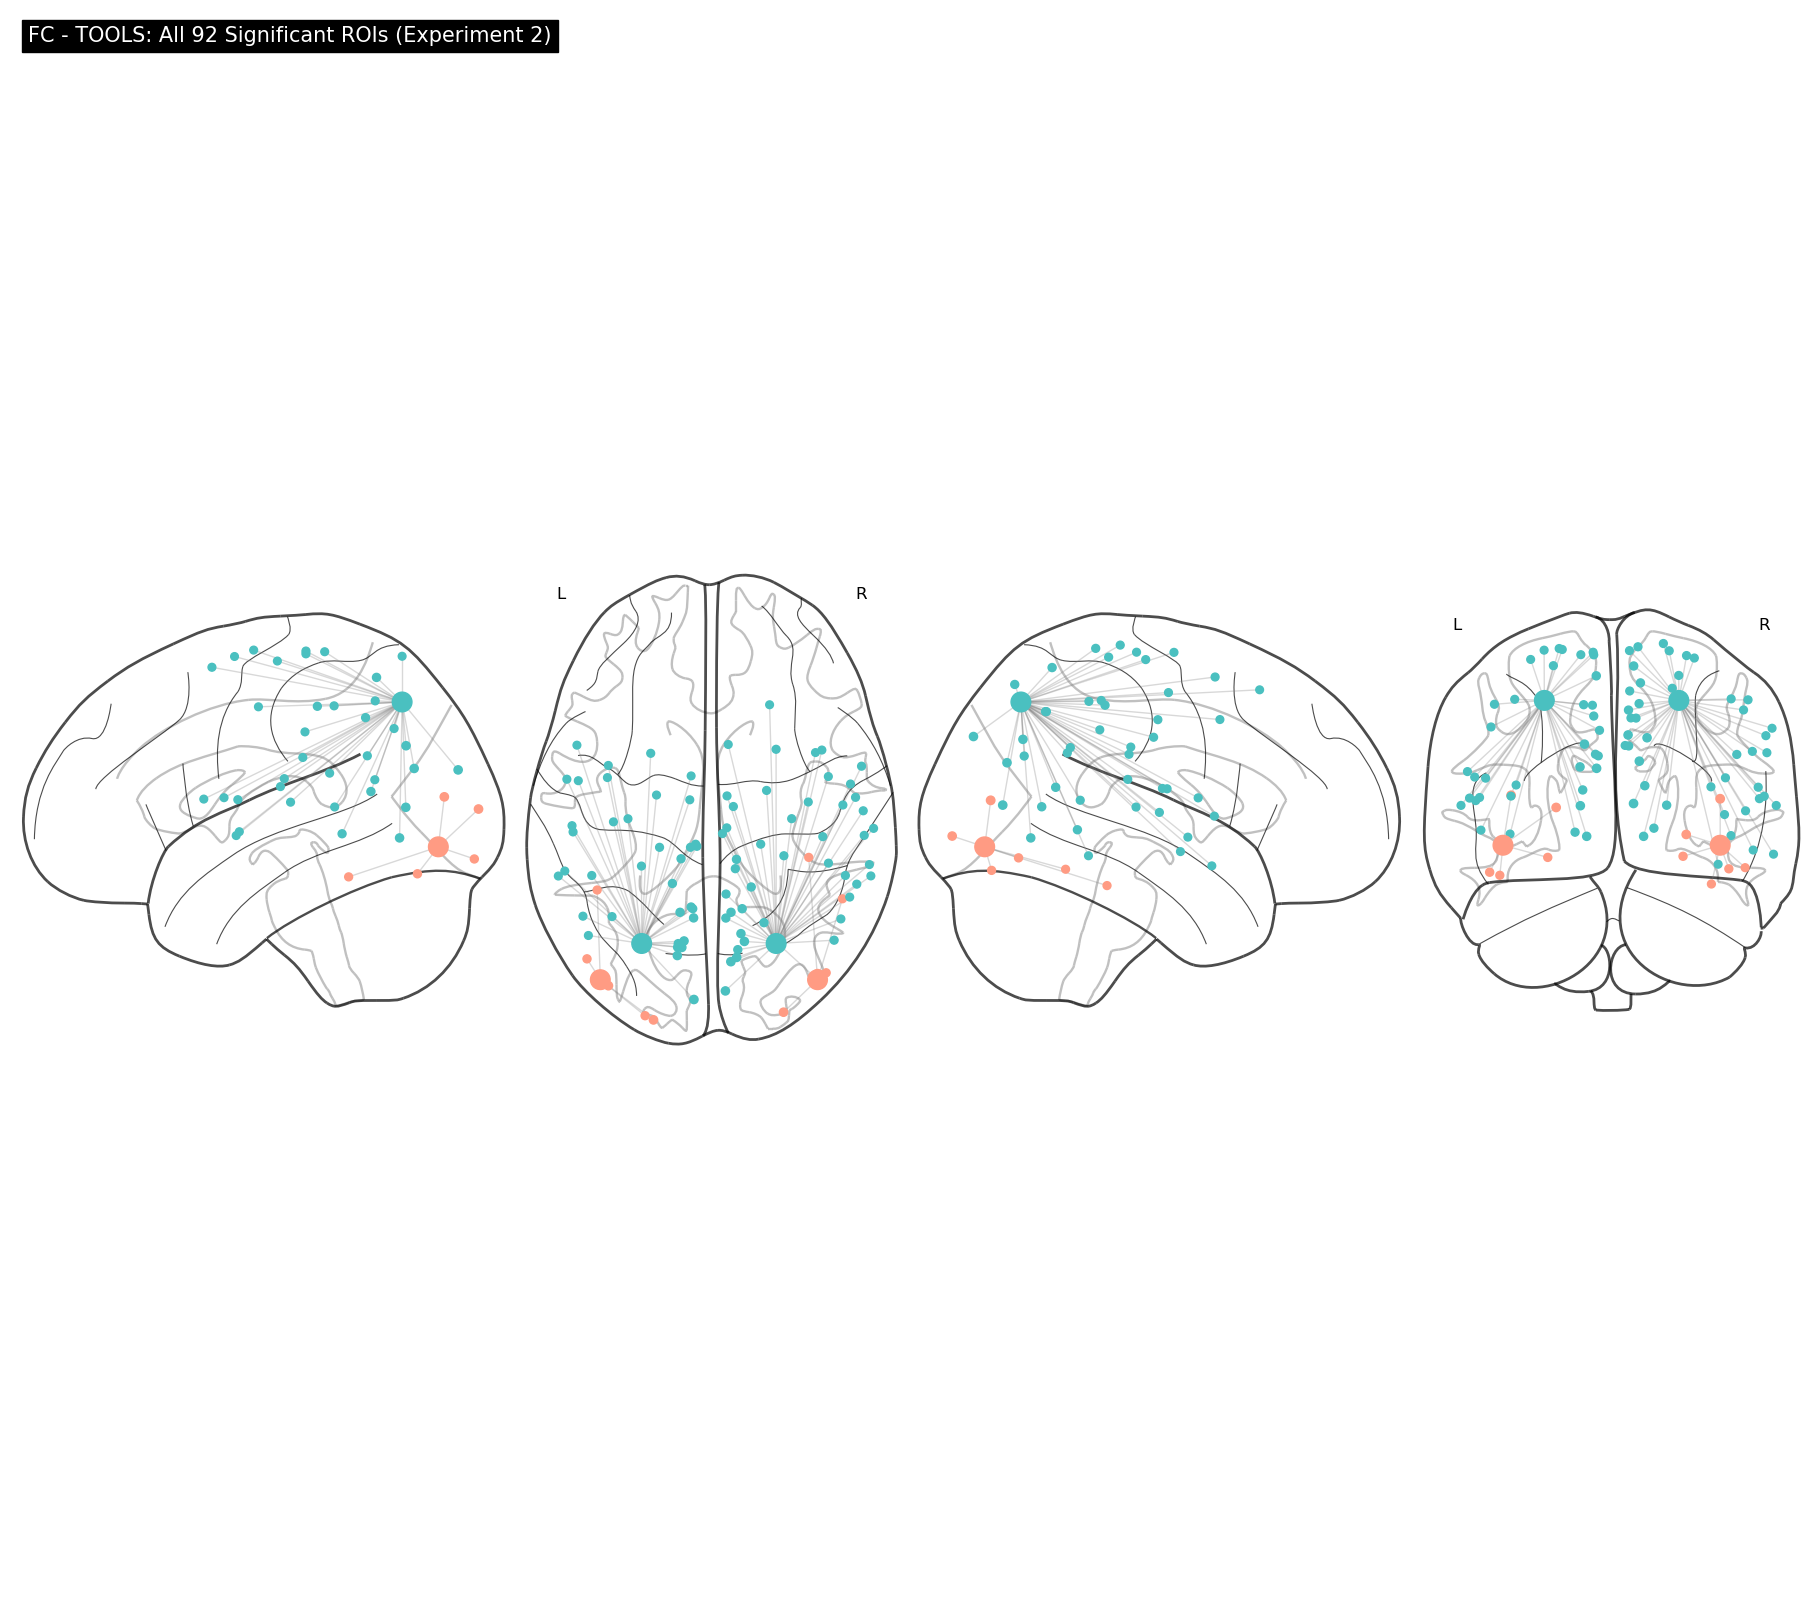

Brain network visualization complete for fc - tools (Experiment 2)
Showing 92 significant ROIs connected to pIPS and LO seed regions
Figure saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/fc_tools_brain_connectivity_exp2.png

CREATING FC BRAIN CONNECTIVITY FIGURE FOR NONTOOLS CONDITION (EXPERIMENT 2)
Loaded merged atlas with 202 regions
Loaded FC data for nontools condition with 200 ROIs
Found 116 significant ROIs for nontools condition

Creating brain connectivity visualization for nontools condition (Experiment 2)...


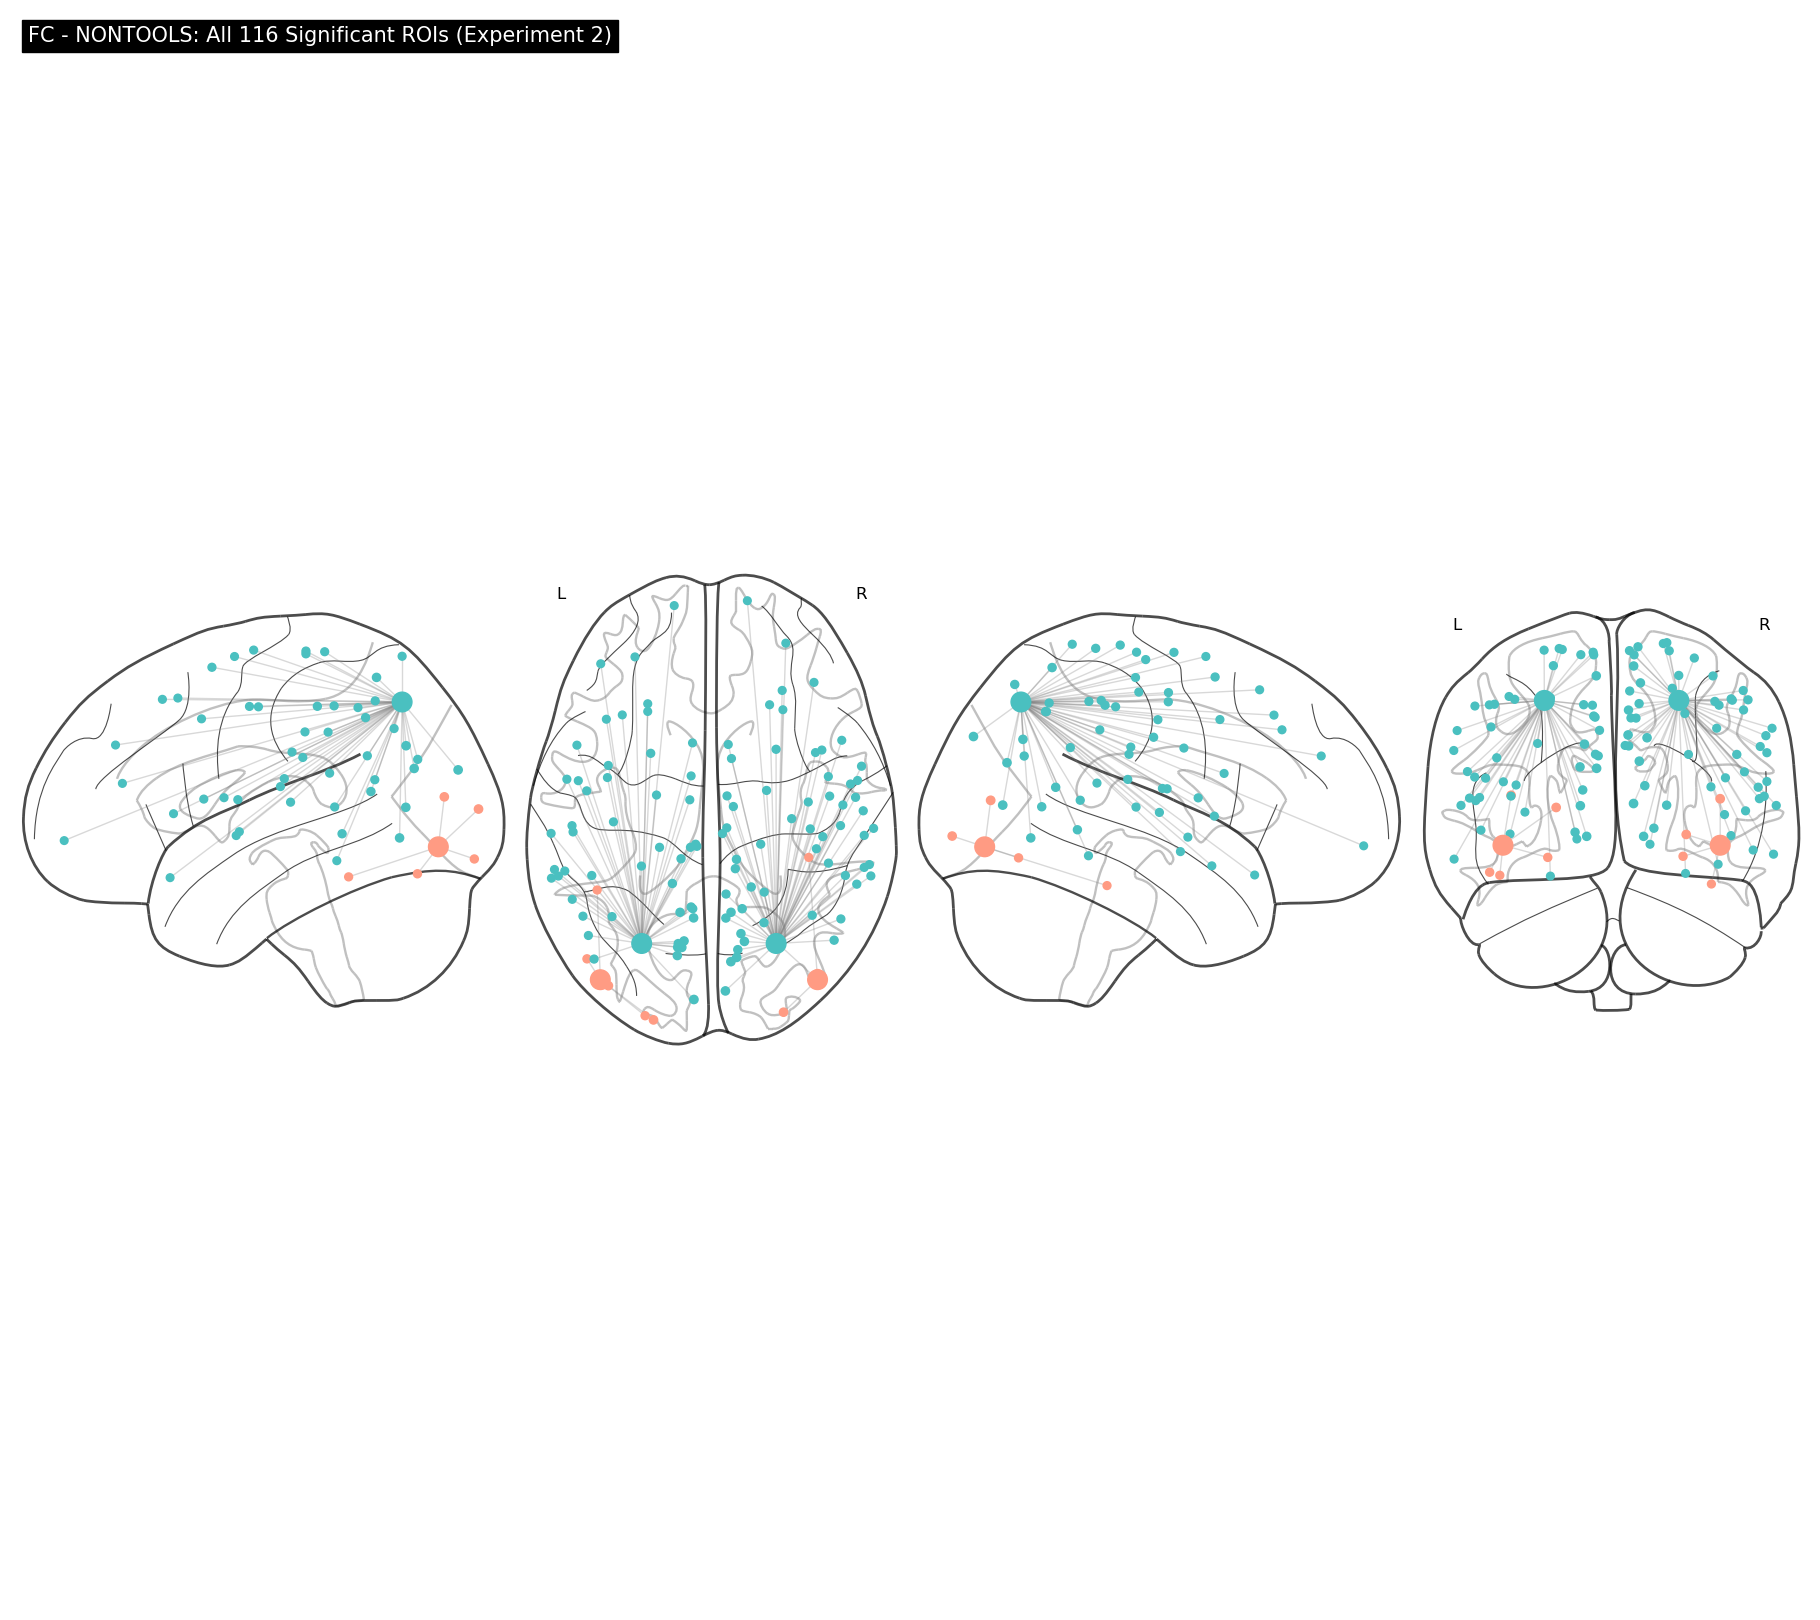

Brain network visualization complete for fc - nontools (Experiment 2)
Showing 116 significant ROIs connected to pIPS and LO seed regions
Figure saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/fc_nontools_brain_connectivity_exp2.png

CREATING PPI BRAIN CONNECTIVITY FIGURE FOR TOOLS CONDITION (EXPERIMENT 2)
Loaded merged atlas with 202 regions
Loaded PPI data for tools condition with 200 ROIs
Found 34 significant ROIs for tools condition

Creating brain connectivity visualization for tools condition (Experiment 2)...


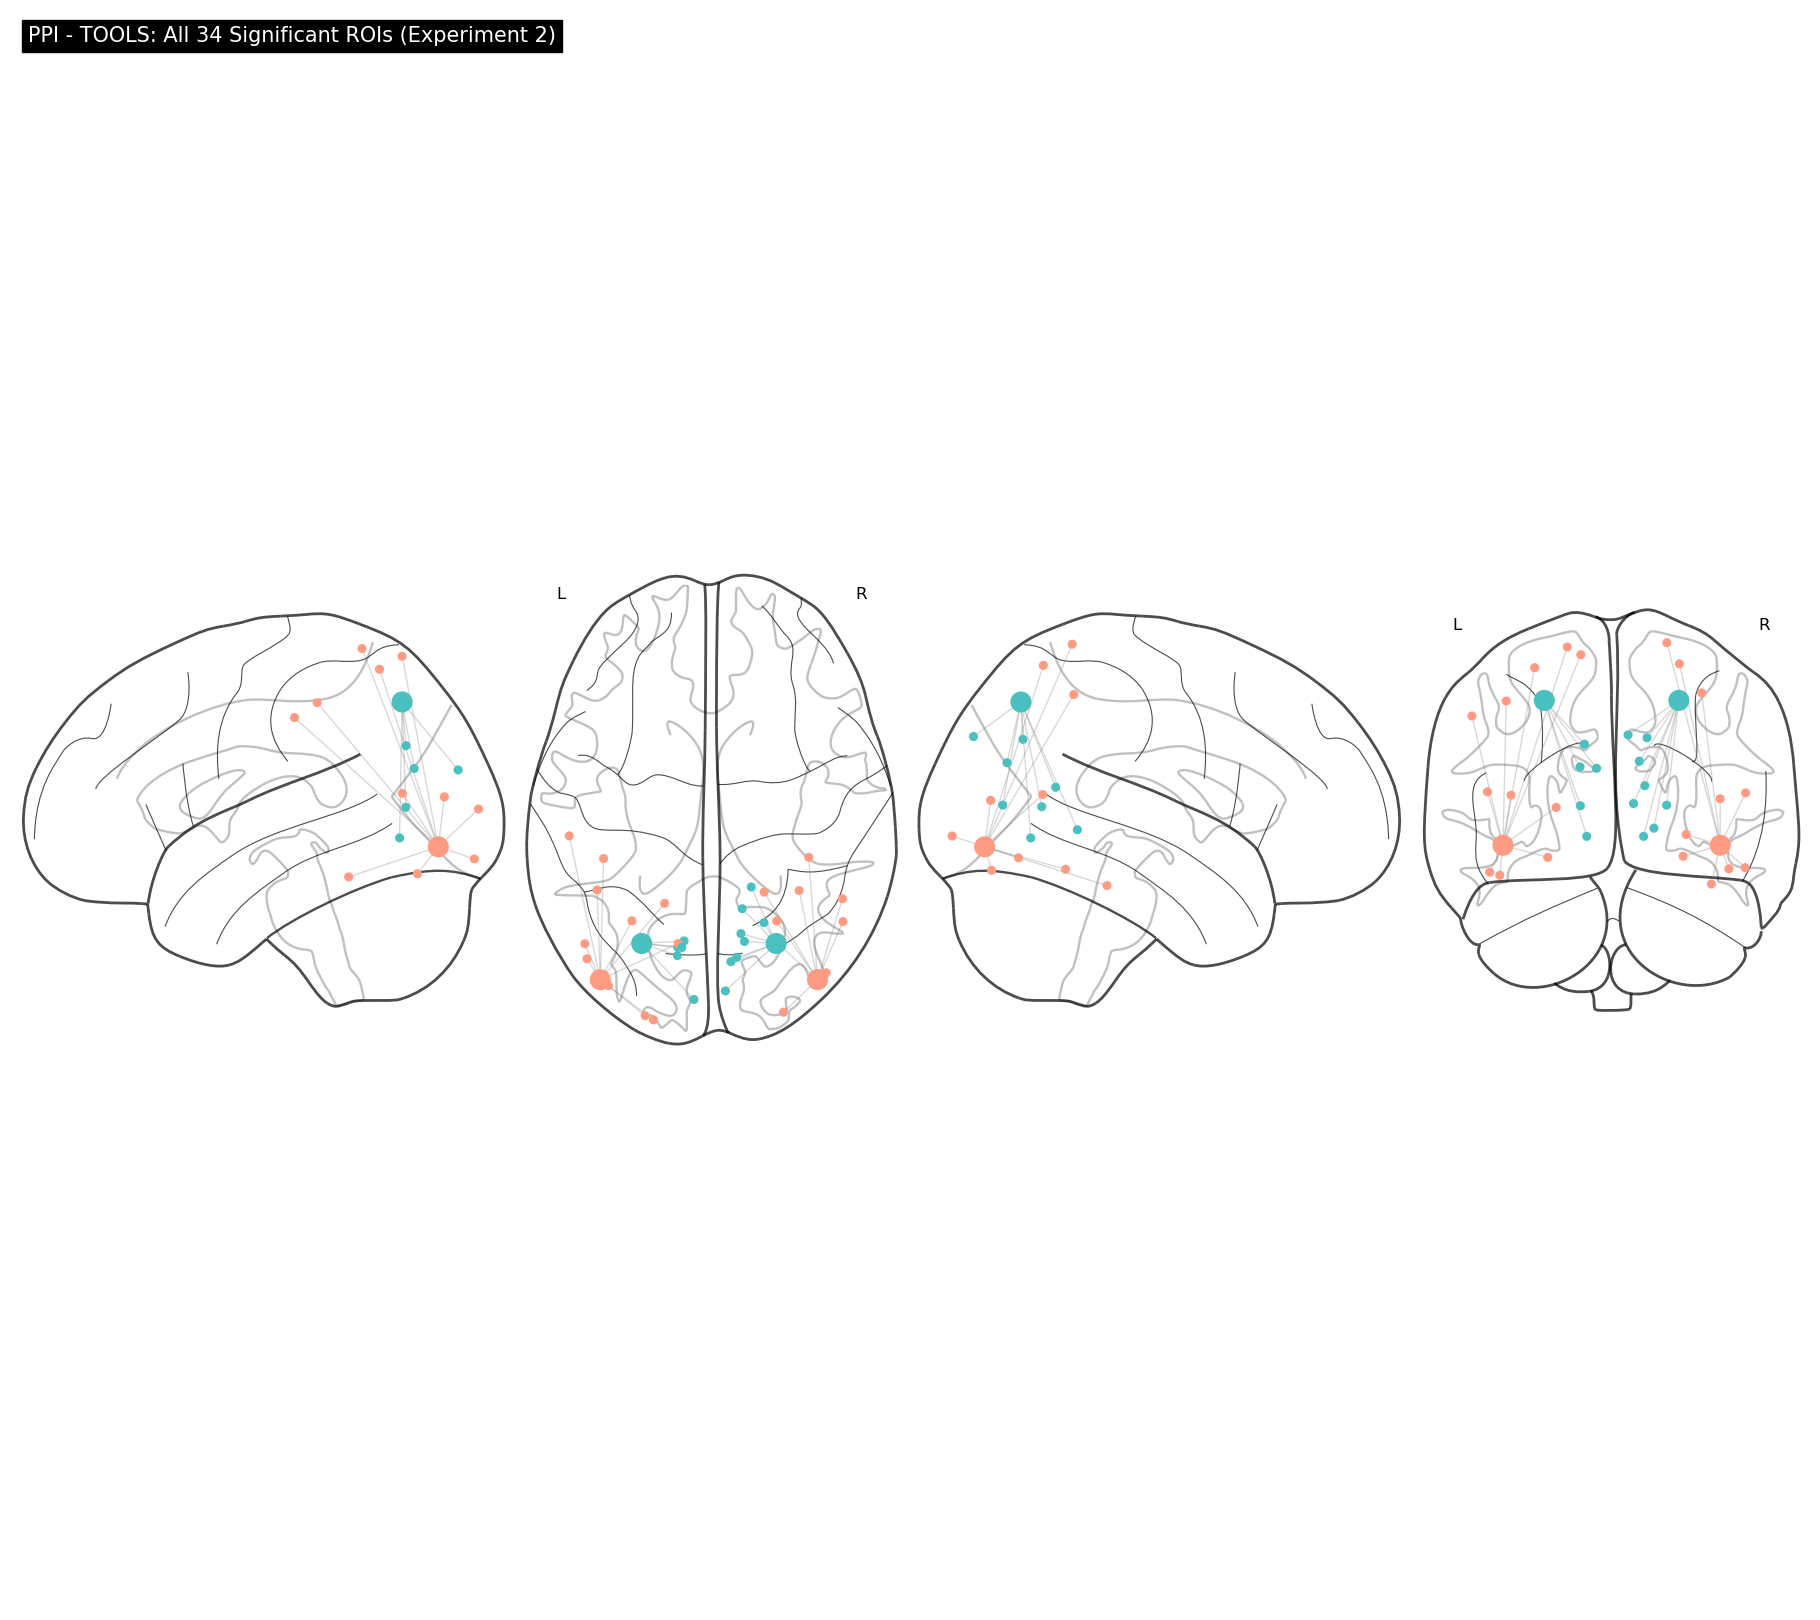

Brain network visualization complete for ppi - tools (Experiment 2)
Showing 34 significant ROIs connected to pIPS and LO seed regions
Figure saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/ppi_tools_brain_connectivity_exp2.png

CREATING PPI BRAIN CONNECTIVITY FIGURE FOR NONTOOLS CONDITION (EXPERIMENT 2)
Loaded merged atlas with 202 regions
Loaded PPI data for nontools condition with 200 ROIs
Found 28 significant ROIs for nontools condition

Creating brain connectivity visualization for nontools condition (Experiment 2)...


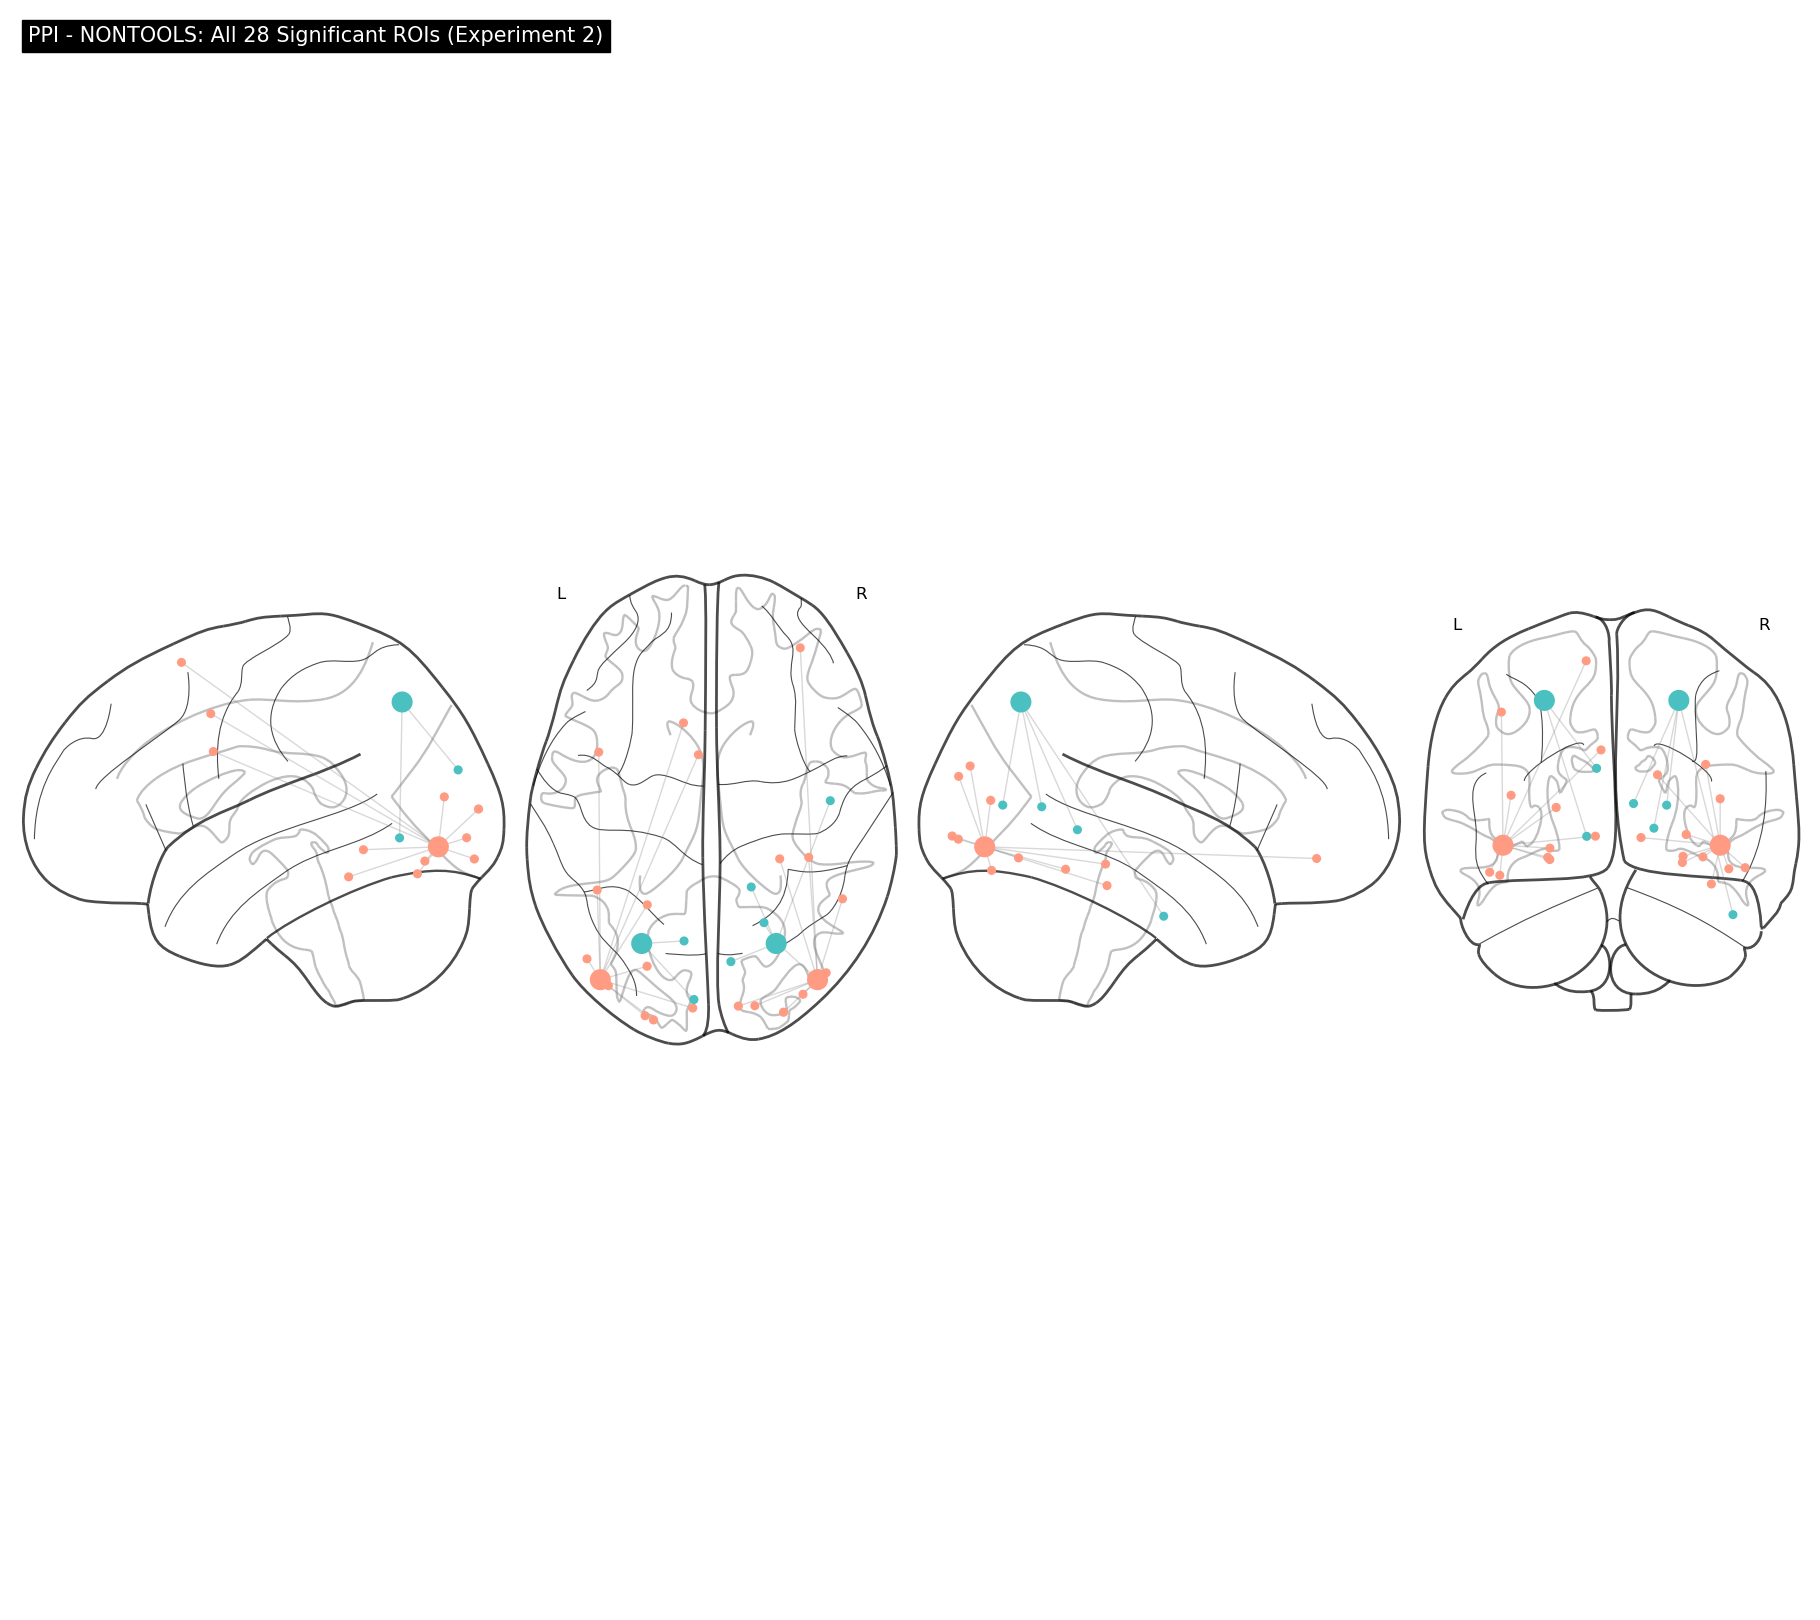

Brain network visualization complete for ppi - nontools (Experiment 2)
Showing 28 significant ROIs connected to pIPS and LO seed regions
Figure saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/ppi_nontools_brain_connectivity_exp2.png

Visualizations complete - figures were saved to disk.


In [ ]:
# FC + PPI Brain Connectivity Figures for Experiment 2 using saved CSV data and merged atlas
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nilearn import plotting
import nibabel as nib

# Define paths - updated for experiment 2
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
connectivity_dir = f'{results_dir}/exp2_connectivity_comparison'  # Updated for exp 2

def visualize_brain_connectivity(analysis_type='fc', condition='tools'):
    """Create brain visualization for specified data type and condition for Experiment 2"""
    print(f"\n{'='*80}")
    print(f"CREATING {analysis_type.upper()} BRAIN CONNECTIVITY FIGURE FOR {condition.upper()} CONDITION (EXPERIMENT 2)")
    print(f"{'='*80}")
    
    # Load merged atlas created for experiment 2
    merged_atlas_file = f'{results_dir}/exp2/schaefer_wang_merged_exp2.nii.gz'
    merged_labels_file = f'{results_dir}/exp2/merged_atlas_labels_exp2.npy'
    
    if not os.path.exists(merged_atlas_file) or not os.path.exists(merged_labels_file):
        print("Error: Merged atlas files for Experiment 2 not found. Please run merge_atlas_exp2.py first.")
        return None
    
    # Load merged atlas
    atlas_img = nib.load(merged_atlas_file)
    atlas_labels = np.load(merged_labels_file, allow_pickle=True)
    print(f"Loaded merged atlas with {len(atlas_labels)} regions")
    
    # Load saved connectivity results for experiment 2 - updated to include condition
    csv_path = f'{connectivity_dir}/bilateral_{analysis_type}_{condition}_connectivity_fingerprint_results.csv'
    if not os.path.exists(csv_path):
        print(f"Error: Could not find {analysis_type.upper()} {condition} results at {csv_path}")
        return None
    
    # Load the data
    results_df = pd.read_csv(csv_path)
    print(f"Loaded {analysis_type.upper()} data for {condition} condition with {len(results_df)} ROIs")
    
    # Filter to significant regions according to the combined criteria
    sig_df = results_df[results_df['Combined_Significant'] == True].copy()
    sig_df['Hemisphere'] = sig_df['ROI_Name'].apply(lambda x: 'L' if 'LH' in x else 'R' if 'RH' in x else 'X')
    
    print(f"Found {len(sig_df)} significant ROIs for {condition} condition")
    
    # ==================================
    # BRAIN NETWORK VISUALIZATION
    # ==================================
    print(f"\nCreating brain connectivity visualization for {condition} condition (Experiment 2)...")
    
    if len(sig_df) > 0:
        # Get coordinates for all ROIs from the merged atlas
        all_coords = plotting.find_parcellation_cut_coords(atlas_img)
        
        # Prepare node properties for significant ROIs
        sig_coords = []
        sig_colors = []
        sig_sizes = []
        sig_labels = []
        
        for _, row in sig_df.iterrows():
            roi_idx = row['ROI_ID'] - 1  # Convert to 0-based index
            sig_coords.append(all_coords[roi_idx])
            sig_colors.append('#4ac0c0' if row['Difference'] > 0 else '#ff9b83')
            sig_sizes.append(abs(row['Difference']) * 40 + 30)
            sig_labels.append(f"{row['ROI_ID']}\n{row['ROI_Name'].split('_')[-1]}")
        
        # Add seed nodes
        seed_coords = [
            [-26, -68, 48], [26, -68, 48],  # pIPS L/R
            [-42, -82, -8], [42, -82, -8]    # LO L/R
        ]
        all_coords = sig_coords + seed_coords
        all_colors = sig_colors + ['#4ac0c0', '#4ac0c0', '#ff9b83', '#ff9b83']
        all_sizes = sig_sizes + [200, 200, 200, 200]
        
        # Create adjacency matrix
        adjacency = np.zeros((len(all_coords), len(all_coords)))
        for i, row in enumerate(sig_df.itertuples()):
            tgt_offset = 0 if row.Difference > 0 else 2
            tgt_idx = len(sig_coords) + tgt_offset + (0 if row.Hemisphere == 'L' else 1)
            adjacency[i, tgt_idx] = adjacency[tgt_idx, i] = 1
        
        # Create network plot
        fig = plt.figure(figsize=(18, 16))
        plotting.plot_connectome(
            adjacency, all_coords,
            node_color=all_colors,
            node_size=all_sizes,
            edge_kwargs={'color': 'gray', 'alpha': 0.3, 'linewidth': 1.0},
            display_mode='lzry',
            title=f'{analysis_type.upper()} - {condition.upper()}: All {len(sig_df)} Significant ROIs (Experiment 2)',
            figure=fig
        )
        
        # Save the figure
        output_path = f'{connectivity_dir}/{analysis_type}_{condition}_brain_connectivity_exp2.png'
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"Brain network visualization complete for {analysis_type} - {condition} (Experiment 2)")
        print(f"Showing {len(sig_df)} significant ROIs connected to pIPS and LO seed regions")
        print(f"Figure saved to {output_path}")
    else:
        print(f"No significant ROIs found for {analysis_type} - {condition}. Cannot create brain visualization.")
    
    return sig_df

# Run visualizations for all combinations of FC/PPI and Tools/Nontools for Experiment 2
print("\nCreating brain connectivity visualizations from saved CSV data for Experiment 2...")
fc_tools_results = visualize_brain_connectivity(analysis_type='fc', condition='tools')
fc_nontools_results = visualize_brain_connectivity(analysis_type='fc', condition='nontools')
ppi_tools_results = visualize_brain_connectivity(analysis_type='ppi', condition='tools')
ppi_nontools_results = visualize_brain_connectivity(analysis_type='ppi', condition='nontools')

print("\nVisualizations complete - figures were saved to disk.")


Creating anatomical organization visualizations for Experiment 2 (tools and nontools conditions)...
Loaded merged atlas labels for Experiment 2 with 202 regions
Loaded FC tools condition results from /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/bilateral_fc_tools_connectivity_fingerprint_results.csv

CREATING FC ANATOMICAL ORGANIZATION VISUALIZATION FOR TOOLS CONDITION (EXPERIMENT 2)


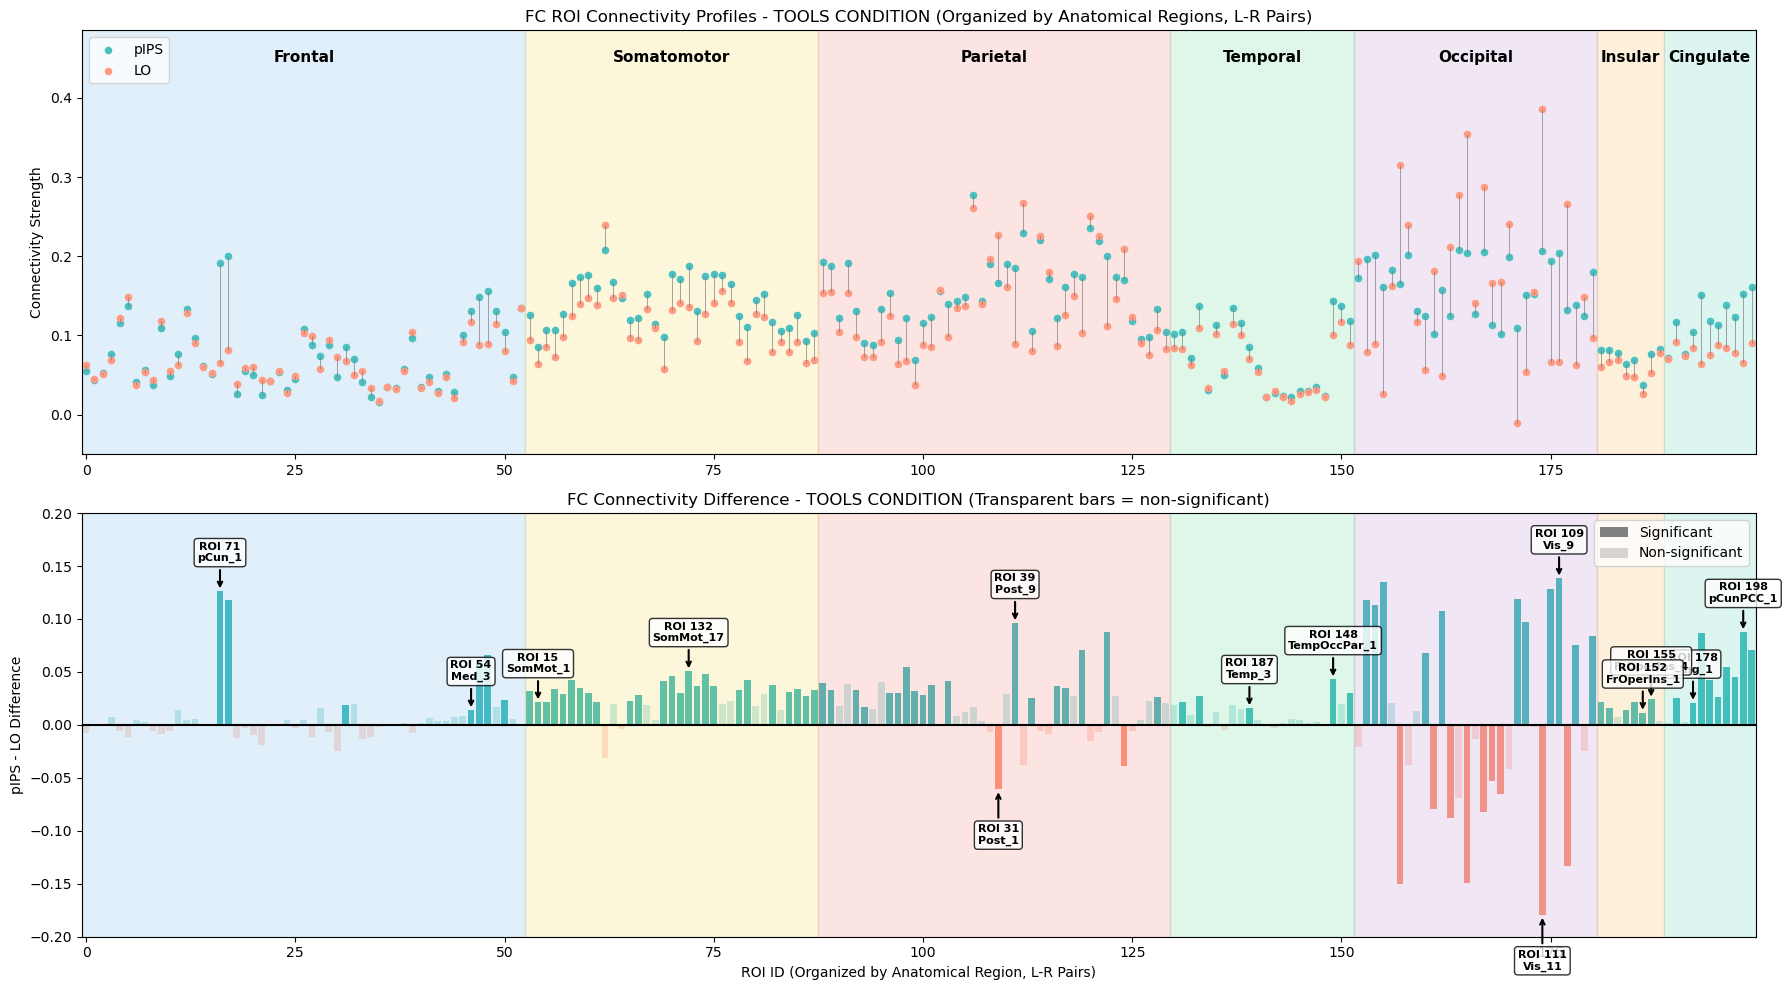

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/fc_tools_anatomical_organization_exp2.png

FC significant peak and bottom ROIs by anatomical lobe for TOOLS condition:

Cingulate Lobe:
  Peak (pIPS > LO): ROI 198 (pCunPCC_1), Diff = 0.088
  Bottom (LO > pIPS): ROI 178 (Cing_1), Diff = 0.021

Frontal Lobe:
  Peak (pIPS > LO): ROI 71 (pCun_1), Diff = 0.126
  Bottom (LO > pIPS): ROI 54 (Med_3), Diff = 0.014

Insular Lobe:
  Peak (pIPS > LO): ROI 155 (FrOperIns_4), Diff = 0.024
  Bottom (LO > pIPS): ROI 152 (FrOperIns_1), Diff = 0.012

Occipital Lobe:
  Peak (pIPS > LO): ROI 109 (Vis_9), Diff = 0.138
  Bottom (LO > pIPS): ROI 111 (Vis_11), Diff = -0.179

Parietal Lobe:
  Peak (pIPS > LO): ROI 39 (Post_9), Diff = 0.096
  Bottom (LO > pIPS): ROI 31 (Post_1), Diff = -0.061

Somatomotor Lobe:
  Peak (pIPS > LO): ROI 132 (SomMot_17), Diff = 0.051
  Bottom (LO > pIPS): ROI 15 (SomMot_1), Diff = 0.021

Temporal Lobe:
  Peak (pIPS > LO): ROI 148 (TempOccPar_1

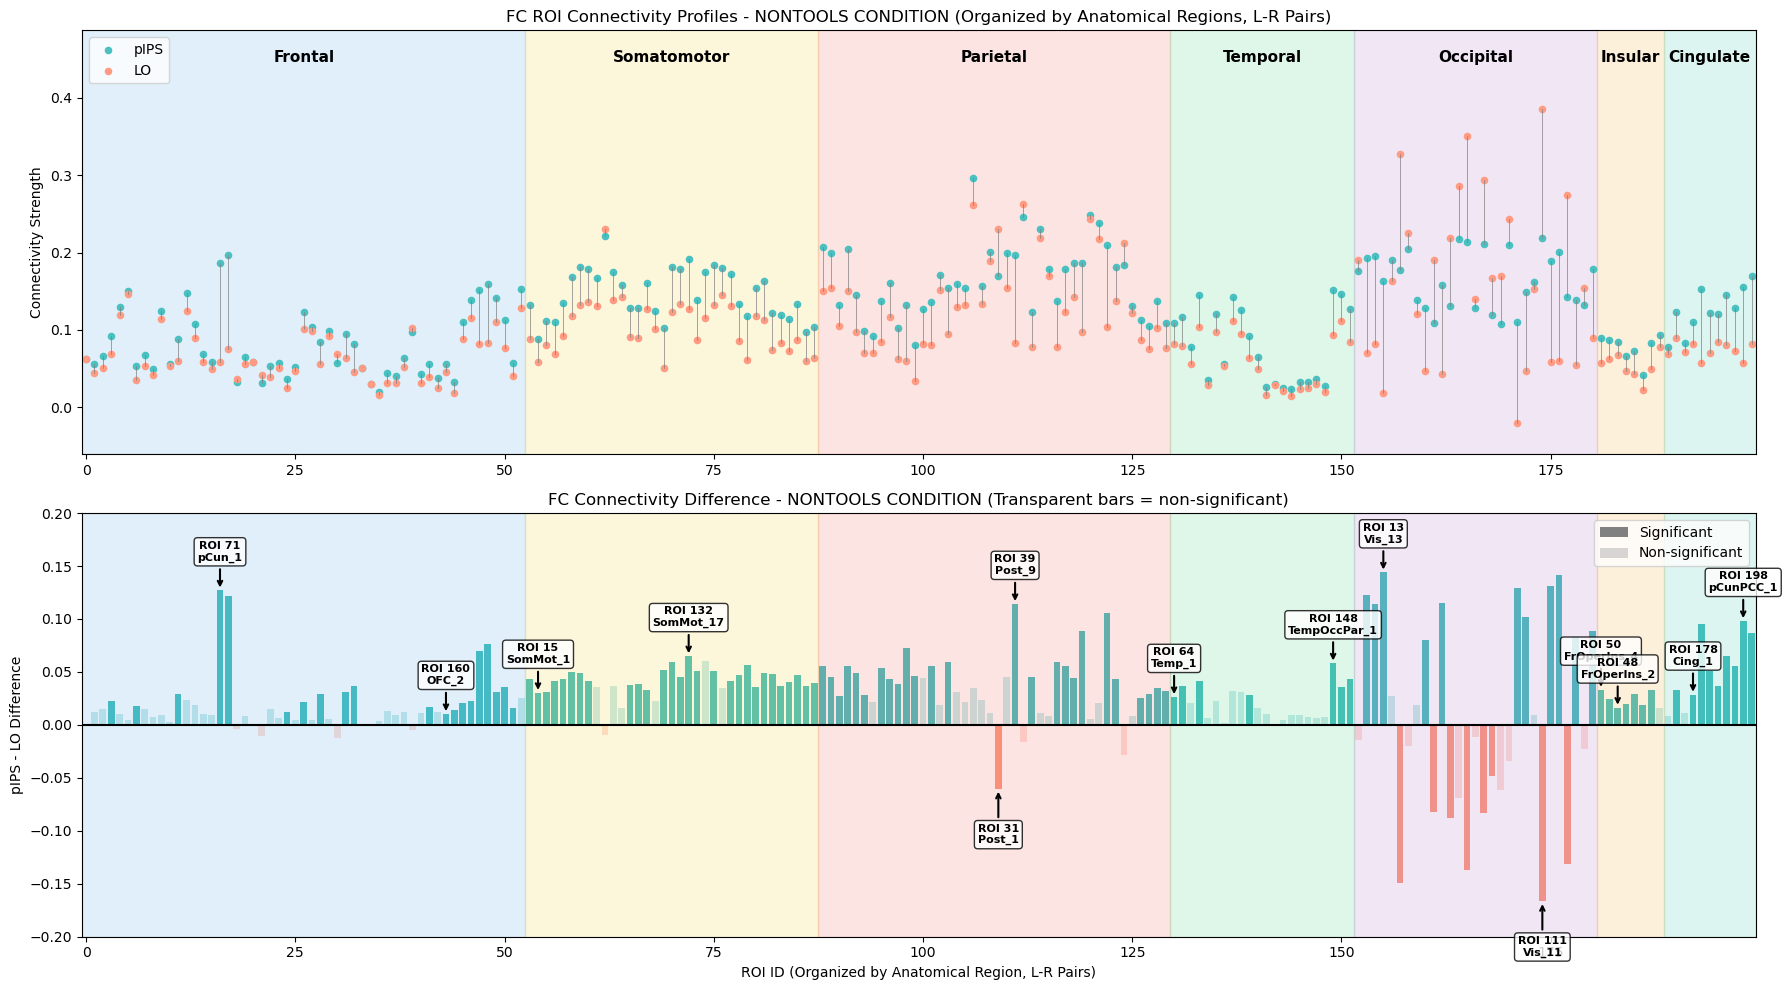

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/fc_nontools_anatomical_organization_exp2.png

FC significant peak and bottom ROIs by anatomical lobe for NONTOOLS condition:

Cingulate Lobe:
  Peak (pIPS > LO): ROI 198 (pCunPCC_1), Diff = 0.098
  Bottom (LO > pIPS): ROI 178 (Cing_1), Diff = 0.029

Frontal Lobe:
  Peak (pIPS > LO): ROI 71 (pCun_1), Diff = 0.127
  Bottom (LO > pIPS): ROI 160 (OFC_2), Diff = 0.010

Insular Lobe:
  Peak (pIPS > LO): ROI 50 (FrOperIns_4), Diff = 0.033
  Bottom (LO > pIPS): ROI 48 (FrOperIns_2), Diff = 0.016

Occipital Lobe:
  Peak (pIPS > LO): ROI 13 (Vis_13), Diff = 0.144
  Bottom (LO > pIPS): ROI 111 (Vis_11), Diff = -0.166

Parietal Lobe:
  Peak (pIPS > LO): ROI 39 (Post_9), Diff = 0.114
  Bottom (LO > pIPS): ROI 31 (Post_1), Diff = -0.060

Somatomotor Lobe:
  Peak (pIPS > LO): ROI 132 (SomMot_17), Diff = 0.065
  Bottom (LO > pIPS): ROI 15 (SomMot_1), Diff = 0.030

Temporal Lobe:
  Peak (pIPS > LO): ROI 148 (TempOcc

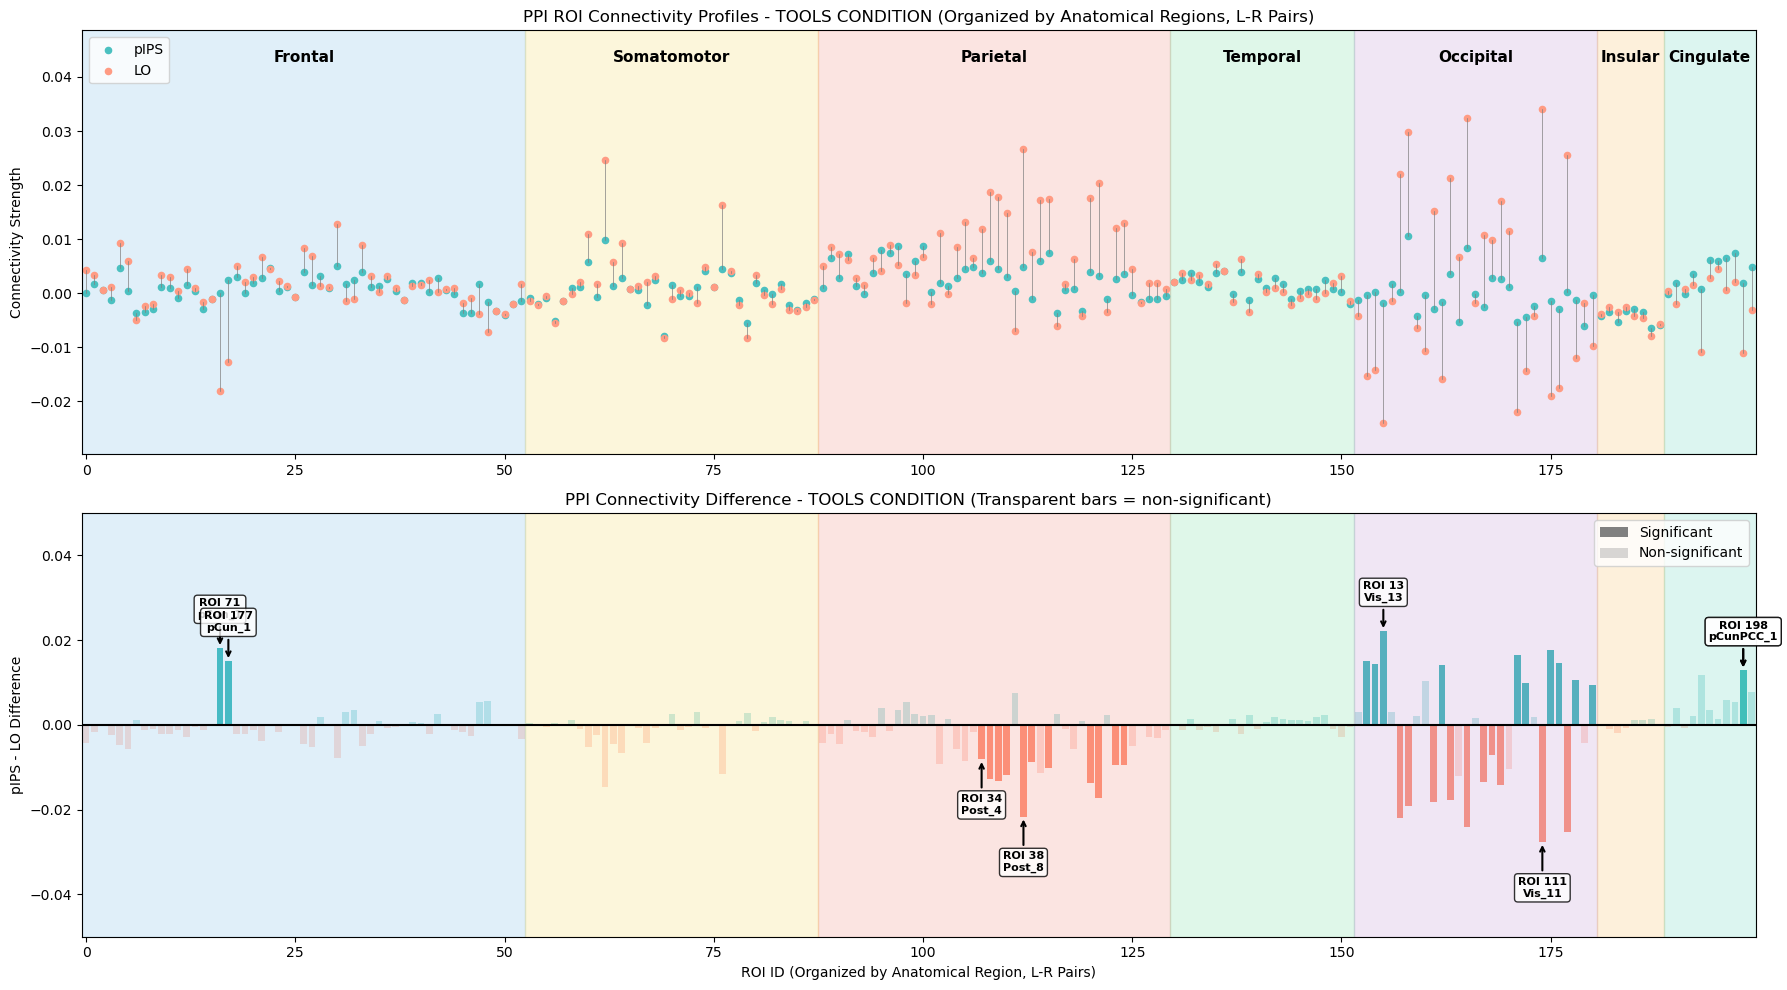

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/ppi_tools_anatomical_organization_exp2.png

PPI significant peak and bottom ROIs by anatomical lobe for TOOLS condition:

Cingulate Lobe:
  Peak (pIPS > LO): ROI 198 (pCunPCC_1), Diff = 0.013
  Bottom (LO > pIPS): ROI 198 (pCunPCC_1), Diff = 0.013

Frontal Lobe:
  Peak (pIPS > LO): ROI 71 (pCun_1), Diff = 0.018
  Bottom (LO > pIPS): ROI 177 (pCun_1), Diff = 0.015

Occipital Lobe:
  Peak (pIPS > LO): ROI 13 (Vis_13), Diff = 0.022
  Bottom (LO > pIPS): ROI 111 (Vis_11), Diff = -0.028

Parietal Lobe:
  Peak (pIPS > LO): ROI 34 (Post_4), Diff = -0.008
  Bottom (LO > pIPS): ROI 38 (Post_8), Diff = -0.022
Loaded PPI nontools condition results from /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/bilateral_ppi_nontools_connectivity_fingerprint_results.csv

CREATING PPI ANATOMICAL ORGANIZATION VISUALIZATION FOR NONTOOLS CONDITION (EXPERIMENT 2)


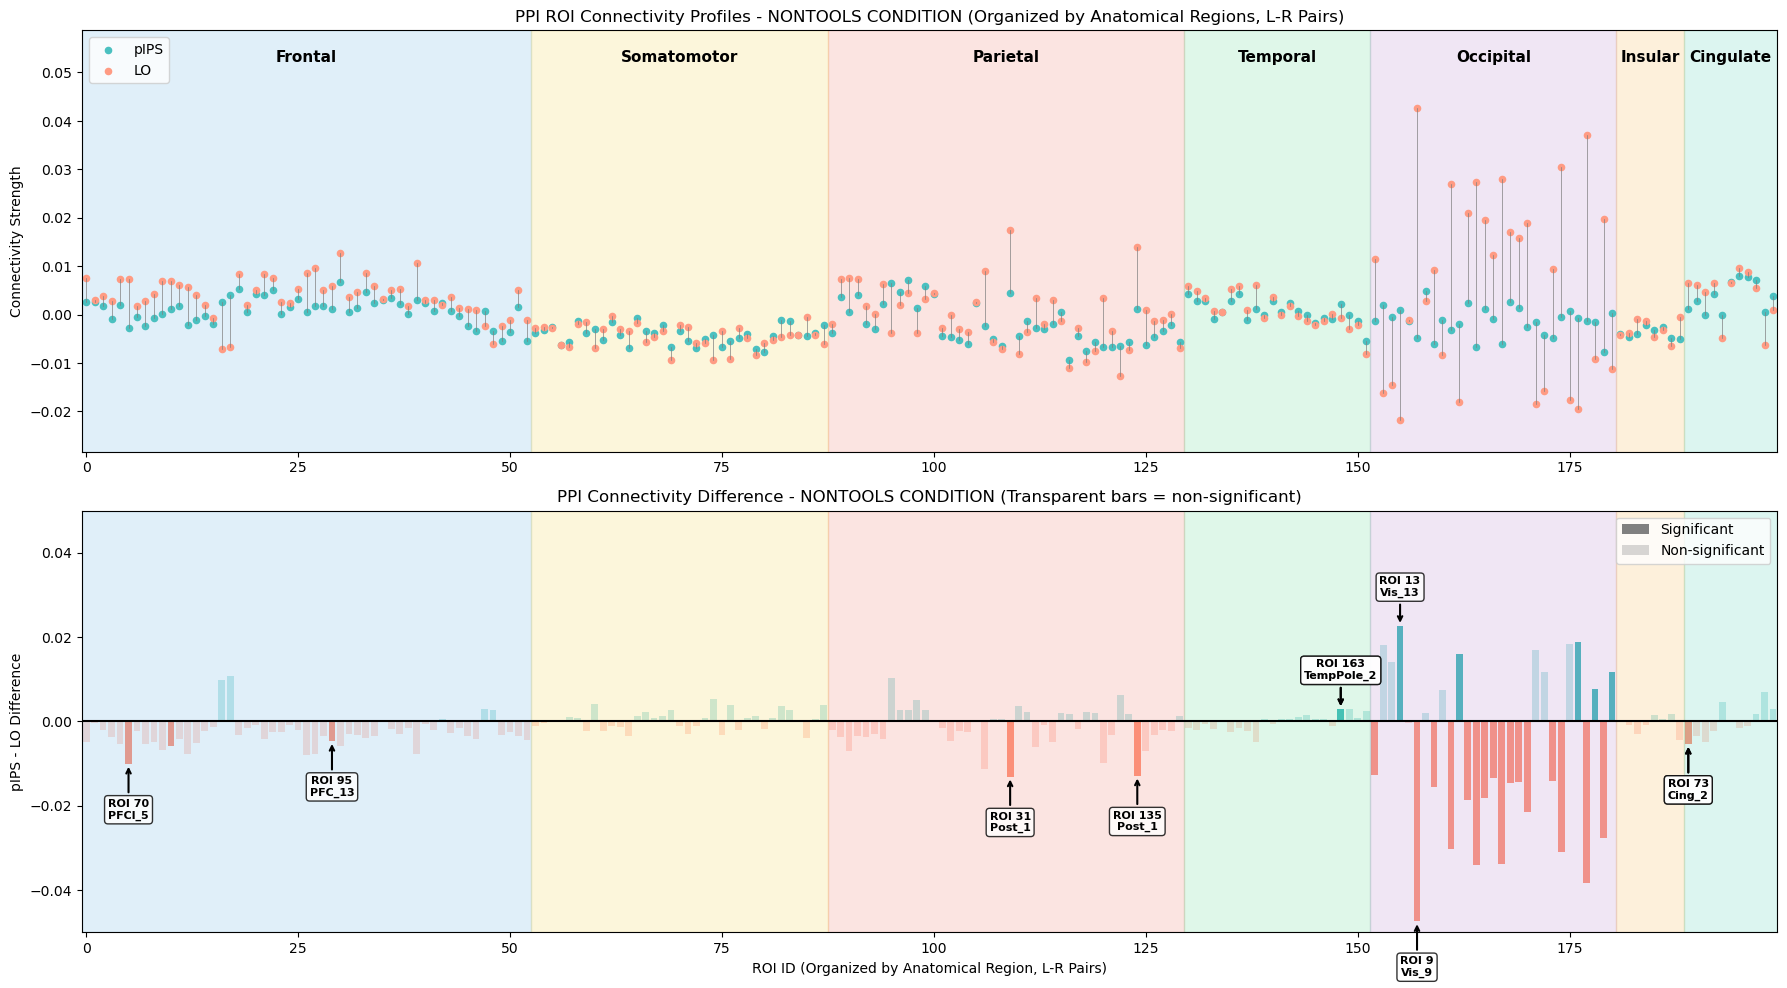

Figure saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_comparison/ppi_nontools_anatomical_organization_exp2.png

PPI significant peak and bottom ROIs by anatomical lobe for NONTOOLS condition:

Cingulate Lobe:
  Peak (pIPS > LO): ROI 73 (Cing_2), Diff = -0.005
  Bottom (LO > pIPS): ROI 73 (Cing_2), Diff = -0.005

Frontal Lobe:
  Peak (pIPS > LO): ROI 95 (PFC_13), Diff = -0.005
  Bottom (LO > pIPS): ROI 70 (PFCl_5), Diff = -0.010

Occipital Lobe:
  Peak (pIPS > LO): ROI 13 (Vis_13), Diff = 0.023
  Bottom (LO > pIPS): ROI 9 (Vis_9), Diff = -0.047

Parietal Lobe:
  Peak (pIPS > LO): ROI 135 (Post_1), Diff = -0.013
  Bottom (LO > pIPS): ROI 31 (Post_1), Diff = -0.013

Temporal Lobe:
  Peak (pIPS > LO): ROI 163 (TempPole_2), Diff = 0.003
  Bottom (LO > pIPS): ROI 163 (TempPole_2), Diff = 0.003

Visualizations complete - figures were saved to disk.


In [35]:
# Regional Brain Connectivity Analysis Part 2: Visualization for Experiment 2
# Description: Visualization of functional connectivity (FC) and psychophysiological interaction (PPI)
#              between parietal IPS and lateral occipital regions organized by anatomical location
#              Separated by tools and nontools conditions for Experiment 2

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from matplotlib.patches import Patch

# Define paths - updated for experiment 2
results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
output_dir = f'{results_dir}/exp2_connectivity_comparison'  # Updated for exp2

def visualize_anatomical_organization(results_df, roi_data, analysis_type='fc', condition='tools'):
    """Create anatomical organization visualization for Experiment 2, separated by condition"""
    print(f"\n{'='*80}")
    print(f"CREATING {analysis_type.upper()} ANATOMICAL ORGANIZATION VISUALIZATION FOR {condition.upper()} CONDITION (EXPERIMENT 2)")
    print(f"{'='*80}")
    
    # Extract data from parameters
    mean_pips = roi_data['mean_pips']
    mean_lo = roi_data['mean_lo']
    diff_profile = roi_data['diff_profile']
    ci_lower = roi_data['ci_lower']
    ci_upper = roi_data['ci_upper']
    sig_combined = roi_data['sig_combined']
    
    # Function to map ROI names to anatomical lobes
    def map_to_anatomical_lobe(roi_name):
        # Special handling for Wang atlas ROIs
        if 'Wang_pIPS' in roi_name:
            return 'Parietal'
        elif 'Wang_LO' in roi_name:
            return 'Temporal'
        
        # Map Schaefer networks to anatomical regions
        if 'Vis' in roi_name:
            return 'Occipital'
        elif 'SomMot' in roi_name:
            return 'Somatomotor'
        elif 'DorsAttn' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            else:
                return 'Parietal'
        elif 'SalVentAttn' in roi_name:
            if 'Ins' in roi_name:
                return 'Insular'
            elif 'Cing' in roi_name or 'ACC' in roi_name:
                return 'Cingulate'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'Par' in roi_name:
                return 'Parietal'
            else:
                return 'Frontal'
        elif 'Limbic' in roi_name:
            if 'Temp' in roi_name:
                return 'Temporal'
            else:
                return 'Frontal'
        elif 'Cont' in roi_name:
            if 'Par' in roi_name or 'IPL' in roi_name or 'IPS' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name or 'MT' in roi_name:
                return 'Temporal'
            elif 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        elif 'Default' in roi_name:
            if 'Par' in roi_name:
                return 'Parietal'
            elif 'Temp' in roi_name:
                return 'Temporal'
            elif 'PCC' in roi_name or 'Cing' in roi_name:
                return 'Cingulate'
            else:
                return 'Frontal'
        else:
            return 'Other'
    
    # Clean up ROI names for better labeling
    def clean_roi_name(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Handle Wang ROIs
        if 'Wang_' in roi_name:
            return roi_name.replace('Wang_', '')
        
        # Remove common prefixes and suffixes
        cleaned = roi_name.replace('7Networks_', '')
        
        # Extract just the region part, removing hemisphere and network
        parts = cleaned.split('_')
        if len(parts) > 2:
            return parts[-2] + '_' + parts[-1]
        elif len(parts) > 1:
            return parts[-1]
        else:
            return cleaned
    
    # Determine hemisphere and base region for organizing pairs
    def get_hemisphere_and_region(roi_name):
        if isinstance(roi_name, bytes):
            roi_name = roi_name.decode('utf-8')
        
        # Determine hemisphere 
        if 'LH' in roi_name:
            hemisphere = 'L'
        elif 'RH' in roi_name:
            hemisphere = 'R'
        else:
            # For Wang ROIs or ROIs without clear hemisphere
            if 'Wang_pIPS' in roi_name or 'Wang_LO' in roi_name:
                hemisphere = 'X'  # Bilateral
            else:
                hemisphere = 'X'  # Unknown
        
        # Extract base region by removing hemisphere and number
        cleaned = roi_name.replace('7Networks_', '')
        cleaned = cleaned.replace('LH_', '').replace('RH_', '')
        
        # Handle Wang ROIs
        if 'Wang_' in cleaned:
            base_region = cleaned.replace('Wang_', '')
        else:
            # Remove trailing numbers which often differentiate regions
            base_region = re.sub(r'_\d+$', '', cleaned)
        
        return hemisphere, base_region
    
    # Add anatomical lobe and hemisphere information to the dataframe
    results_df['Anatomical_Lobe'] = results_df['ROI_Name'].apply(map_to_anatomical_lobe)
    results_df['Clean_Name'] = results_df['ROI_Name'].apply(clean_roi_name)
    
    # Extract hemisphere and base region info
    hemisphere_region = results_df['ROI_Name'].apply(get_hemisphere_and_region)
    results_df['Hemisphere'] = [h for h, r in hemisphere_region]
    results_df['Base_Region'] = [r for h, r in hemisphere_region]
    
    # Define a manual order for anatomical lobes
    lobe_order = [
        'Frontal',
        'Somatomotor',
        'Parietal',
        'Temporal',
        'Occipital',
        'Insular',
        'Cingulate',
        'Other'
    ]
    
    # Create a category for sorting based on the defined order
    lobe_cat = pd.Categorical(results_df['Anatomical_Lobe'], categories=lobe_order, ordered=True)
    results_df['Lobe_Sorted'] = lobe_cat
    
    # Define a consistent color palette for brain lobes
    lobe_colors = {
        'Frontal': '#3498db',     # Blue
        'Somatomotor': '#f1c40f', # Yellow
        'Parietal': '#e74c3c',    # Red
        'Temporal': '#2ecc71',    # Green
        'Occipital': '#9b59b6',   # Purple
        'Insular': '#f39c12',     # Orange
        'Cingulate': '#1abc9c',   # Turquoise
        'Other': '#7f8c8d'        # Gray
    }
    
    # Custom sorting function to group by lobe, then by base region, then by hemisphere (L then R)
    def custom_sort(row):
        lobe_idx = lobe_order.index(row['Anatomical_Lobe']) if row['Anatomical_Lobe'] in lobe_order else 999
        hemi_idx = 0 if row['Hemisphere'] == 'L' else 1 if row['Hemisphere'] == 'R' else 2
        return (lobe_idx, row['Base_Region'], hemi_idx)
    
    # Sort using the custom function
    results_df['sort_key'] = results_df.apply(custom_sort, axis=1)
    results_df_sorted = results_df.sort_values('sort_key')
    
    # Get the new order
    sorted_indices = results_df_sorted.index.values
    
    # Extract reordered data
    mean_pips_sorted = results_df_sorted['pIPS_Connectivity'].values
    mean_lo_sorted = results_df_sorted['LO_Connectivity'].values
    diff_profile_sorted = results_df_sorted['Difference'].values
    sig_sorted = results_df_sorted['Combined_Significant'].values
    
    # Find peak (highest) and bottom (lowest) significant ROI in each lobe
    significant_peak_bottom_indices = []
    lobe_groups = results_df_sorted.groupby('Anatomical_Lobe')
    
    for lobe, group in lobe_groups:
        if len(group) > 0:
            # Get significant ROIs in this lobe
            sig_group = group[group['Combined_Significant']]
            
            if len(sig_group) > 0:
                # Get highest difference (most pIPS-preferring) significant ROI
                peak_idx = sig_group['Difference'].idxmax()
                significant_peak_bottom_indices.append(peak_idx)
                
                # Get lowest difference (most LO-preferring) significant ROI
                bottom_idx = sig_group['Difference'].idxmin()
                significant_peak_bottom_indices.append(bottom_idx)
    
    # Create the visualization
    plt.figure(figsize=(18, 10))
    
    # Top subplot - connectivity profiles with lollipop plot, organized by lobe
    ax1 = plt.subplot(2, 1, 1)
    x = np.arange(len(mean_pips_sorted))
    
    # Get the y-limits for label positioning
    y_min, y_max = min(min(mean_pips_sorted), min(mean_lo_sorted)), max(max(mean_pips_sorted), max(mean_lo_sorted))
    y_range = y_max - y_min
    
    # Plot background colors for different lobes
    current_lobe = None
    start_idx = 0
    
    for i, idx in enumerate(sorted_indices):
        lobe = results_df_sorted.iloc[i]['Anatomical_Lobe']
        if lobe != current_lobe:
            if current_lobe is not None:
                # Mark the region for the previous lobe
                plt.axvspan(start_idx - 0.5, i - 0.5, alpha=0.15, 
                           color=lobe_colors[current_lobe])
                # Add label in the middle of the region with fixed top position
                label_y = y_max + 0.15 * y_range  # Position labels above the data
                plt.text((start_idx + i - 1) / 2, label_y, 
                        current_lobe, ha='center', fontsize=11, fontweight='bold')
            current_lobe = lobe
            start_idx = i
    
    # Add the last region
    plt.axvspan(start_idx - 0.5, len(mean_pips_sorted) - 0.5, alpha=0.15, 
               color=lobe_colors[current_lobe])
    plt.text((start_idx + len(mean_pips_sorted) - 1) / 2, y_max + 0.15 * y_range, 
            current_lobe, ha='center', fontsize=11, fontweight='bold')
    
    # Create lollipop plot - vertical lines connecting pIPS and LO points
    for i in range(len(x)):
        plt.plot([x[i], x[i]], [mean_pips_sorted[i], mean_lo_sorted[i]], color='gray', linestyle='-', linewidth=0.5)
    
    # Plot the points
    plt.scatter(x, mean_pips_sorted, color='#4ac0c0', s=20, label='pIPS')
    plt.scatter(x, mean_lo_sorted, color='#ff9b83', s=20, label='LO')
    
    # Set y-axis limits with padding for the labels
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.25 * y_range)
    
    plt.ylabel('Connectivity Strength')
    plt.title(f'{analysis_type.upper()} ROI Connectivity Profiles - {condition.upper()} CONDITION (Organized by Anatomical Regions, L-R Pairs)')
    plt.legend(loc='upper left')
    plt.xlim(-0.5, len(mean_pips_sorted) - 0.5)
    
    # Bottom subplot - difference
    ax2 = plt.subplot(2, 1, 2)
    
    # Create base bar plot for all bars
    base_colors = ['#4ac0c0' if val > 0 else '#ff9b83' for val in diff_profile_sorted]
    bars = plt.bar(x, diff_profile_sorted, color=base_colors)
    
    # Apply transparency to non-significant bars individually
    for i, (bar, is_sig) in enumerate(zip(bars, sig_sorted)):
        if not is_sig:
            # Set alpha for non-significant bars only
            bar.set_alpha(0.3)
    
    plt.axhline(y=0, color='black', linestyle='-')
    
    # Add a legend for significance
    legend_elements = [
        Patch(facecolor='gray', alpha=1.0, label='Significant'),
        Patch(facecolor='gray', alpha=0.3, label='Non-significant')
    ]
    plt.legend(handles=legend_elements, loc='upper right')
    
    # Add background colors for different lobes (same as top plot)
    current_lobe = None
    start_idx = 0
    
    for i, idx in enumerate(sorted_indices):
        lobe = results_df_sorted.iloc[i]['Anatomical_Lobe']
        if lobe != current_lobe:
            if current_lobe is not None:
                plt.axvspan(start_idx - 0.5, i - 0.5, alpha=0.15, 
                           color=lobe_colors[current_lobe])
            current_lobe = lobe
            start_idx = i
    
    # Add the last region
    plt.axvspan(start_idx - 0.5, len(mean_pips_sorted) - 0.5, alpha=0.15, 
               color=lobe_colors[current_lobe])
    
    # Label only significant peak and bottom ROIs
    for peak_idx in significant_peak_bottom_indices:
        # Find position in sorted array
        position = np.where(sorted_indices == peak_idx)[0][0]
        roi_id = results_df.loc[peak_idx, 'ROI_ID']
        roi_name = results_df.loc[peak_idx, 'Clean_Name']
        diff_value = results_df.loc[peak_idx, 'Difference']
        
        # Add annotation for ROI
        plt.annotate(f'ROI {roi_id}\n{roi_name}',
                    xy=(position, diff_value),
                    xytext=(0, 20 if diff_value >= 0 else -25),
                    textcoords='offset points',
                    ha='center',
                    va='bottom' if diff_value >= 0 else 'top',
                    fontsize=8,
                    fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8),
                    arrowprops=dict(arrowstyle='->', lw=1.5))
    
    plt.ylabel('pIPS - LO Difference')
    plt.xlabel('ROI ID (Organized by Anatomical Region, L-R Pairs)')
    plt.title(f'{analysis_type.upper()} Connectivity Difference - {condition.upper()} CONDITION (Transparent bars = non-significant)')
    plt.xlim(-0.5, len(mean_pips_sorted) - 0.5)
    
    # Set different y-axis limits for the second panel based on analysis type
    if analysis_type == 'fc':
        # For FC analysis: range from -0.2 to 0.2
        plt.ylim(-0.2, 0.2)
    else:  # For PPI analysis
        # For PPI analysis: range from -0.05 to 0.05
        plt.ylim(-0.05, 0.05)
    
    plt.tight_layout()
    
    # Save the figure - updated filename to include condition
    fig_path = f'{output_dir}/{analysis_type}_{condition}_anatomical_organization_exp2.png'
    plt.savefig(fig_path, dpi=300)
    plt.show()
    
    print(f"Figure saved to {fig_path}")
    
    # Print peak and bottom ROIs by lobe, only for significant ROIs
    print(f"\n{analysis_type.upper()} significant peak and bottom ROIs by anatomical lobe for {condition.upper()} condition:")
    for lobe, group in lobe_groups:
        # Get significant ROIs in this lobe
        sig_group = group[group['Combined_Significant']]
        
        if len(sig_group) > 0:
            print(f"\n{lobe} Lobe:")
            
            # Peak (pIPS-preferring) significant ROI
            peak_row = sig_group.loc[sig_group['Difference'].idxmax()]
            print(f"  Peak (pIPS > LO): ROI {peak_row['ROI_ID']} ({peak_row['Clean_Name']}), " + 
                  f"Diff = {peak_row['Difference']:.3f}")
            
            # Bottom (LO-preferring) significant ROI
            bottom_row = sig_group.loc[sig_group['Difference'].idxmin()]
            print(f"  Bottom (LO > pIPS): ROI {bottom_row['ROI_ID']} ({bottom_row['Clean_Name']}), " + 
                  f"Diff = {bottom_row['Difference']:.3f}")
    
    return

# Load saved results and create visualizations for Experiment 2
def load_and_visualize_results_exp2():
    """Load and visualize connectivity results for Experiment 2, separated by condition"""
    # Check if merged atlas exists for Experiment 2
    merged_atlas_file = f'{results_dir}/exp2/schaefer_wang_merged_exp2.nii.gz'  # Updated for exp2
    merged_labels_file = f'{results_dir}/exp2/merged_atlas_labels_exp2.npy'  # Updated for exp2
    
    if not os.path.exists(merged_atlas_file) or not os.path.exists(merged_labels_file):
        print("Error: Merged atlas files for Experiment 2 not found. Please run merge_atlas_exp2.py first.")
        return
    
    # Load merged atlas labels
    atlas_labels = np.load(merged_labels_file, allow_pickle=True)
    print(f"Loaded merged atlas labels for Experiment 2 with {len(atlas_labels)} regions")
    
    # Process FC for tools condition
    fc_tools_csv_path = f'{output_dir}/bilateral_fc_tools_connectivity_fingerprint_results.csv'
    if os.path.exists(fc_tools_csv_path):
        fc_tools_results = pd.read_csv(fc_tools_csv_path)
        print(f"Loaded FC tools condition results from {fc_tools_csv_path}")
        
        # Extract data needed for visualization
        fc_tools_data = {
            'mean_pips': fc_tools_results['pIPS_Connectivity'].values,
            'mean_lo': fc_tools_results['LO_Connectivity'].values,
            'diff_profile': fc_tools_results['Difference'].values,
            'ci_lower': fc_tools_results['CI_Lower'].values,
            'ci_upper': fc_tools_results['CI_Upper'].values,
            'sig_combined': fc_tools_results['Combined_Significant'].values
        }
        
        # Create FC tools visualization
        visualize_anatomical_organization(fc_tools_results, fc_tools_data, analysis_type='fc', condition='tools')
    else:
        print(f"FC tools condition results file not found: {fc_tools_csv_path}")
    
    # Process FC for nontools condition
    fc_nontools_csv_path = f'{output_dir}/bilateral_fc_nontools_connectivity_fingerprint_results.csv'
    if os.path.exists(fc_nontools_csv_path):
        fc_nontools_results = pd.read_csv(fc_nontools_csv_path)
        print(f"Loaded FC nontools condition results from {fc_nontools_csv_path}")
        
        # Extract data needed for visualization
        fc_nontools_data = {
            'mean_pips': fc_nontools_results['pIPS_Connectivity'].values,
            'mean_lo': fc_nontools_results['LO_Connectivity'].values,
            'diff_profile': fc_nontools_results['Difference'].values,
            'ci_lower': fc_nontools_results['CI_Lower'].values,
            'ci_upper': fc_nontools_results['CI_Upper'].values,
            'sig_combined': fc_nontools_results['Combined_Significant'].values
        }
        
        # Create FC nontools visualization
        visualize_anatomical_organization(fc_nontools_results, fc_nontools_data, analysis_type='fc', condition='nontools')
    else:
        print(f"FC nontools condition results file not found: {fc_nontools_csv_path}")
    
    # Process PPI for tools condition
    ppi_tools_csv_path = f'{output_dir}/bilateral_ppi_tools_connectivity_fingerprint_results.csv'
    if os.path.exists(ppi_tools_csv_path):
        ppi_tools_results = pd.read_csv(ppi_tools_csv_path)
        print(f"Loaded PPI tools condition results from {ppi_tools_csv_path}")
        
        # Extract data needed for visualization
        ppi_tools_data = {
            'mean_pips': ppi_tools_results['pIPS_Connectivity'].values,
            'mean_lo': ppi_tools_results['LO_Connectivity'].values,
            'diff_profile': ppi_tools_results['Difference'].values,
            'ci_lower': ppi_tools_results['CI_Lower'].values,
            'ci_upper': ppi_tools_results['CI_Upper'].values,
            'sig_combined': ppi_tools_results['Combined_Significant'].values
        }
        
        # Create PPI tools visualization
        visualize_anatomical_organization(ppi_tools_results, ppi_tools_data, analysis_type='ppi', condition='tools')
    else:
        print(f"PPI tools condition results file not found: {ppi_tools_csv_path}")
    
    # Process PPI for nontools condition
    ppi_nontools_csv_path = f'{output_dir}/bilateral_ppi_nontools_connectivity_fingerprint_results.csv'
    if os.path.exists(ppi_nontools_csv_path):
        ppi_nontools_results = pd.read_csv(ppi_nontools_csv_path)
        print(f"Loaded PPI nontools condition results from {ppi_nontools_csv_path}")
        
        # Extract data needed for visualization
        ppi_nontools_data = {
            'mean_pips': ppi_nontools_results['pIPS_Connectivity'].values,
            'mean_lo': ppi_nontools_results['LO_Connectivity'].values,
            'diff_profile': ppi_nontools_results['Difference'].values,
            'ci_lower': ppi_nontools_results['CI_Lower'].values,
            'ci_upper': ppi_nontools_results['CI_Upper'].values,
            'sig_combined': ppi_nontools_results['Combined_Significant'].values
        }
        
        # Create PPI nontools visualization
        visualize_anatomical_organization(ppi_nontools_results, ppi_nontools_data, analysis_type='ppi', condition='nontools')
    else:
        print(f"PPI nontools condition results file not found: {ppi_nontools_csv_path}")

# Run visualizations for Experiment 2
if __name__ == "__main__":
    print("\nCreating anatomical organization visualizations for Experiment 2 (tools and nontools conditions)...")
    load_and_visualize_results_exp2()
    print("\nVisualizations complete - figures were saved to disk.")


Running connectivity asymmetry analysis for Experiment 2...

ANALYZING FC ASYMMETRY IN CONNECTIONS BETWEEN pIPS AND LO
FOR TOOLS CONDITION (EXPERIMENT 2)...
Merged atlas files for Experiment 2 found. Analysis will use results from merged atlas approach.
Loaded FC connectivity data for tools condition with 200 ROIs
Found 92 significant ROIs for tools condition
pIPS > LO: 81 regions
LO > pIPS: 11 regions

Chi-square test for asymmetry in number of connections:
Observed frequencies: pIPS > LO: 81, LO > pIPS: 11
Expected frequencies: pIPS > LO: 46.0, LO > pIPS: 46.0
Chi-square statistic: 53.2609
p-value: 0.00000000
The asymmetry in number of connections is statistically significant.
pIPS has significantly more connections than LO (p < .001).

Mean strength of pIPS-dominant connections: 0.0484 ± 0.0329
Mean strength of LO-dominant connections: 0.0982 ± 0.0447

Mann-Whitney U test for connection strength differences:
U statistic: 142.0
p-value: 0.00026604
LO-dominant connections are signifi

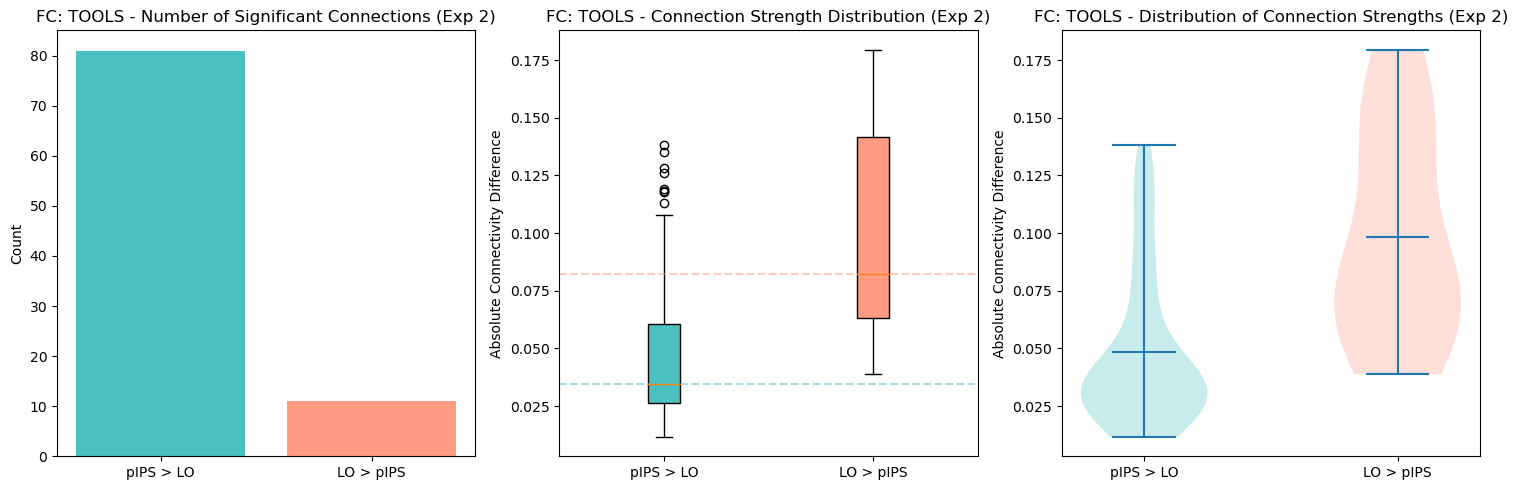


FC analysis for tools condition complete. Results saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_asymmetry

ANALYZING FC ASYMMETRY IN CONNECTIONS BETWEEN pIPS AND LO
FOR NONTOOLS CONDITION (EXPERIMENT 2)...
Merged atlas files for Experiment 2 found. Analysis will use results from merged atlas approach.
Loaded FC connectivity data for nontools condition with 200 ROIs
Found 116 significant ROIs for nontools condition
pIPS > LO: 107 regions
LO > pIPS: 9 regions

Chi-square test for asymmetry in number of connections:
Observed frequencies: pIPS > LO: 107, LO > pIPS: 9
Expected frequencies: pIPS > LO: 58.0, LO > pIPS: 58.0
Chi-square statistic: 82.7931
p-value: 0.00000000
The asymmetry in number of connections is statistically significant.
pIPS has significantly more connections than LO (p < .001).

Mean strength of pIPS-dominant connections: 0.0519 ± 0.0310
Mean strength of LO-dominant connections: 0.1050 ± 0.0394

Mann-Whitney U test for connection strength differe

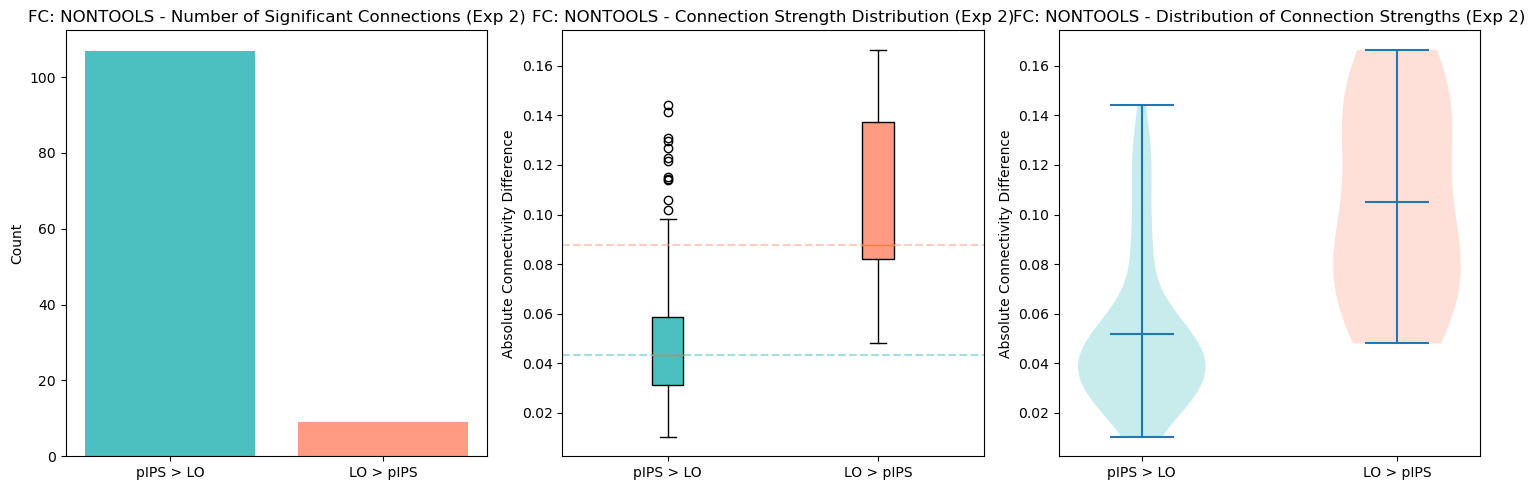


FC analysis for nontools condition complete. Results saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_asymmetry

ANALYZING PPI ASYMMETRY IN CONNECTIONS BETWEEN pIPS AND LO
FOR TOOLS CONDITION (EXPERIMENT 2)...
Merged atlas files for Experiment 2 found. Analysis will use results from merged atlas approach.
Loaded PPI connectivity data for tools condition with 200 ROIs
Found 34 significant ROIs for tools condition
pIPS > LO: 13 regions
LO > pIPS: 21 regions

Chi-square test for asymmetry in number of connections:
Observed frequencies: pIPS > LO: 13, LO > pIPS: 21
Expected frequencies: pIPS > LO: 17.0, LO > pIPS: 17.0
Chi-square statistic: 1.8824
p-value: 0.17006696
The asymmetry in number of connections is not statistically significant.

Mean strength of pIPS-dominant connections: 0.0147 ± 0.0034
Mean strength of LO-dominant connections: 0.0155 ± 0.0059

Mann-Whitney U test for connection strength differences:
U statistic: 138.0
p-value: 0.97173009
No significant di

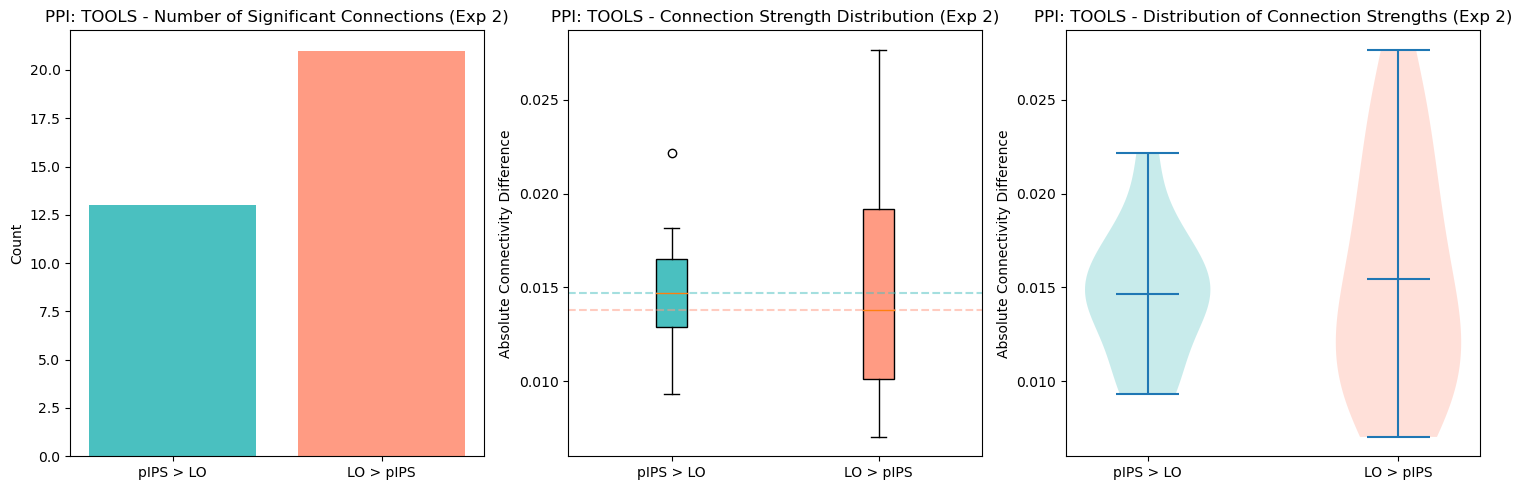


PPI analysis for tools condition complete. Results saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_asymmetry

ANALYZING PPI ASYMMETRY IN CONNECTIONS BETWEEN pIPS AND LO
FOR NONTOOLS CONDITION (EXPERIMENT 2)...
Merged atlas files for Experiment 2 found. Analysis will use results from merged atlas approach.
Loaded PPI connectivity data for nontools condition with 200 ROIs
Found 28 significant ROIs for nontools condition
pIPS > LO: 6 regions
LO > pIPS: 22 regions

Chi-square test for asymmetry in number of connections:
Observed frequencies: pIPS > LO: 6, LO > pIPS: 22
Expected frequencies: pIPS > LO: 14.0, LO > pIPS: 14.0
Chi-square statistic: 9.1429
p-value: 0.00249691
The asymmetry in number of connections is statistically significant.
LO has significantly more connections than pIPS (p = 0.0025).

Mean strength of pIPS-dominant connections: 0.0133 ± 0.0067
Mean strength of LO-dominant connections: 0.0199 ± 0.0113

Mann-Whitney U test for connection strength differ

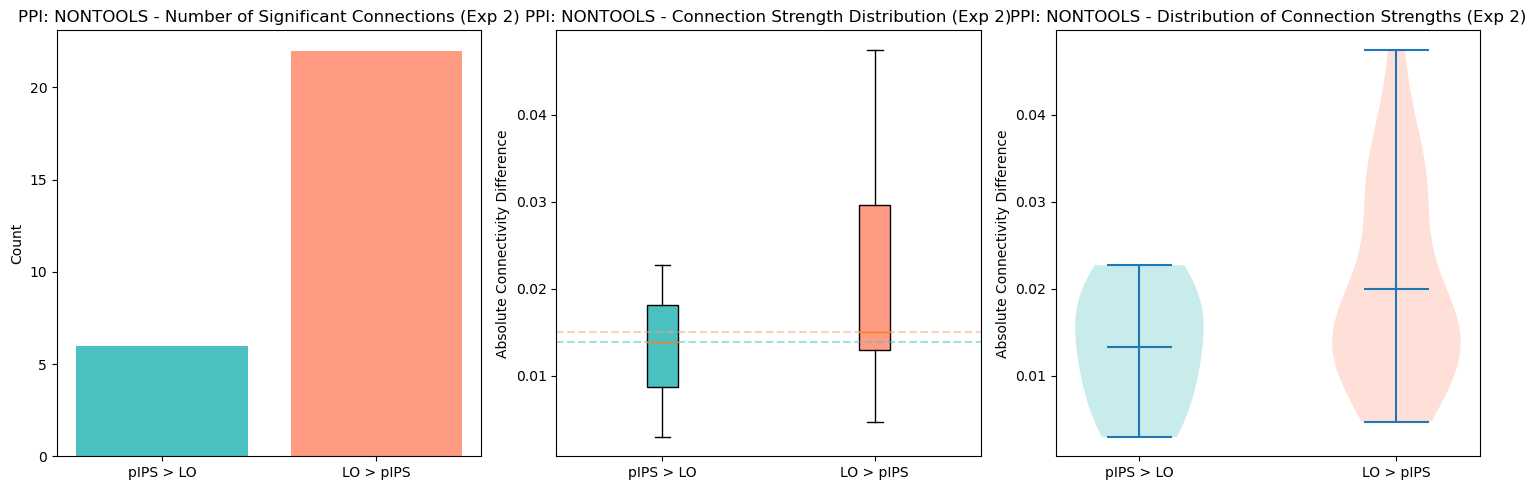


PPI analysis for nontools condition complete. Results saved to /user_data/csimmon2/git_repos/ptoc/results/exp2_connectivity_asymmetry

COMPARISON SUMMARY: FC vs PPI FOR TOOLS CONDITION (EXPERIMENT 2)

Number of significant connections (TOOLS):
FC: pIPS > LO: 81, LO > pIPS: 11
PPI: pIPS > LO: 13, LO > pIPS: 21

Asymmetry significance (TOOLS):
FC: Chi-square = 53.2609, p = 0.00000000
PPI: Chi-square = 1.8824, p = 0.17006696

Connection strength metrics (TOOLS):
FC (TOOLS):
  pIPS mean: 0.0484, median: 0.0344
  LO mean: 0.0982, median: 0.0821
  Ratio pIPS/LO total: 3.63
PPI (TOOLS):
  pIPS mean: 0.0147, median: 0.0147
  LO mean: 0.0155, median: 0.0138
  Ratio pIPS/LO total: 0.59

COMPARISON SUMMARY: FC vs PPI FOR NONTOOLS CONDITION (EXPERIMENT 2)

Number of significant connections (NONTOOLS):
FC: pIPS > LO: 107, LO > pIPS: 9
PPI: pIPS > LO: 6, LO > pIPS: 22

Asymmetry significance (NONTOOLS):
FC: Chi-square = 82.7931, p = 0.00000000
PPI: Chi-square = 9.1429, p = 0.00249691

Connection st

In [ ]:
# Chi-squared test for independence in Experiment 2
# Chi-square comparison of pIPS>LO connectivities for both FC and PPI in the tool localizer experiment
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

def analyze_connectivity_asymmetry(analysis_type='fc', condition='tools'):
    """
    Analyze the asymmetry in number and strength of connections for pIPS and LO regions.
    Tests whether pIPS has significantly more and stronger connections than LO.
    Uses Mann-Whitney U test for strength comparison to handle unequal sample sizes.
    Updated for Experiment 2 with tool localizer data, separated by condition.
    
    Parameters:
    -----------
    analysis_type : str
        Type of analysis to perform, either 'fc' or 'ppi'
    condition : str
        Condition to analyze, either 'tools' or 'nontools'
    """
    # Define paths - updated for experiment 2
    results_dir = '/user_data/csimmon2/git_repos/ptoc/results'
    connectivity_dir = f'{results_dir}/exp2_connectivity_comparison'  # Updated for exp 2
    output_dir = f'{results_dir}/exp2_connectivity_asymmetry'  # Updated for exp 2
    os.makedirs(output_dir, exist_ok=True)
    
    print(f"\n{'='*80}")
    print(f"ANALYZING {analysis_type.upper()} ASYMMETRY IN CONNECTIONS BETWEEN pIPS AND LO")
    print(f"FOR {condition.upper()} CONDITION (EXPERIMENT 2)...")
    print(f"{'='*80}")
    
    # Check if merged atlas exists for Experiment 2
    merged_atlas_file = f'{results_dir}/exp2/schaefer_wang_merged_exp2.nii.gz'  # Updated for exp 2
    merged_labels_file = f'{results_dir}/exp2/merged_atlas_labels_exp2.npy'  # Updated for exp 2
    
    if not os.path.exists(merged_atlas_file) or not os.path.exists(merged_labels_file):
        print("Warning: Merged atlas files for Experiment 2 not found. Results may not reflect merged atlas.")
    else:
        print("Merged atlas files for Experiment 2 found. Analysis will use results from merged atlas approach.")
    
    # Load connectivity results from CSV - updated to include condition
    results_path = f'{connectivity_dir}/bilateral_{analysis_type}_{condition}_connectivity_fingerprint_results.csv'
    if not os.path.exists(results_path):
        print(f"Error: Could not find {analysis_type.upper()} connectivity results for {condition} condition at {results_path}")
        return None
    
    results_df = pd.read_csv(results_path)
    print(f"Loaded {analysis_type.upper()} connectivity data for {condition} condition with {len(results_df)} ROIs")
    
    # Filter to significant regions according to the combined criteria
    sig_regions = results_df[results_df['Combined_Significant'] == True]
    print(f"Found {len(sig_regions)} significant ROIs for {condition} condition")
    
    # Count regions by direction
    pips_stronger_count = sum(sig_regions['Direction'] == 'pIPS > LO')
    lo_stronger_count = sum(sig_regions['Direction'] == 'LO > pIPS')
    
    print(f"pIPS > LO: {pips_stronger_count} regions")
    print(f"LO > pIPS: {lo_stronger_count} regions")
    
    # 1. Chi-square test for number of connections
    observed = np.array([pips_stronger_count, lo_stronger_count])
    expected = np.array([observed.sum()/2, observed.sum()/2])  # Expected under null hypothesis of equal distribution
    
    chi2, p_value = stats.chisquare(observed, expected)
    
    print("\nChi-square test for asymmetry in number of connections:")
    print(f"Observed frequencies: pIPS > LO: {observed[0]}, LO > pIPS: {observed[1]}")
    print(f"Expected frequencies: pIPS > LO: {expected[0]}, LO > pIPS: {expected[1]}")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.8f}")
    
    if p_value < 0.05:
        print("The asymmetry in number of connections is statistically significant.")
        if pips_stronger_count > lo_stronger_count:
            print(f"pIPS has significantly more connections than LO (p {'< .001' if p_value < 0.001 else f'= {p_value:.4f}'}).")
        else:
            print(f"LO has significantly more connections than pIPS (p {'< .001' if p_value < 0.001 else f'= {p_value:.4f}'}).")
    else:
        print("The asymmetry in number of connections is not statistically significant.")
    
    # 2. Extract connectivity strength values for significant regions
    pips_stronger = np.abs(sig_regions[sig_regions['Direction'] == 'pIPS > LO']['Difference'].values)
    lo_stronger = np.abs(sig_regions[sig_regions['Direction'] == 'LO > pIPS']['Difference'].values)
    
    pips_mean = np.mean(pips_stronger) if len(pips_stronger) > 0 else 0
    pips_std = np.std(pips_stronger) if len(pips_stronger) > 0 else 0
    lo_mean = np.mean(lo_stronger) if len(lo_stronger) > 0 else 0
    lo_std = np.std(lo_stronger) if len(lo_stronger) > 0 else 0
    
    print(f"\nMean strength of pIPS-dominant connections: {pips_mean:.4f} ± {pips_std:.4f}")
    print(f"Mean strength of LO-dominant connections: {lo_mean:.4f} ± {lo_std:.4f}")
    
    # Mann-Whitney U test for comparing strength distributions (better for unequal sample sizes)
    u_stat = None
    p_value_mw = None
    
    if len(pips_stronger) > 0 and len(lo_stronger) > 0:
        u_stat, p_value_mw = stats.mannwhitneyu(pips_stronger, lo_stronger, alternative='two-sided')
        
        print("\nMann-Whitney U test for connection strength differences:")
        print(f"U statistic: {u_stat}")
        print(f"p-value: {p_value_mw:.8f}")
        
        if p_value_mw < 0.05:
            if np.median(pips_stronger) > np.median(lo_stronger):
                print(f"pIPS-dominant connections are significantly stronger than LO-dominant connections (p {'< .001' if p_value_mw < 0.001 else f'= {p_value_mw:.4f}'}).")
            else:
                print(f"LO-dominant connections are significantly stronger than pIPS-dominant connections (p {'< .001' if p_value_mw < 0.001 else f'= {p_value_mw:.4f}'}).")
        else:
            print("No significant difference in connection strength between pIPS-dominant and LO-dominant regions.")
        
        # Also calculate total connectivity strength
        pips_total = np.sum(pips_stronger)
        lo_total = np.sum(lo_stronger)
        print("\nTotal connectivity strength:")
        print(f"pIPS: {pips_total:.4f} (across {len(pips_stronger)} connections)")
        print(f"LO: {lo_total:.4f} (across {len(lo_stronger)} connections)")
        if lo_total > 0:
            print(f"Ratio pIPS/LO: {pips_total/lo_total:.2f}")
    else:
        pips_total = np.sum(pips_stronger) if len(pips_stronger) > 0 else 0
        lo_total = np.sum(lo_stronger) if len(lo_stronger) > 0 else 0
        print("Cannot perform strength comparison: insufficient data in one or both groups.")
    
    # 3. Create visualizations
    plt.figure(figsize=(15, 5))
    
    # Plot number of connections
    plt.subplot(1, 3, 1)
    plt.bar(['pIPS > LO', 'LO > pIPS'], [pips_stronger_count, lo_stronger_count], 
            color=['#4ac0c0', '#ff9b83'])  # Using the same colors as in the original script
    plt.title(f'{analysis_type.upper()}: {condition.upper()} - Number of Significant Connections (Exp 2)')
    plt.ylabel('Count')
    
    # Plot connection strengths with boxplot
    if len(pips_stronger) > 0 and len(lo_stronger) > 0:
        plt.subplot(1, 3, 2)
        boxplot = plt.boxplot([pips_stronger, lo_stronger], labels=['pIPS > LO', 'LO > pIPS'], 
                  patch_artist=True)
        
        # Set colors to match the bar plot
        boxplot['boxes'][0].set_facecolor('#4ac0c0')
        boxplot['boxes'][1].set_facecolor('#ff9b83')
        
        plt.title(f'{analysis_type.upper()}: {condition.upper()} - Connection Strength Distribution (Exp 2)')
        plt.ylabel('Absolute Connectivity Difference')
        
        # Add median lines to the plot
        plt.axhline(y=np.median(pips_stronger), color='#4ac0c0', linestyle='--', alpha=0.5)
        plt.axhline(y=np.median(lo_stronger), color='#ff9b83', linestyle='--', alpha=0.5)
        
        # Plot violin plot to better visualize distributions
        plt.subplot(1, 3, 3)
        violin = plt.violinplot([pips_stronger, lo_stronger], showmeans=True)
        
        # Customize violin plot colors
        for i, pc in enumerate(violin['bodies']):
            if i == 0:
                pc.set_facecolor('#4ac0c0')
            else:
                pc.set_facecolor('#ff9b83')
        
        plt.xticks([1, 2], ['pIPS > LO', 'LO > pIPS'])
        plt.title(f'{analysis_type.upper()}: {condition.upper()} - Distribution of Connection Strengths (Exp 2)')
        plt.ylabel('Absolute Connectivity Difference')
    else:
        # If one or both groups are empty, create simple placeholder plots
        plt.subplot(1, 3, 2)
        plt.text(0.5, 0.5, 'Insufficient data\nfor comparison', 
                 ha='center', va='center', fontsize=12)
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.text(0.5, 0.5, 'Insufficient data\nfor comparison', 
                 ha='center', va='center', fontsize=12)
        plt.axis('off')
    
    plt.tight_layout()
    # Update output filename to include condition
    plt.savefig(f'{output_dir}/{analysis_type}_{condition}_connectivity_asymmetry_analysis_exp2.png', dpi=300)
    plt.show()
    
    print(f"\n{analysis_type.upper()} analysis for {condition} condition complete. Results saved to {output_dir}")
    
    # Calculate median values safely
    pips_median = np.median(pips_stronger) if len(pips_stronger) > 0 else None
    lo_median = np.median(lo_stronger) if len(lo_stronger) > 0 else None
    
    return {
        'analysis_type': analysis_type,
        'condition': condition,
        'number_test': {'chi2': chi2, 'p_value': p_value},
        'strength_test': {'u_stat': u_stat, 'p_value': p_value_mw},
        'counts': {'pips_stronger': pips_stronger_count, 'lo_stronger': lo_stronger_count},
        'strengths': {'pips_mean': pips_mean,
                      'lo_mean': lo_mean,
                      'pips_median': pips_median,
                      'lo_median': lo_median,
                      'pips_total': pips_total,
                      'lo_total': lo_total}
    }

# Run the analysis for both FC and PPI for Experiment 2, separated by condition
if __name__ == "__main__":
    print("\nRunning connectivity asymmetry analysis for Experiment 2...")
    
    # Run analysis for all combinations of analysis type and condition
    fc_tools_results = analyze_connectivity_asymmetry(analysis_type='fc', condition='tools')
    fc_nontools_results = analyze_connectivity_asymmetry(analysis_type='fc', condition='nontools')
    ppi_tools_results = analyze_connectivity_asymmetry(analysis_type='ppi', condition='tools')
    ppi_nontools_results = analyze_connectivity_asymmetry(analysis_type='ppi', condition='nontools')
    
    # Print summaries comparing FC and PPI for tools condition
    print("\n" + "="*80)
    print("COMPARISON SUMMARY: FC vs PPI FOR TOOLS CONDITION (EXPERIMENT 2)")
    print("="*80)
    
    if fc_tools_results and ppi_tools_results:
        # Compare number of significant connections
        print("\nNumber of significant connections (TOOLS):")
        print(f"FC: pIPS > LO: {fc_tools_results['counts']['pips_stronger']}, LO > pIPS: {fc_tools_results['counts']['lo_stronger']}")
        print(f"PPI: pIPS > LO: {ppi_tools_results['counts']['pips_stronger']}, LO > pIPS: {ppi_tools_results['counts']['lo_stronger']}")
        
        # Compare significance of asymmetry
        print("\nAsymmetry significance (TOOLS):")
        print(f"FC: Chi-square = {fc_tools_results['number_test']['chi2']:.4f}, p = {fc_tools_results['number_test']['p_value']:.8f}")
        print(f"PPI: Chi-square = {ppi_tools_results['number_test']['chi2']:.4f}, p = {ppi_tools_results['number_test']['p_value']:.8f}")
        
        # Compare connection strengths
        print("\nConnection strength metrics (TOOLS):")
        
        print("FC (TOOLS):")
        if fc_tools_results['strengths']['pips_mean'] is not None:
            print(f"  pIPS mean: {fc_tools_results['strengths']['pips_mean']:.4f}", end="")
            if fc_tools_results['strengths']['pips_median'] is not None:
                print(f", median: {fc_tools_results['strengths']['pips_median']:.4f}")
            else:
                print()
        
        if fc_tools_results['strengths']['lo_mean'] is not None:
            print(f"  LO mean: {fc_tools_results['strengths']['lo_mean']:.4f}", end="")
            if fc_tools_results['strengths']['lo_median'] is not None:
                print(f", median: {fc_tools_results['strengths']['lo_median']:.4f}")
            else:
                print()
        
        if fc_tools_results['strengths']['lo_total'] > 0:
            print(f"  Ratio pIPS/LO total: {fc_tools_results['strengths']['pips_total']/fc_tools_results['strengths']['lo_total']:.2f}")
        
        print("PPI (TOOLS):")
        if ppi_tools_results['strengths']['pips_mean'] is not None:
            print(f"  pIPS mean: {ppi_tools_results['strengths']['pips_mean']:.4f}", end="")
            if ppi_tools_results['strengths']['pips_median'] is not None:
                print(f", median: {ppi_tools_results['strengths']['pips_median']:.4f}")
            else:
                print()
        
        if ppi_tools_results['strengths']['lo_mean'] is not None:
            print(f"  LO mean: {ppi_tools_results['strengths']['lo_mean']:.4f}", end="")
            if ppi_tools_results['strengths']['lo_median'] is not None:
                print(f", median: {ppi_tools_results['strengths']['lo_median']:.4f}")
            else:
                print()
        
        if ppi_tools_results['strengths']['lo_total'] > 0:
            print(f"  Ratio pIPS/LO total: {ppi_tools_results['strengths']['pips_total']/ppi_tools_results['strengths']['lo_total']:.2f}")
    
    # Print summaries comparing FC and PPI for nontools condition
    print("\n" + "="*80)
    print("COMPARISON SUMMARY: FC vs PPI FOR NONTOOLS CONDITION (EXPERIMENT 2)")
    print("="*80)
    
    if fc_nontools_results and ppi_nontools_results:
        # Compare number of significant connections
        print("\nNumber of significant connections (NONTOOLS):")
        print(f"FC: pIPS > LO: {fc_nontools_results['counts']['pips_stronger']}, LO > pIPS: {fc_nontools_results['counts']['lo_stronger']}")
        print(f"PPI: pIPS > LO: {ppi_nontools_results['counts']['pips_stronger']}, LO > pIPS: {ppi_nontools_results['counts']['lo_stronger']}")
        
        # Compare significance of asymmetry
        print("\nAsymmetry significance (NONTOOLS):")
        print(f"FC: Chi-square = {fc_nontools_results['number_test']['chi2']:.4f}, p = {fc_nontools_results['number_test']['p_value']:.8f}")
        print(f"PPI: Chi-square = {ppi_nontools_results['number_test']['chi2']:.4f}, p = {ppi_nontools_results['number_test']['p_value']:.8f}")
        
        # Compare connection strengths
        print("\nConnection strength metrics (NONTOOLS):")
        
        print("FC (NONTOOLS):")
        if fc_nontools_results['strengths']['pips_mean'] is not None:
            print(f"  pIPS mean: {fc_nontools_results['strengths']['pips_mean']:.4f}", end="")
            if fc_nontools_results['strengths']['pips_median'] is not None:
                print(f", median: {fc_nontools_results['strengths']['pips_median']:.4f}")
            else:
                print()
        
        if fc_nontools_results['strengths']['lo_mean'] is not None:
            print(f"  LO mean: {fc_nontools_results['strengths']['lo_mean']:.4f}", end="")
            if fc_nontools_results['strengths']['lo_median'] is not None:
                print(f", median: {fc_nontools_results['strengths']['lo_median']:.4f}")
            else:
                print()
        
        if fc_nontools_results['strengths']['lo_total'] > 0:
            print(f"  Ratio pIPS/LO total: {fc_nontools_results['strengths']['pips_total']/fc_nontools_results['strengths']['lo_total']:.2f}")
        
        print("PPI (NONTOOLS):")
        if ppi_nontools_results['strengths']['pips_mean'] is not None:
            print(f"  pIPS mean: {ppi_nontools_results['strengths']['pips_mean']:.4f}", end="")
            if ppi_nontools_results['strengths']['pips_median'] is not None:
                print(f", median: {ppi_nontools_results['strengths']['pips_median']:.4f}")
            else:
                print()
        
        if ppi_nontools_results['strengths']['lo_mean'] is not None:
            print(f"  LO mean: {ppi_nontools_results['strengths']['lo_mean']:.4f}", end="")
            if ppi_nontools_results['strengths']['lo_median'] is not None:
                print(f", median: {ppi_nontools_results['strengths']['lo_median']:.4f}")
            else:
                print()
        
        if ppi_nontools_results['strengths']['lo_total'] > 0:
            print(f"  Ratio pIPS/LO total: {ppi_nontools_results['strengths']['pips_total']/ppi_nontools_results['strengths']['lo_total']:.2f}")
    
    # Compare tools vs nontools for FC
    print("\n" + "="*80)
    print("COMPARISON OF TOOLS VS NONTOOLS FOR FC (EXPERIMENT 2)")
    print("="*80)
    
    if fc_tools_results and fc_nontools_results:
        print("\nNumber of significant connections (FC):")
        print(f"TOOLS: pIPS > LO: {fc_tools_results['counts']['pips_stronger']}, LO > pIPS: {fc_tools_results['counts']['lo_stronger']}")
        print(f"NONTOOLS: pIPS > LO: {fc_nontools_results['counts']['pips_stronger']}, LO > pIPS: {fc_nontools_results['counts']['lo_stronger']}")
        
        # Compare significance of asymmetry
        print("\nAsymmetry significance (FC):")
        print(f"TOOLS: Chi-square = {fc_tools_results['number_test']['chi2']:.4f}, p = {fc_tools_results['number_test']['p_value']:.8f}")
        print(f"NONTOOLS: Chi-square = {fc_nontools_results['number_test']['chi2']:.4f}, p = {fc_nontools_results['number_test']['p_value']:.8f}")
        
        # Compare connection strengths - pIPS comparisons
        print("\nConnection strength metrics for pIPS-dominant connections (FC):")
        if fc_tools_results['strengths']['pips_mean'] is not None and fc_nontools_results['strengths']['pips_mean'] is not None:
            print(f"  TOOLS: mean = {fc_tools_results['strengths']['pips_mean']:.4f}, total = {fc_tools_results['strengths']['pips_total']:.4f}")
            print(f"  NONTOOLS: mean = {fc_nontools_results['strengths']['pips_mean']:.4f}, total = {fc_nontools_results['strengths']['pips_total']:.4f}")
            print(f"  Difference (TOOLS - NONTOOLS): mean = {fc_tools_results['strengths']['pips_mean'] - fc_nontools_results['strengths']['pips_mean']:.4f}")
            
        # Compare connection strengths - LO comparisons
        print("\nConnection strength metrics for LO-dominant connections (FC):")
        if fc_tools_results['strengths']['lo_mean'] is not None and fc_nontools_results['strengths']['lo_mean'] is not None:
            print(f"  TOOLS: mean = {fc_tools_results['strengths']['lo_mean']:.4f}, total = {fc_tools_results['strengths']['lo_total']:.4f}")
            print(f"  NONTOOLS: mean = {fc_nontools_results['strengths']['lo_mean']:.4f}, total = {fc_nontools_results['strengths']['lo_total']:.4f}")
            print(f"  Difference (TOOLS - NONTOOLS): mean = {fc_tools_results['strengths']['lo_mean'] - fc_nontools_results['strengths']['lo_mean']:.4f}")
    
    # Compare tools vs nontools for PPI
    print("\n" + "="*80)
    print("COMPARISON OF TOOLS VS NONTOOLS FOR PPI (EXPERIMENT 2)")
    print("="*80)
    
    if ppi_tools_results and ppi_nontools_results:
        print("\nNumber of significant connections (PPI):")
        print(f"TOOLS: pIPS > LO: {ppi_tools_results['counts']['pips_stronger']}, LO > pIPS: {ppi_tools_results['counts']['lo_stronger']}")
        print(f"NONTOOLS: pIPS > LO: {ppi_nontools_results['counts']['pips_stronger']}, LO > pIPS: {ppi_nontools_results['counts']['lo_stronger']}")
        
        # Compare significance of asymmetry
        print("\nAsymmetry significance (PPI):")
        print(f"TOOLS: Chi-square = {ppi_tools_results['number_test']['chi2']:.4f}, p = {ppi_tools_results['number_test']['p_value']:.8f}")
        print(f"NONTOOLS: Chi-square = {ppi_nontools_results['number_test']['chi2']:.4f}, p = {ppi_nontools_results['number_test']['p_value']:.8f}")
        
        # Compare connection strengths - pIPS comparisons
        print("\nConnection strength metrics for pIPS-dominant connections (PPI):")
        if ppi_tools_results['strengths']['pips_mean'] is not None and ppi_nontools_results['strengths']['pips_mean'] is not None:
            print(f"  TOOLS: mean = {ppi_tools_results['strengths']['pips_mean']:.4f}, total = {ppi_tools_results['strengths']['pips_total']:.4f}")
            print(f"  NONTOOLS: mean = {ppi_nontools_results['strengths']['pips_mean']:.4f}, total = {ppi_nontools_results['strengths']['pips_total']:.4f}")
            print(f"  Difference (TOOLS - NONTOOLS): mean = {ppi_tools_results['strengths']['pips_mean'] - ppi_nontools_results['strengths']['pips_mean']:.4f}")
            
        # Compare connection strengths - LO comparisons
        print("\nConnection strength metrics for LO-dominant connections (PPI):")
        if ppi_tools_results['strengths']['lo_mean'] is not None and ppi_nontools_results['strengths']['lo_mean'] is not None:
            print(f"  TOOLS: mean = {ppi_tools_results['strengths']['lo_mean']:.4f}, total = {ppi_tools_results['strengths']['lo_total']:.4f}")
            print(f"  NONTOOLS: mean = {ppi_nontools_results['strengths']['lo_mean']:.4f}, total = {ppi_nontools_results['strengths']['lo_total']:.4f}")
            print(f"  Difference (TOOLS - NONTOOLS): mean = {ppi_tools_results['strengths']['lo_mean'] - ppi_nontools_results['strengths']['lo_mean']:.4f}")
